# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

The dataset collected is related to 17 campaigns that occurred between May 2008 and November 2010.
During these campaigns, application for long-term deposit was offered to 41,188 prospects.

In [17]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import timeit

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,roc_auc_score, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.inspection import permutation_importance

from sklearn.dummy import DummyClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import PolynomialFeatures

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [18]:
#Read dataset
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [19]:
df.head()
df.shape

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


(41188, 21)

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [20]:
#Drop 'duration' since it is a target leaker per the note above.
df.drop(columns = 'duration', inplace = True)
df.shape

(41188, 20)

### Analyze the target

In [21]:
#Get the count for each category of the target variable
df['y'].value_counts()

y
no     36548
yes     4640
Name: count, dtype: int64

In [22]:
#Apply mapping to the target variable: no -> 0 and yes -> 1
mapping = {'no': 0, 'yes': 1}
df['y'] = df['y'].map(mapping)
subscriptionRate = df['y'].value_counts(normalize = True).values[1]*100
print("The subscription rate to the term deposit account is {:.2f}".format(subscriptionRate)+"%.")

The subscription rate to the term deposit account is 11.27%.


### Analyze categorical variables

In [23]:
#Get the list of categorical variables
listObjectColumns = list(df.select_dtypes(['object']).columns)
listObjectColumns

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

In [24]:
# Get the count for each category of all the categorical variables
listDfCount = ['dfJobC','dfMaritalC','dfEducationC','dfDefaultC','dfHousingC','dfLoanC','dfContactC','dfMonthC','dfDayOfWeekC','dfPOutcomeC']

for i, j in zip(listObjectColumns, listDfCount):
    vars()[j] = df[i].value_counts().to_frame(name="Count").reset_index().rename(columns={i: "Category"})


# Get the subscription rate by category for each variable
listDfRate = ['dfJobR','dfMaritalR','dfEducationR','dfDefaultR','dfHousingR','dfLoanR','dfContactR','dfMonthR','dfDayOfWeekR','dfPOutcomeR']

for i, j in zip(listObjectColumns, listDfRate):
    rate_df = df.groupby(i)["y"].value_counts(normalize=True).drop(labels=0, level=1).sort_values()
    vars()[j] = rate_df.to_frame(name="Ratio").reset_index().drop(columns="y").rename(columns={i: "Category"})


# Merge the two stats to get a dataframe with the counts and subscription rate
listDf = ['dfJob','dfMarital','dfEducation','dfDefault','dfHousing','dfLoan','dfContact','dfMonth','dfDayOfWeek','dfPOutcome']

for i, j, k in zip(listDfCount, listDfRate, listDf):
    if 'Category' in vars()[i].columns and 'Category' in vars()[j].columns:
        vars()[k] = pd.merge(left=vars()[i], right=vars()[j], on="Category", how='outer')
    else:
        print(f"Error: 'Category' column missing in {i} or {j}")

In [25]:
#Function to generate charts
def histCatVariablesCount(i,x,y,t):
    ax[i].bar(x,y)
    ax[i].set_title(t, fontsize = 20, pad = 20.0)
    ax[i].set_ylabel("Number of Records", fontsize = 15)
    ax[i].tick_params(axis = 'x',labelrotation = 45,labelsize = '15')

def histCatVariablesSubscriptionRate(i,x,y,t):
    ax[i].bar(x,y)
    ax[i].set_title(t, fontsize = 20, pad = 20.0)
    ax[i].set_ylabel("Subscription Rate", fontsize = 15)
    ax[i].tick_params(axis = 'x',labelrotation=45,labelsize = '15')

### "Job" analysis for Feature Engineering

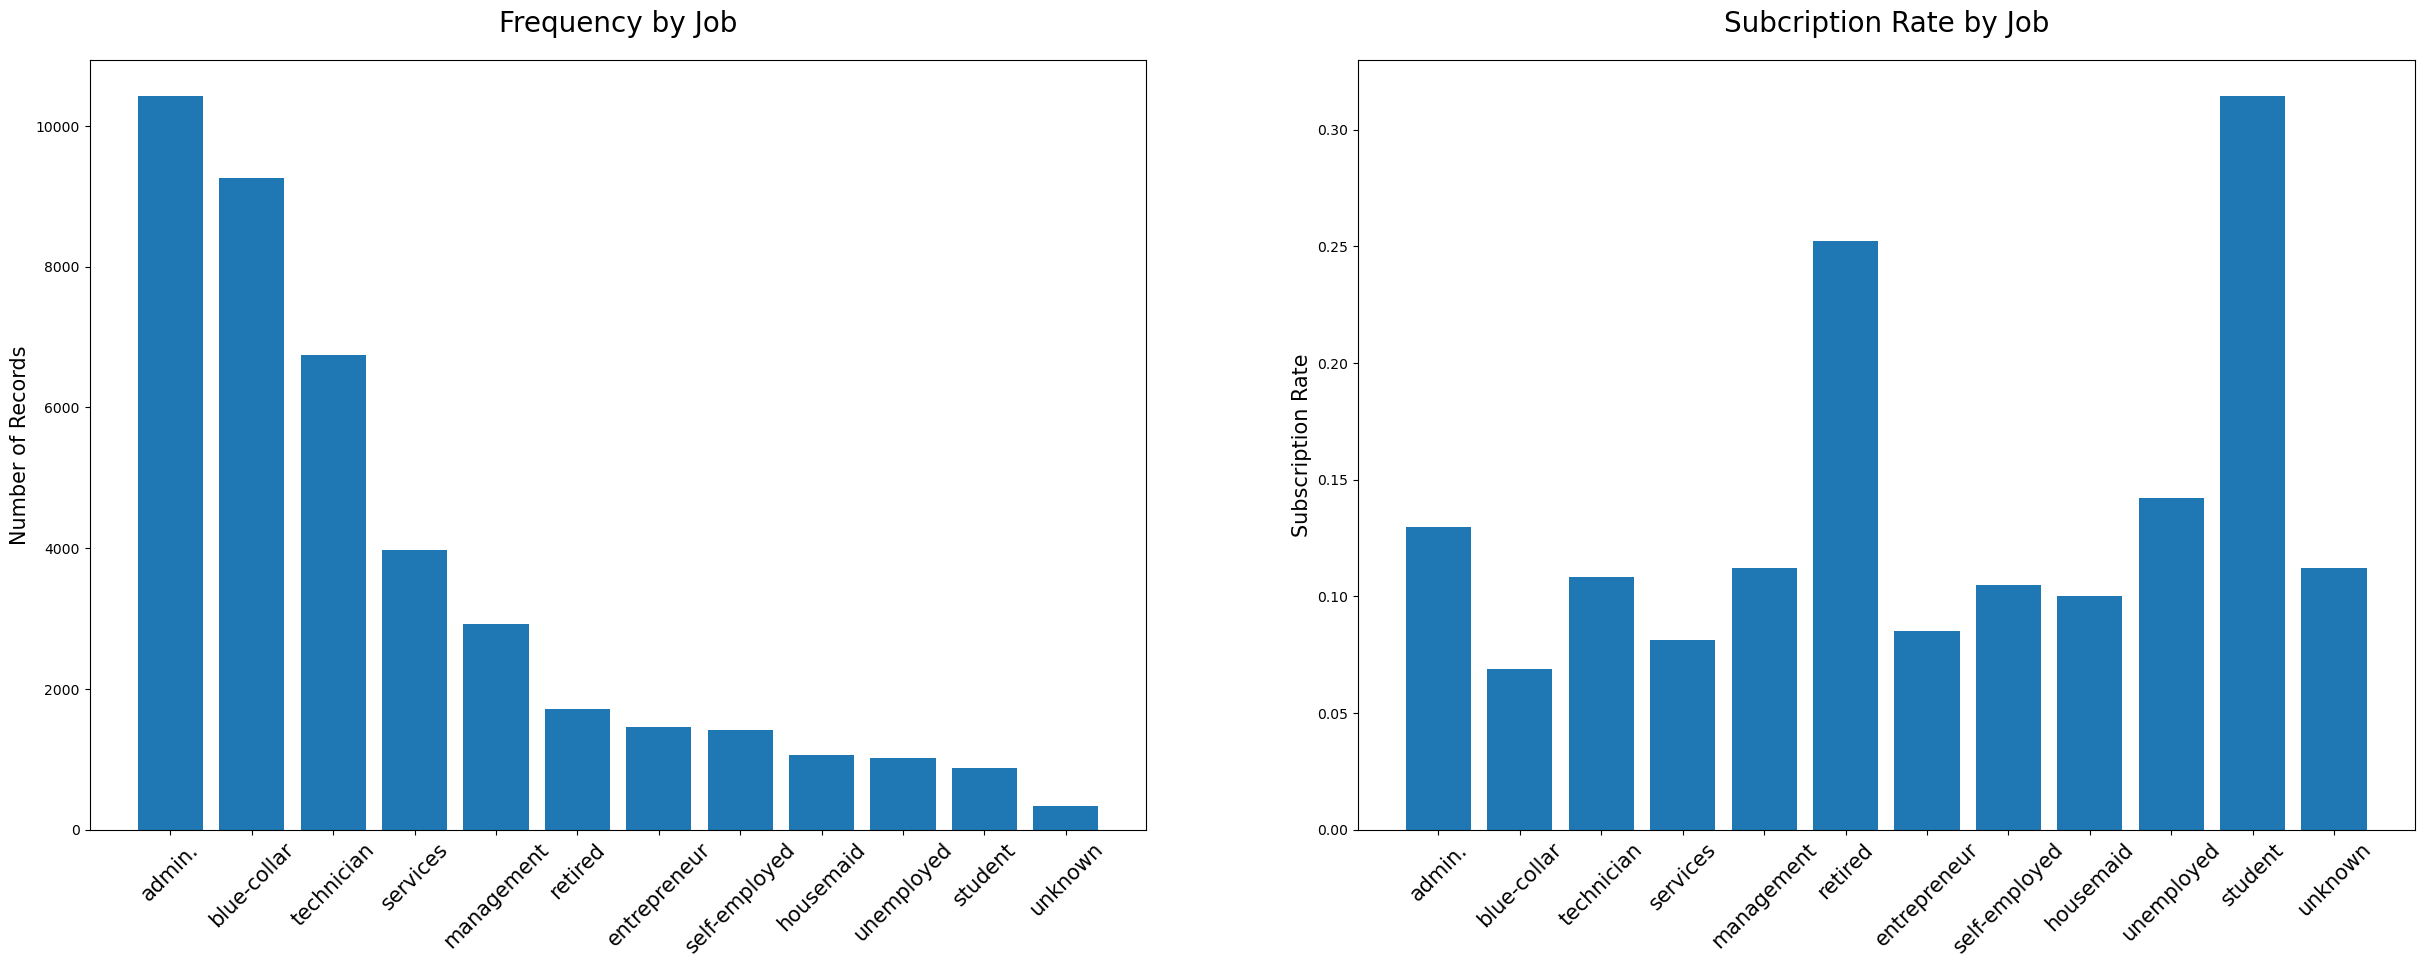

In [26]:
fig, ax = plt.subplots(1,2, figsize = (30, 10))
histCatVariablesCount(0,dfJob.Category,dfJob.Count,"Frequency by Job")
histCatVariablesSubscriptionRate(1,dfJob.Category,dfJob.Ratio,"Subcription Rate by Job")

#### Key Takeaways:
* There is a relationship between job and subscription
* "Student" and "Retired" have the highest subscription rate

#### Feature Engineering:
* Group 'blue-collar', 'technician','housemaid' under 'blue-collar'
* Group 'admin' and 'services' under 'services'
* Group 'management' and 'enterpreneur' under 'management'

### "Marital" analysis for Feature Engineering

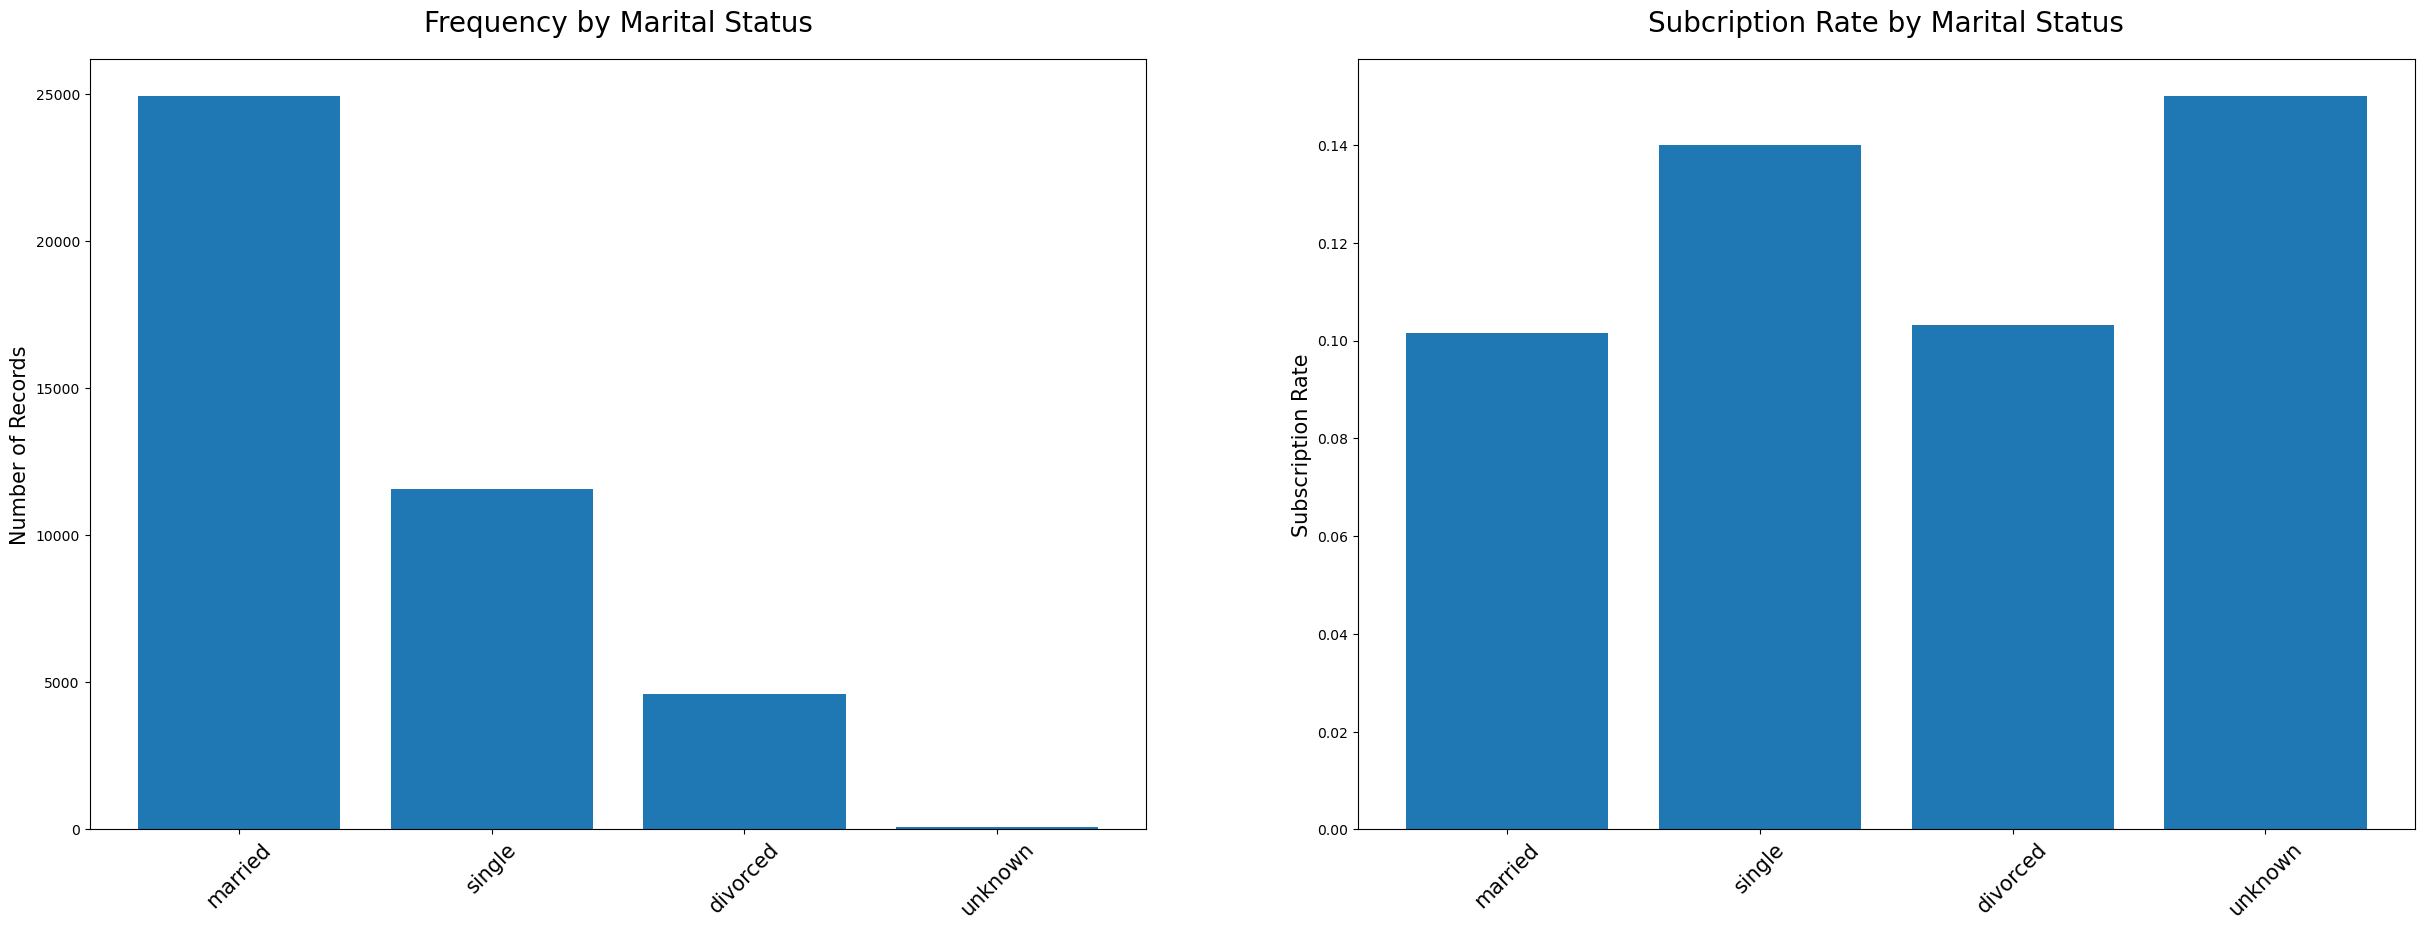

In [27]:
fig, ax = plt.subplots(1,2, figsize = (30, 10))
histCatVariablesCount(0,dfMarital.Category,dfMarital.Count,"Frequency by Marital Status")
histCatVariablesSubscriptionRate(1,dfMarital.Category,dfMarital.Ratio,"Subcription Rate by Marital Status")

#### Key Takeaways:

* There is a relationship between marital status and subscription
* "Single" people are more likely to subscribe

#### Feature Engineering:

* Label encode the Marital variable as follows:
    * married -> 0
    * divorced -> 1
    * single -> 2
    * unknown -> 2 ('unknown' will be grouped with 'single' because counts are small and subscription rate is similar)

### "Education" analysis for Feature Engineering

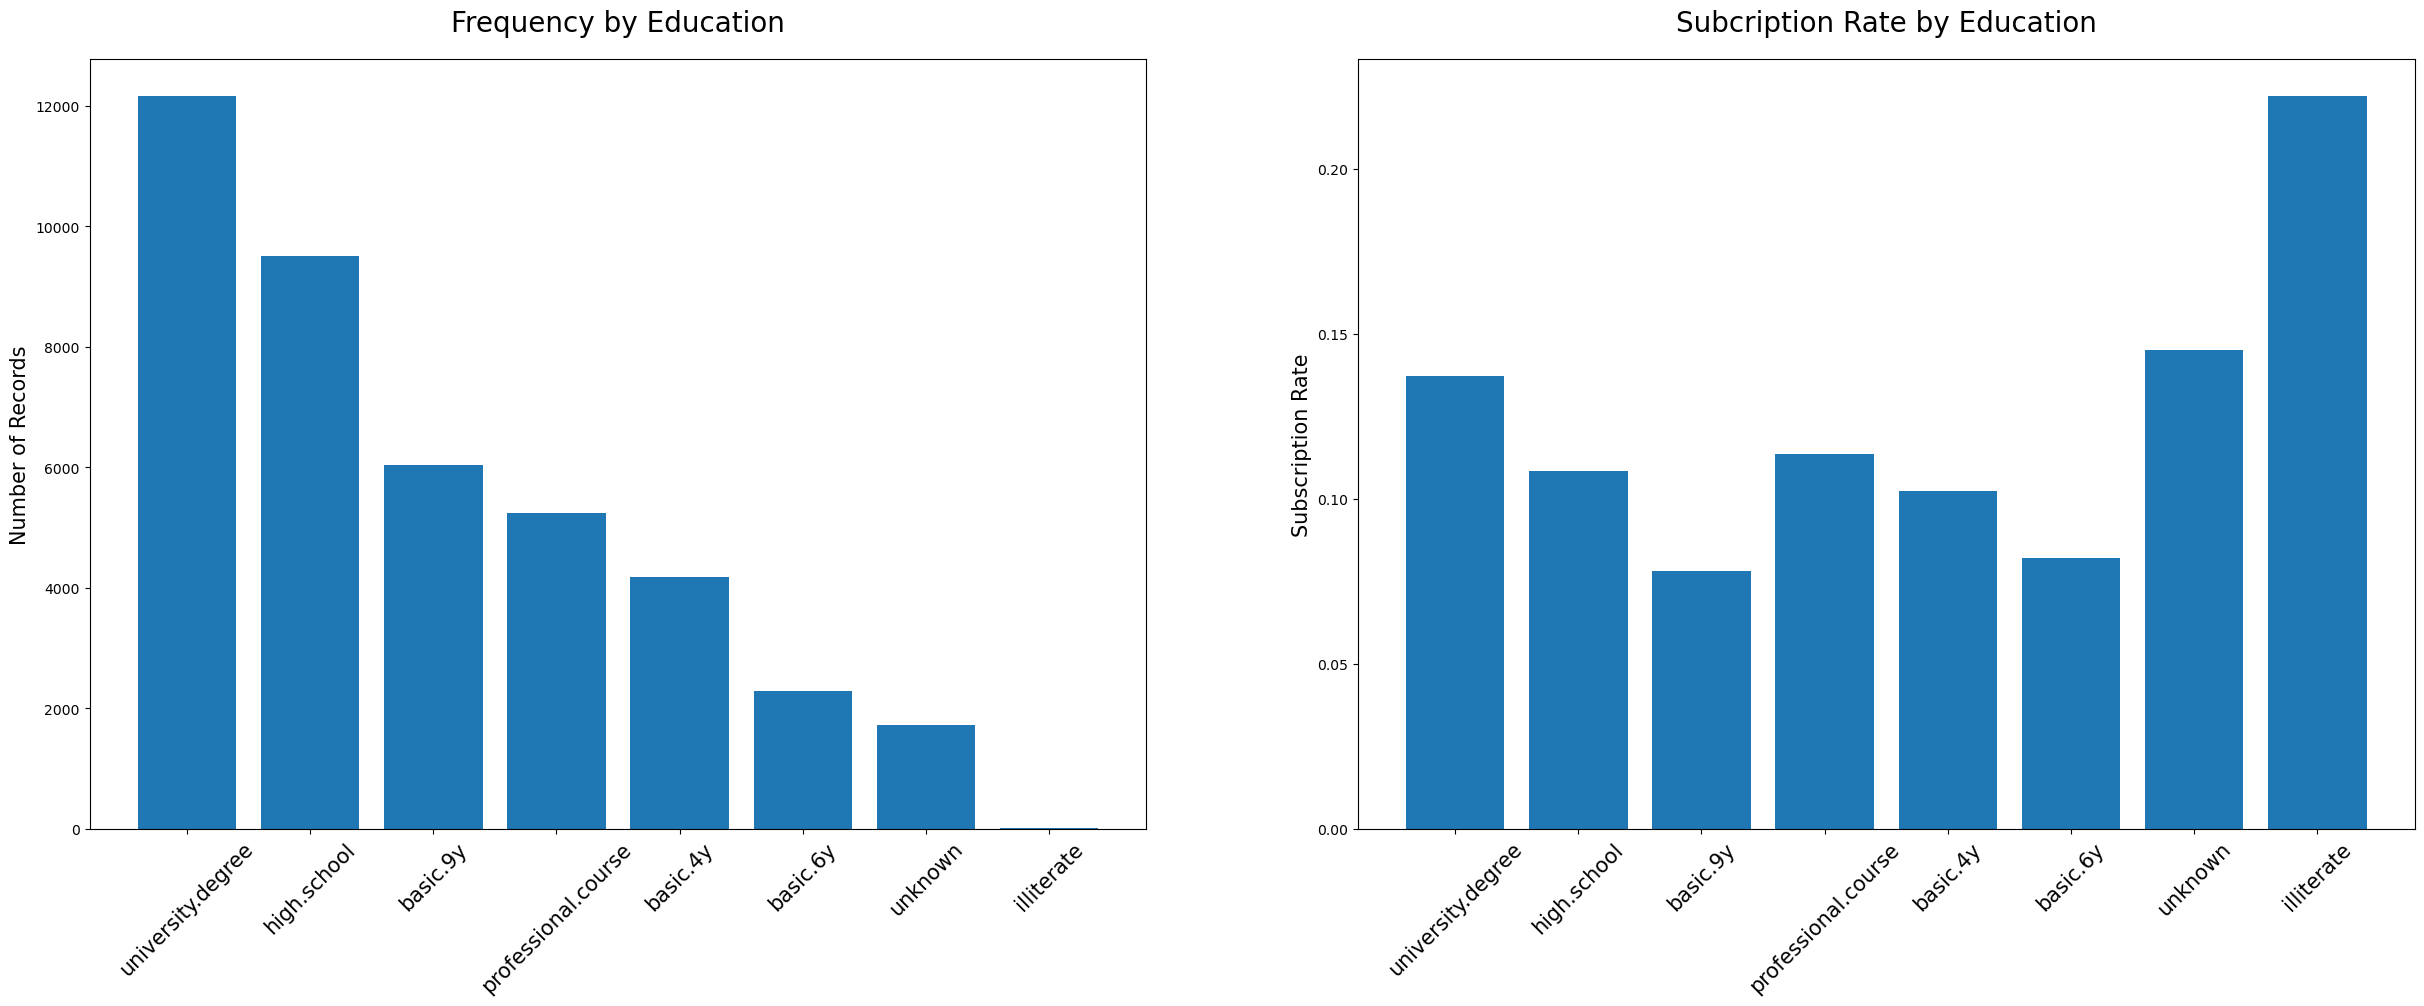

In [28]:
fig, ax = plt.subplots(1,2, figsize = (30, 10))
histCatVariablesCount(0,dfEducation.Category,dfEducation.Count,"Frequency by Education")
histCatVariablesSubscriptionRate(1,dfEducation.Category,dfEducation.Ratio,"Subcription Rate by Education")

#### Key Takeaways:

* There relationship between education and subscription is not strong
* "Illiterate" category is very small, so high subscription rate could be a data issue

#### Feature Engineering:

* Label encode the Education variable as follows:
    * illiterate -> 0
    * unknown -> 0
    * basic.4y -> 1
    * basic.6y -> 2
    * basic.9y -> 3
    * high.school -> 4
    * professional.course -> 5
    * university.degree -> 6

### "Default" analysis for Feature Engineering

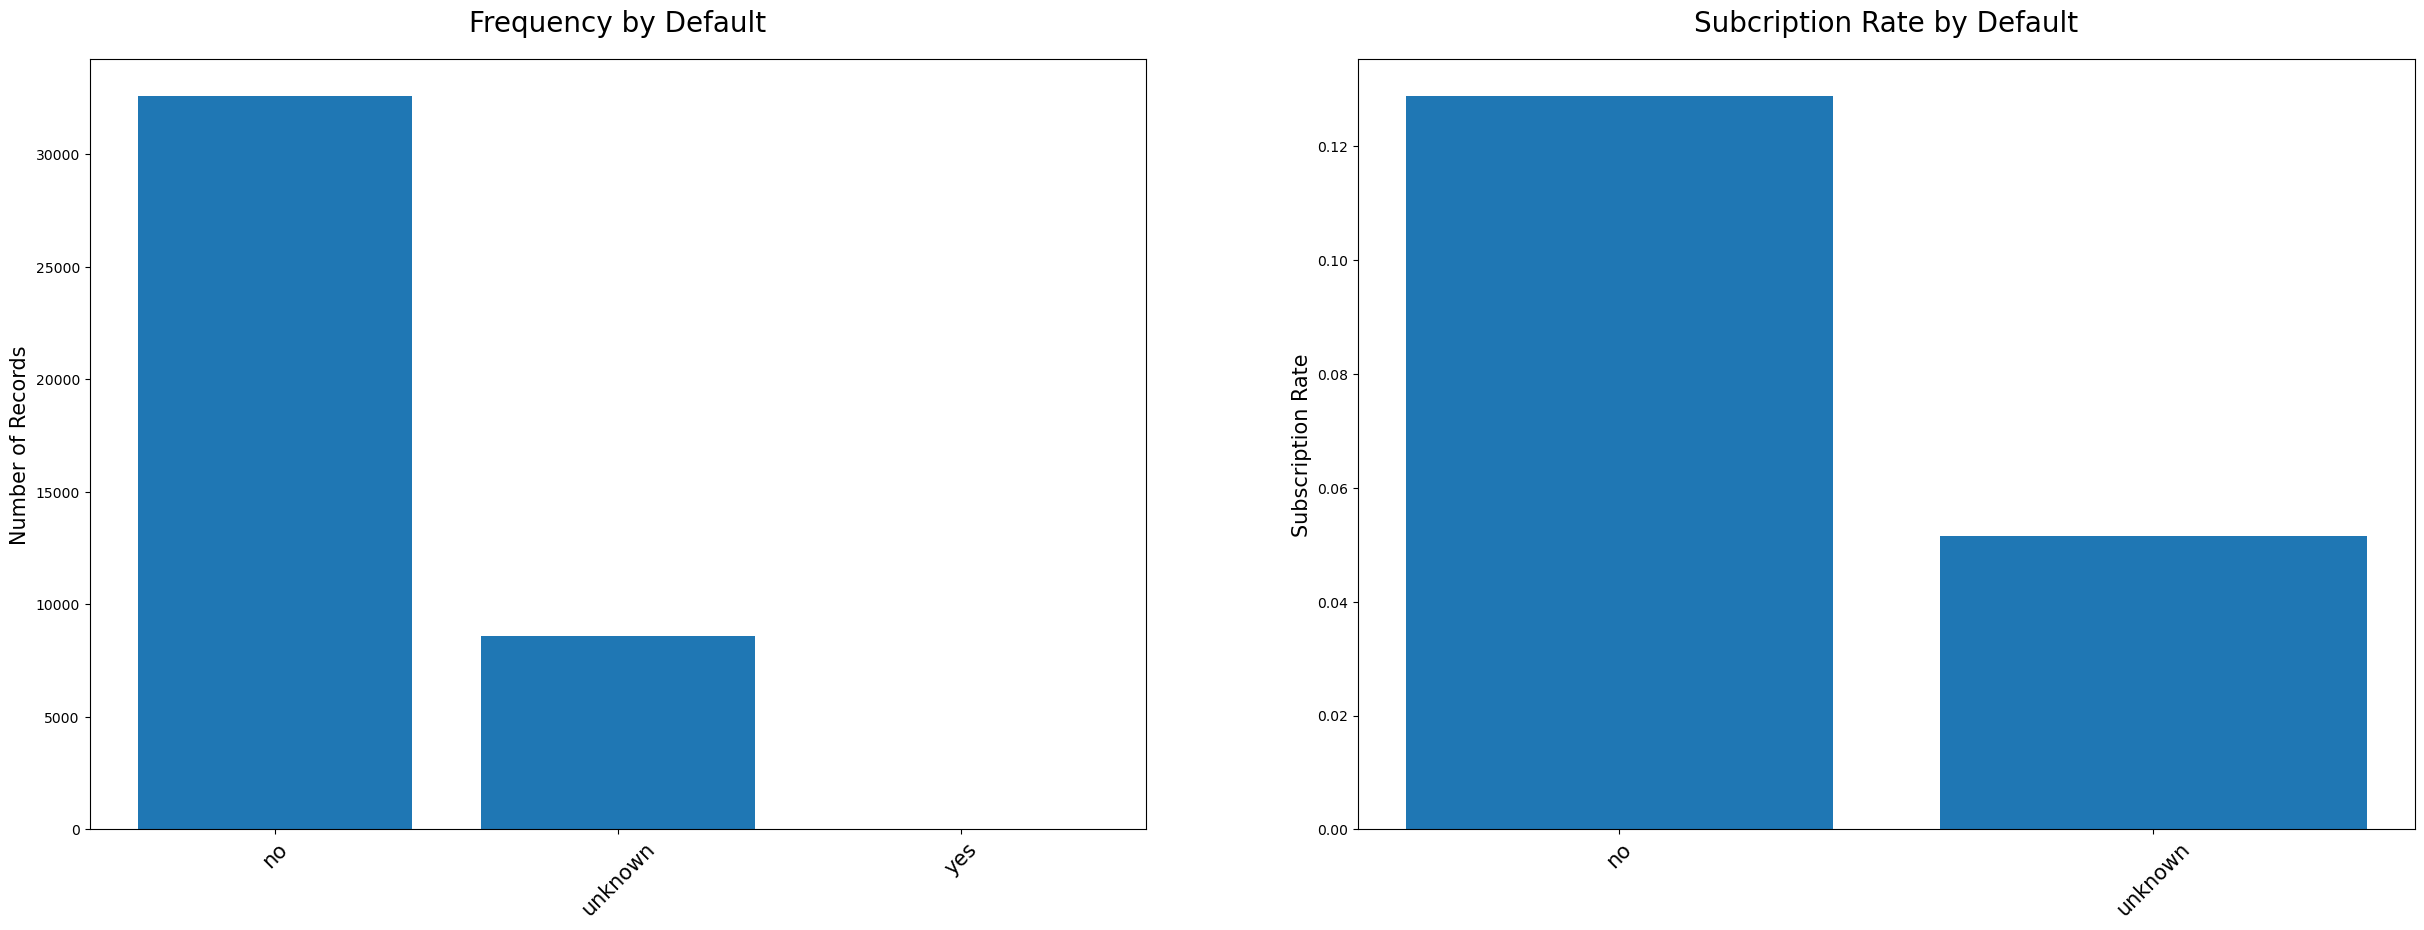

In [29]:
fig, ax = plt.subplots(1,2, figsize = (30, 10))
histCatVariablesCount(0,dfDefault.Category,dfDefault.Count,"Frequency by Default")
histCatVariablesSubscriptionRate(1,dfDefault.Category,dfDefault.Ratio,"Subcription Rate by Default")

### Key Takeaways:

* People who have not defaulted on their obligations are more likely to subscribe to a term deposit.
* 'Yes' population is very small with only a handful of records, could be a data issue. 'Unknown' and 'yes' might be the same group.

Feature Engineering:

### Label encode the Default variable as follows:
* unknown -> 0
* yes -> 0
* no -> 1


### "Housing" analysis for Feature Engineering

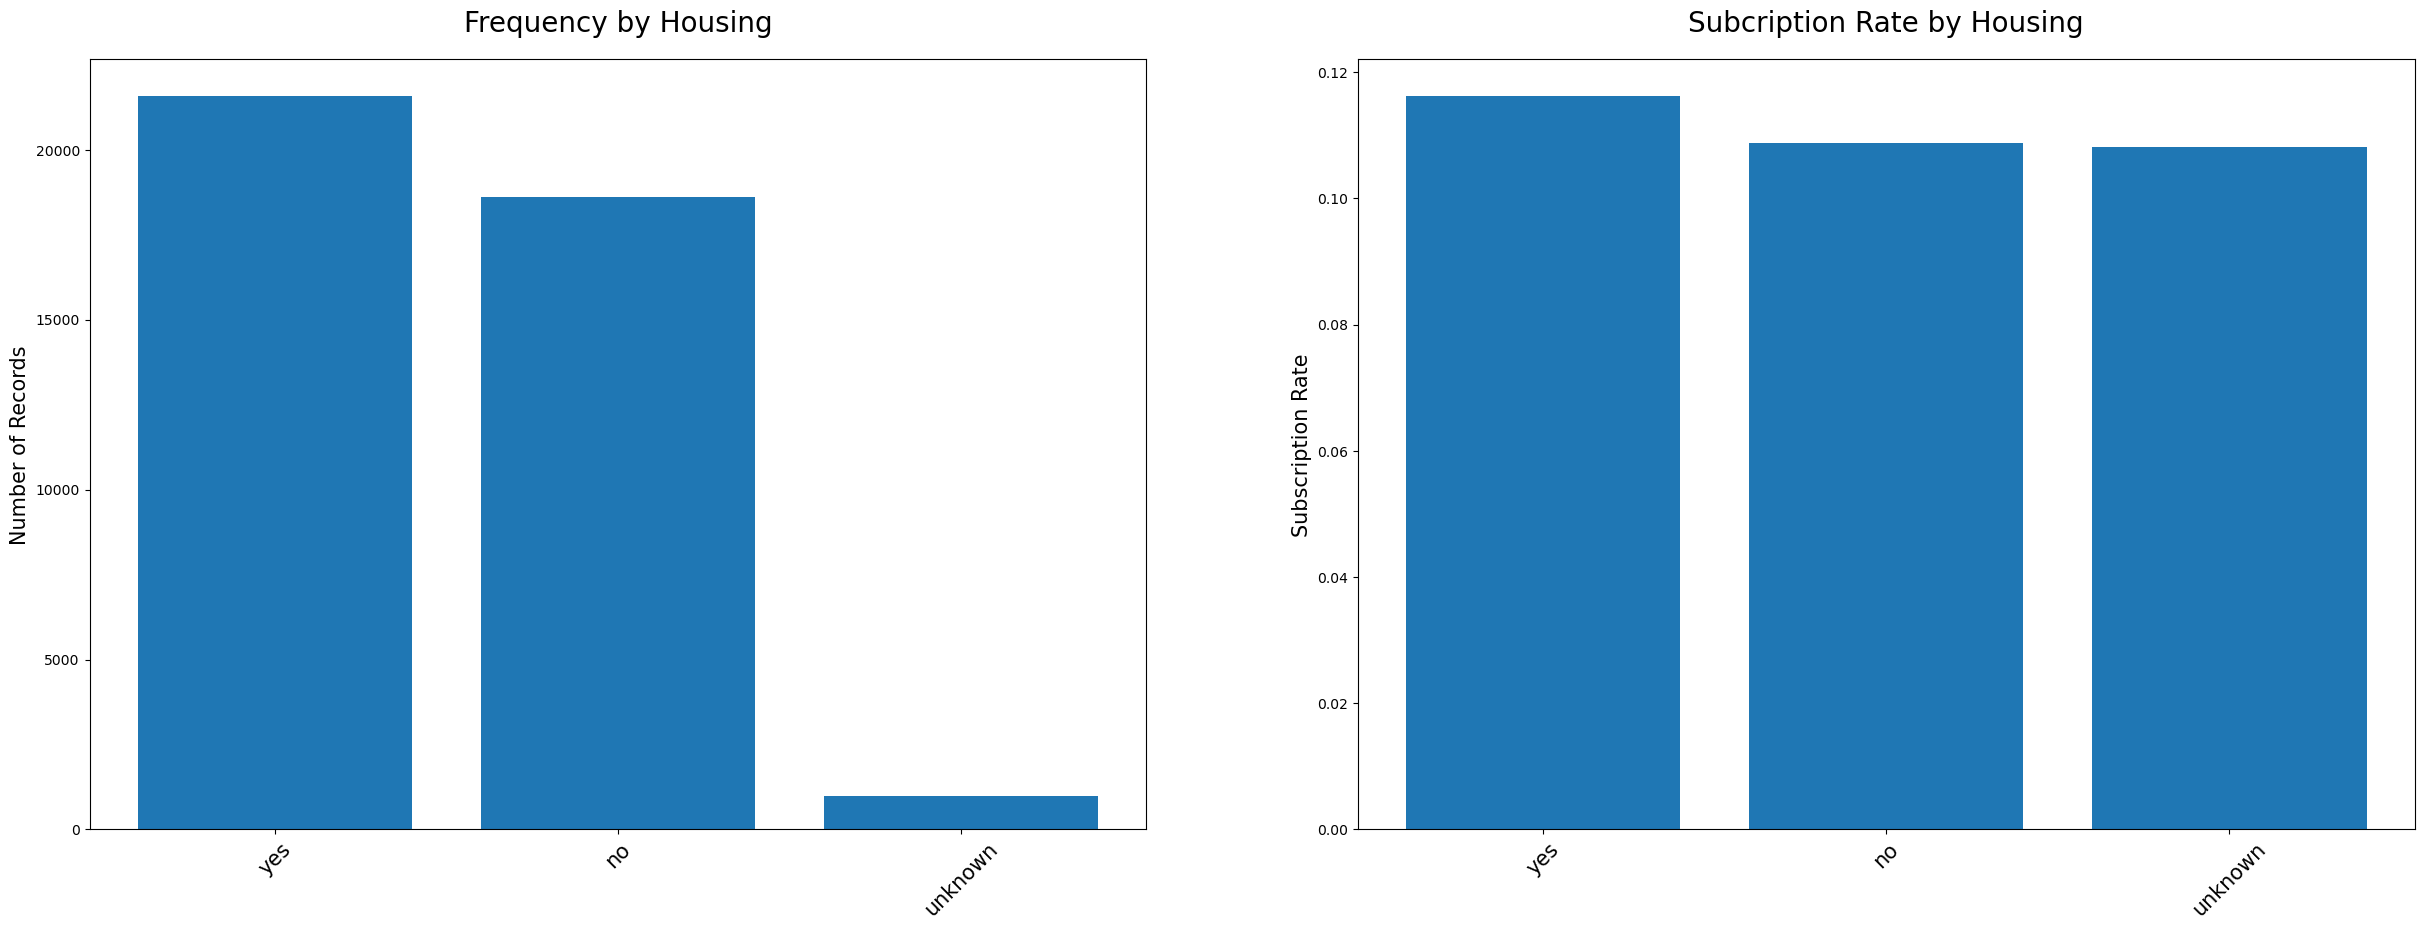

In [30]:
fig, ax = plt.subplots(1,2, figsize = (30, 10))
histCatVariablesCount(0,dfHousing.Category,dfHousing.Count,"Frequency by Housing")
histCatVariablesSubscriptionRate(1,dfHousing.Category,dfHousing.Ratio,"Subcription Rate by Housing")

### Key Takeaways:

* Correlation of this variable with the target is not strong.

### Feature Engineering:

* Drop "housing" from further evaluation


### "Loan" analysis for Feature Engineering

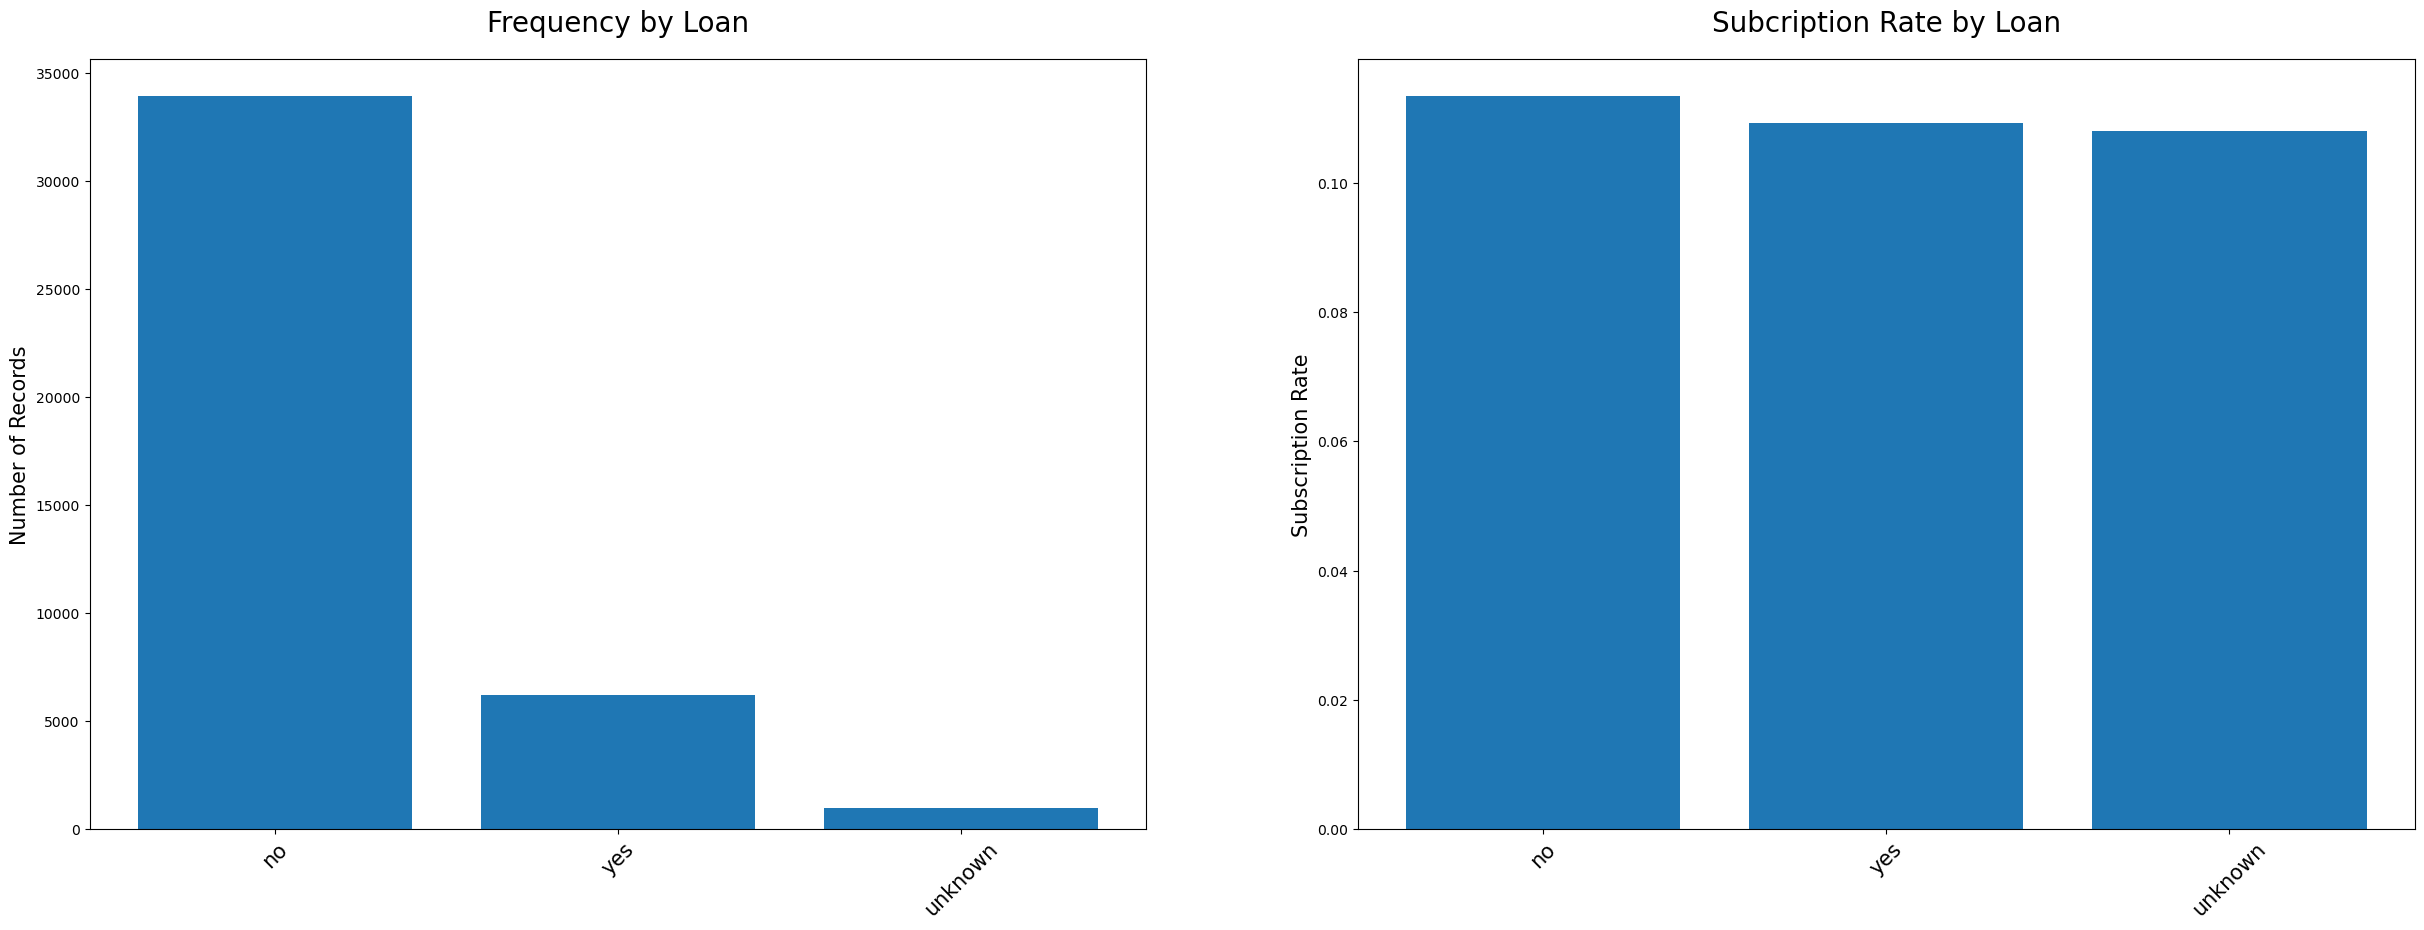

In [31]:
fig, ax = plt.subplots(1,2, figsize = (30, 10))
histCatVariablesCount(0,dfLoan.Category,dfLoan.Count,"Frequency by Loan")
histCatVariablesSubscriptionRate(1,dfLoan.Category,dfLoan.Ratio,"Subcription Rate by Loan")

### Key Takeaways:

* Correlation of this variable with the target is not strong.

### Feature Engineering:

* Drop "Loan" from further evaluation

### "Contact" analysis for Feature Engineering

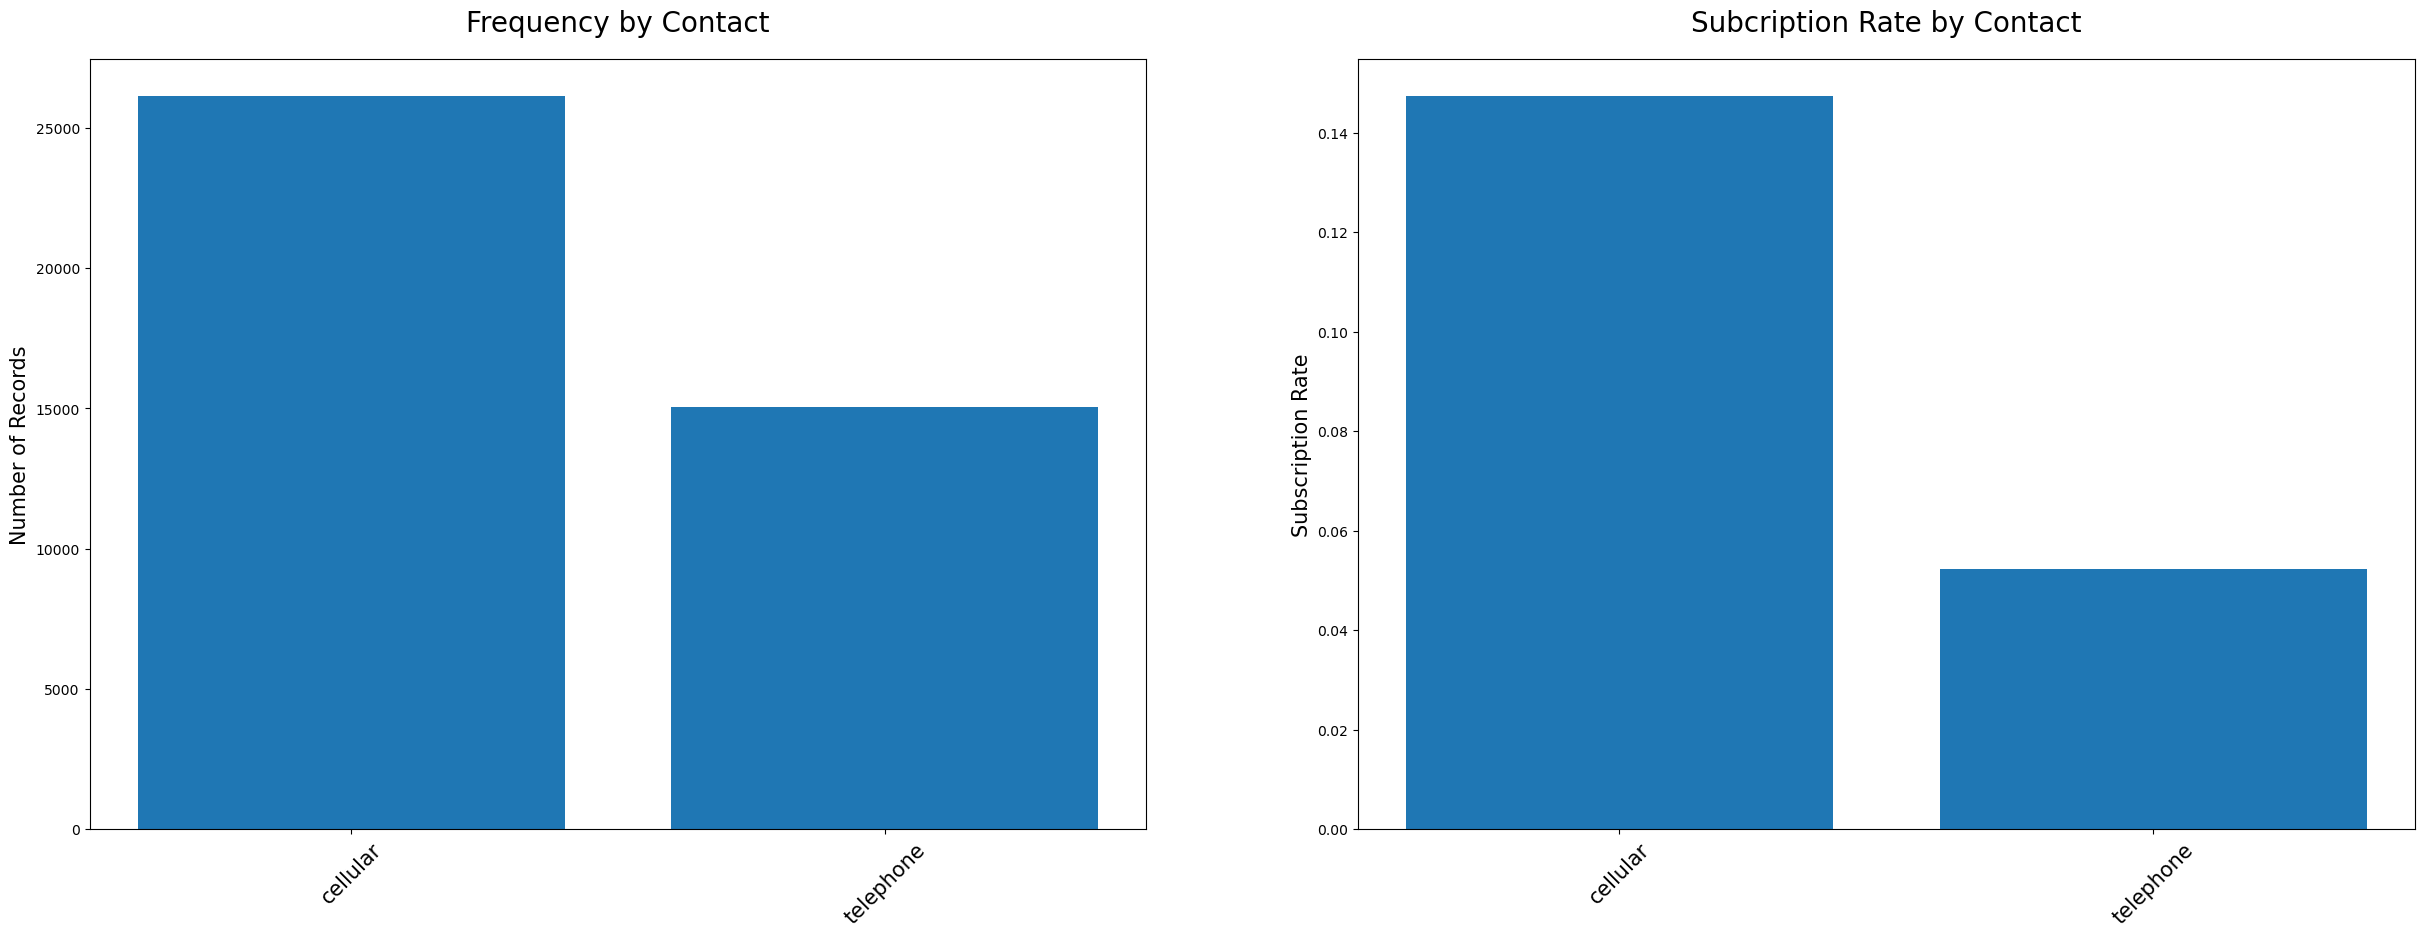

In [32]:
fig, ax = plt.subplots(1,2, figsize = (30, 10))
histCatVariablesCount(0,dfContact.Category,dfContact.Count,"Frequency by Contact")
histCatVariablesSubscriptionRate(1,dfContact.Category,dfContact.Ratio,"Subcription Rate by Contact")

### Key Takeaways:

* People contacted by mobile phones are more liely to subscribe.

### Feature Engineering:

* Label encode the contact variable as follows:
    * telephone -> 0
    * cellular -> 1

### "Month" analysis for Feature Engineering

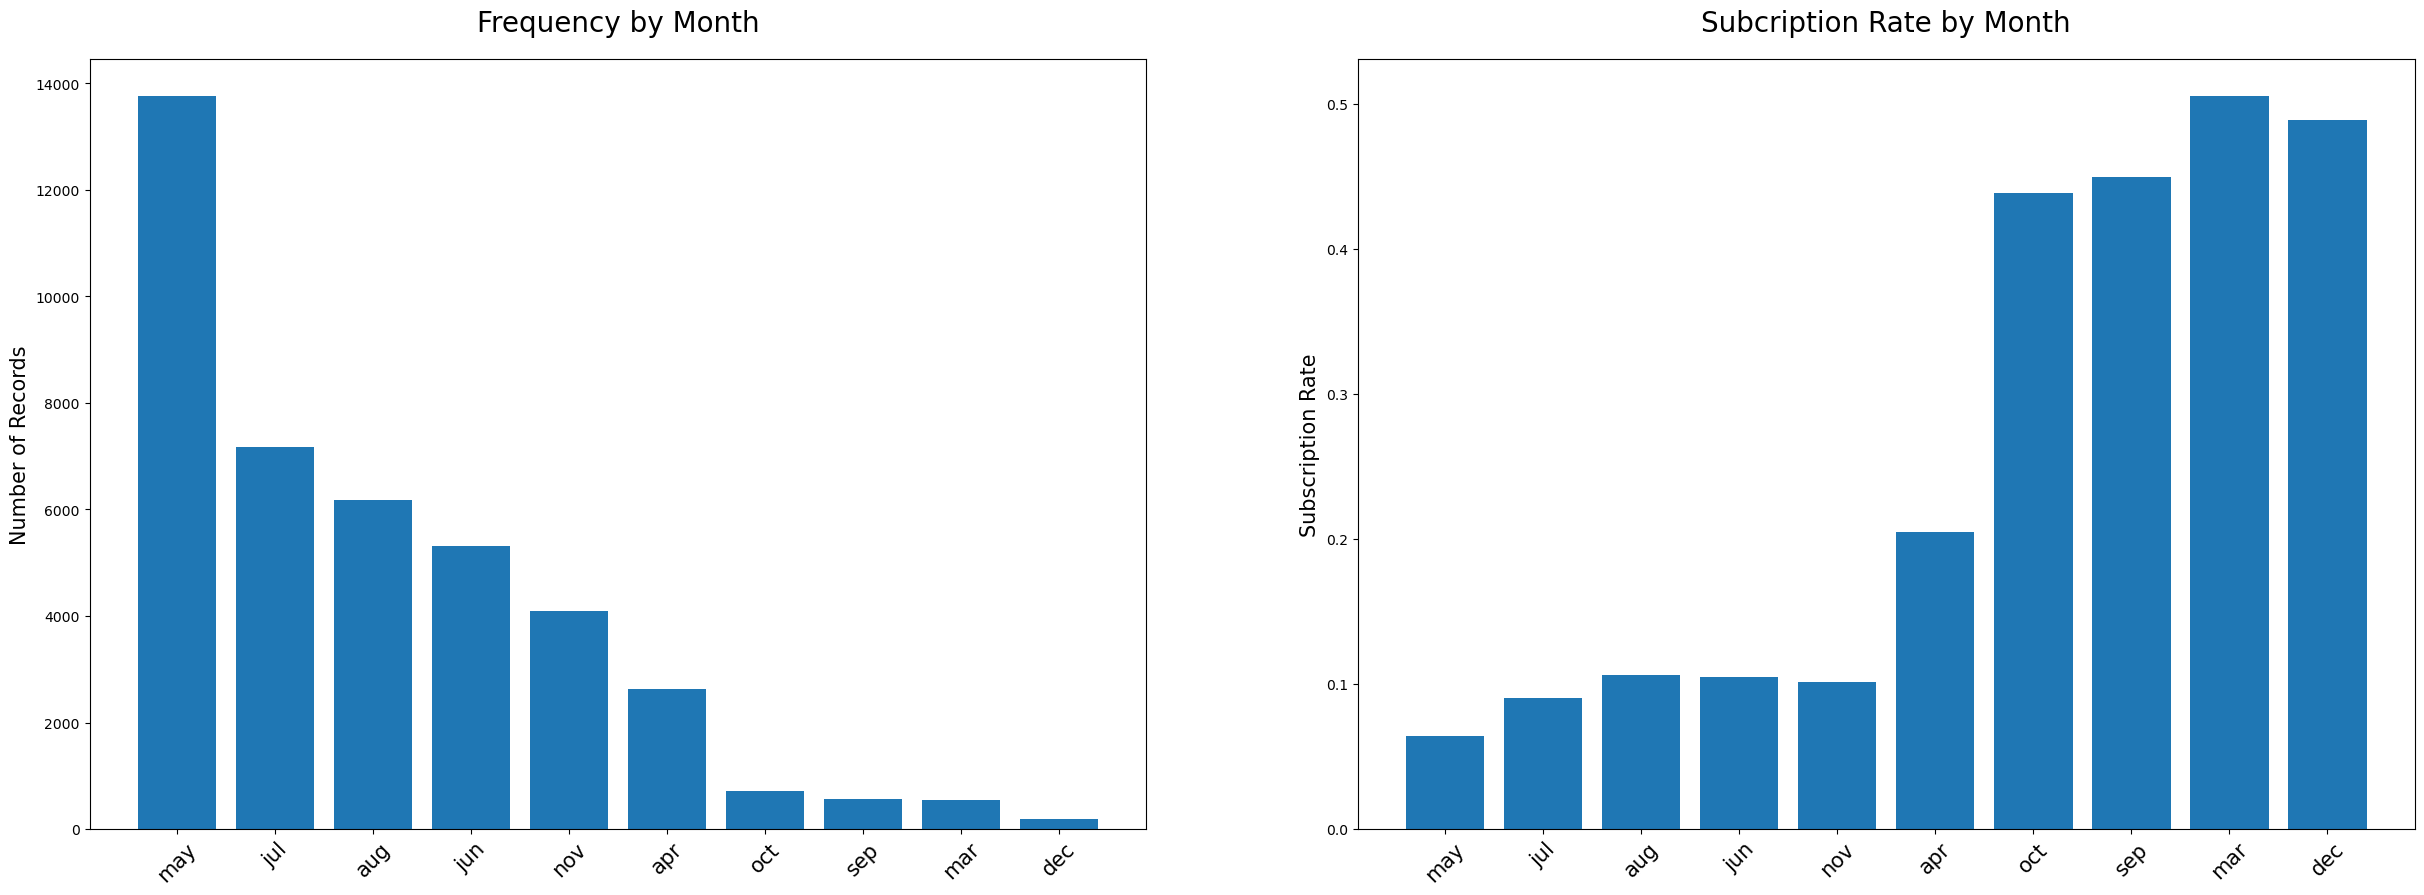

In [33]:
fig, ax = plt.subplots(1,2, figsize = (30, 10))
histCatVariablesCount(0,dfMonth.Category,dfMonth.Count,"Frequency by Month")
histCatVariablesSubscriptionRate(1,dfMonth.Category,dfMonth.Ratio,"Subcription Rate by Month")

### Key Takeaways:

* January and February data is missing
* People contacted in summer months are less likely to subscribe

### Feature Engineering:

* Hot encode the "month" variable

### "day_of_week" analysis for Feature Engineering

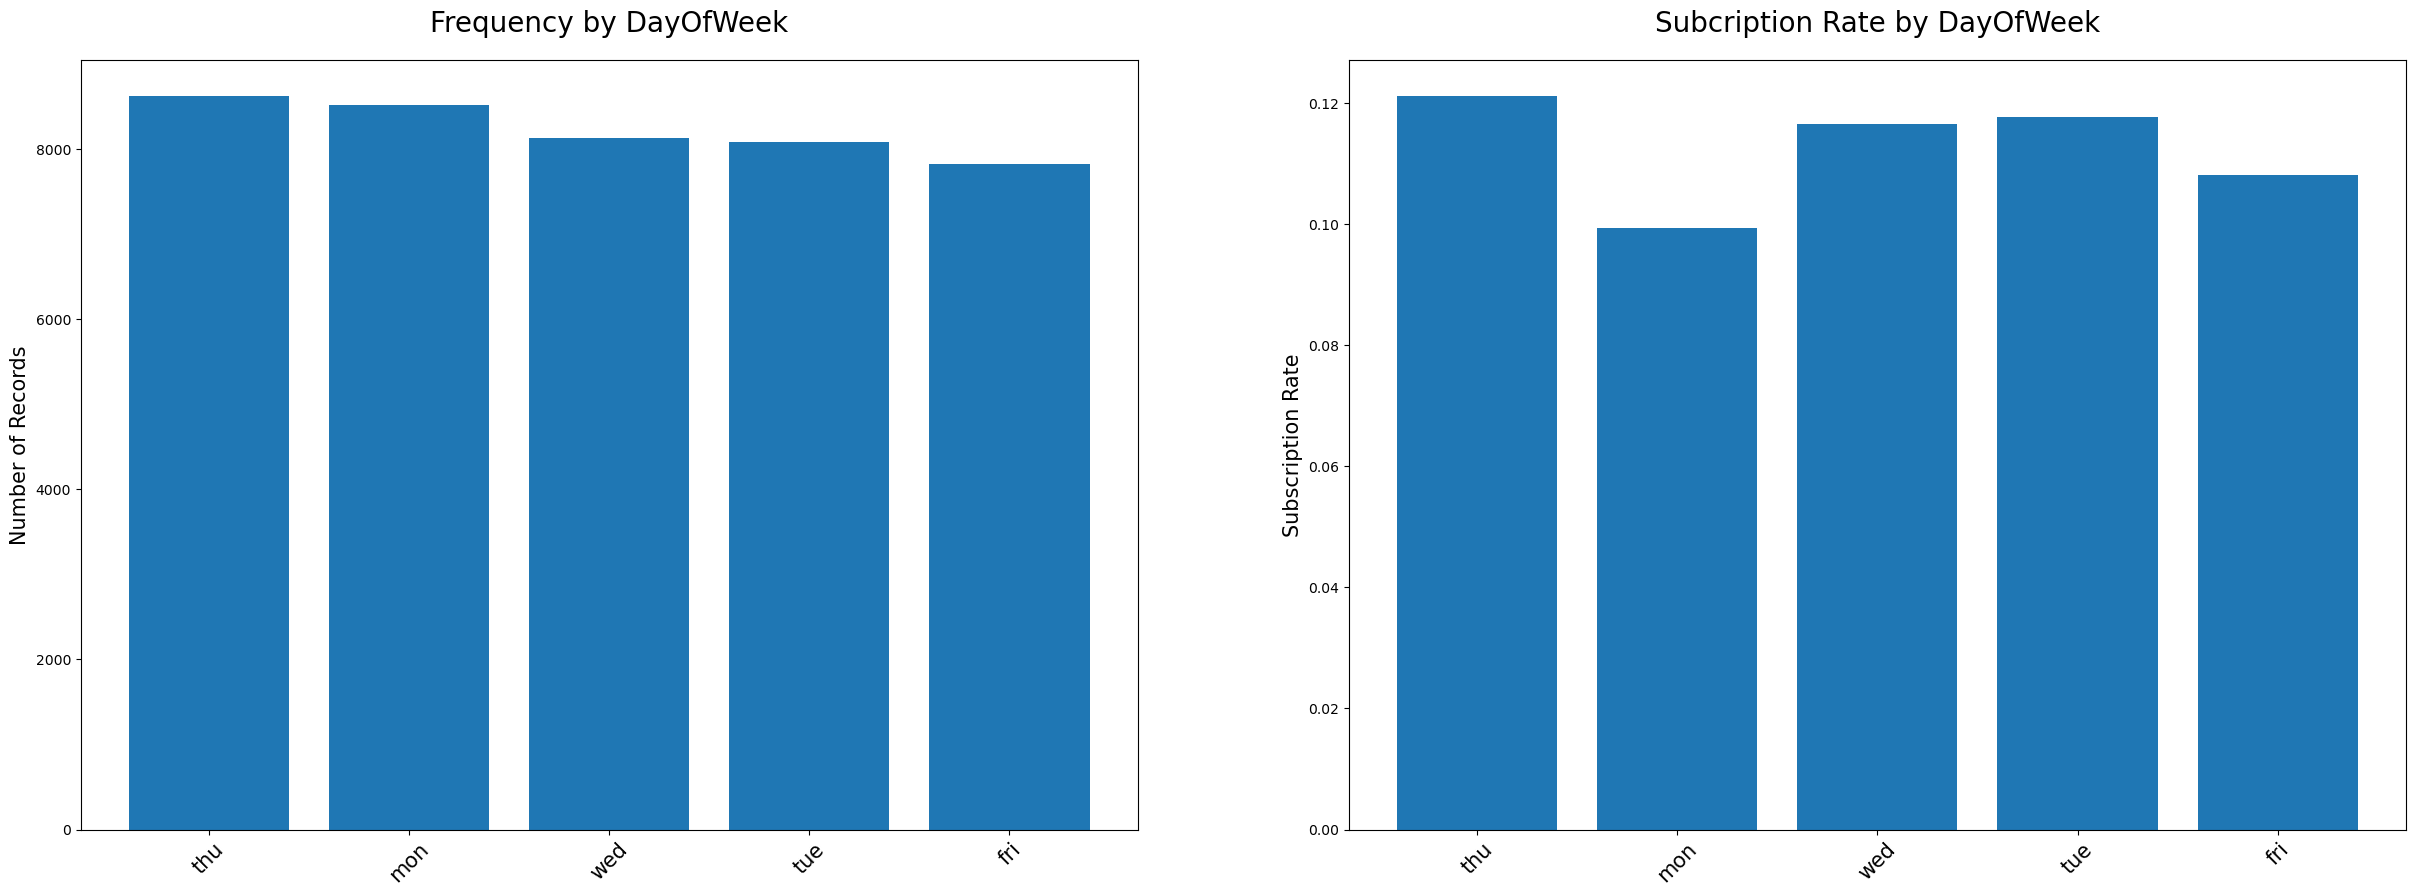

In [34]:
fig, ax = plt.subplots(1,2, figsize = (30, 10))
histCatVariablesCount(0,dfDayOfWeek.Category,dfDayOfWeek.Count,"Frequency by DayOfWeek")
histCatVariablesSubscriptionRate(1,dfDayOfWeek.Category,dfDayOfWeek.Ratio,"Subcription Rate by DayOfWeek")

### Key Takeaways:

* People contacted on Mondays and Fridays are less likely to subscribe

### Feature Engineering:

* Label encode the "day_of_week" variable as follows (group Tuesday, Wednesday and Thursday):
    * mon -> 0
    * fri -> 1
    * tue, wed, thu -> 2

### "poutcome" analysis for Feature Engineering

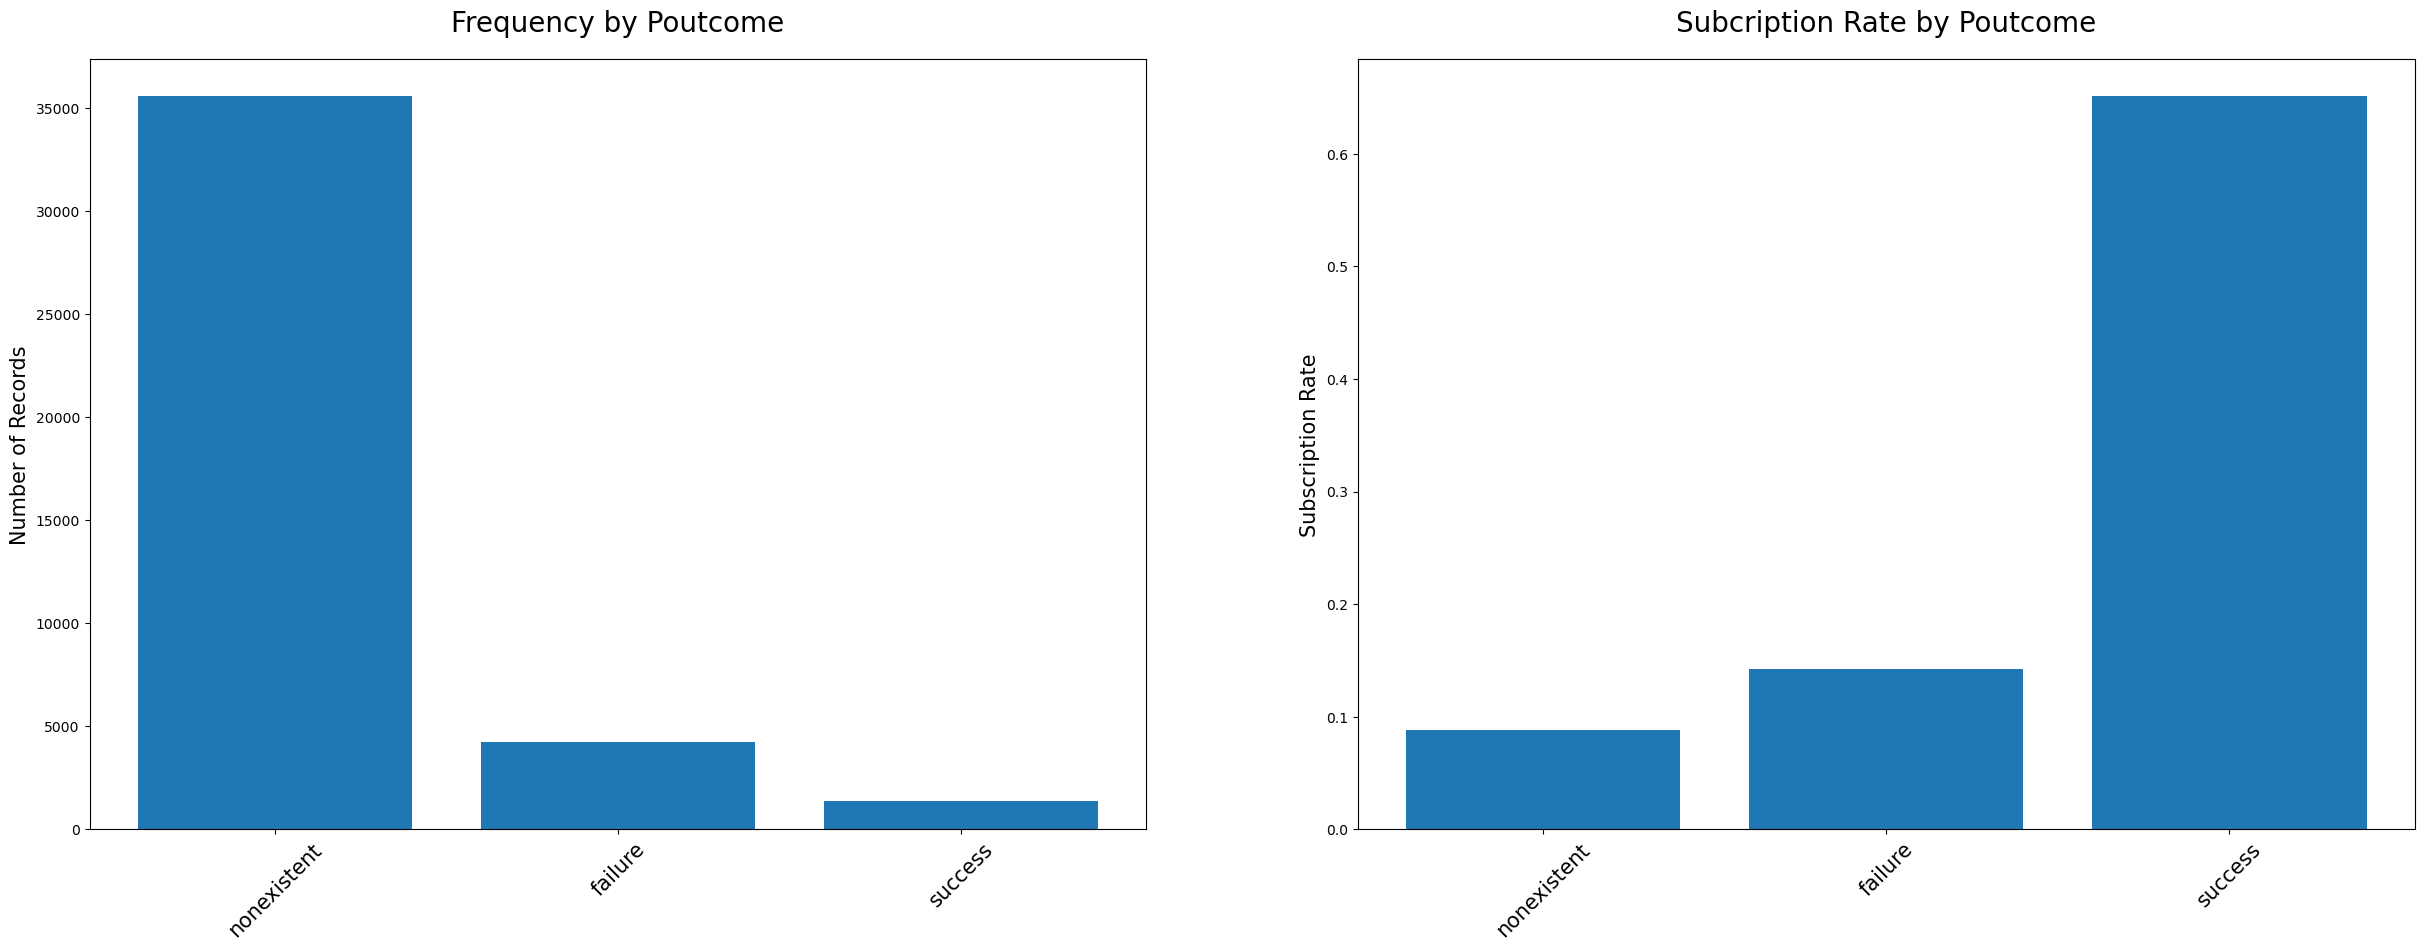

In [35]:
fig, ax = plt.subplots(1,2, figsize = (30, 10))
histCatVariablesCount(0,dfPOutcome.Category,dfPOutcome.Count,"Frequency by Poutcome")
histCatVariablesSubscriptionRate(1,dfPOutcome.Category,dfPOutcome.Ratio,"Subcription Rate by Poutcome")

### Key Takeaways:

* People who responded to the previous campaign are more likly to subscribe
* People who have not accepted previous campaign are more likely to subscribe than people who were never contacted

### Feature Engineering:

* Label encode the poutcome:
    * nonexistent -> 0
    * failure -> 1
    * success -> 2

### Analyze continuous variables

In [36]:
#Generate distribution
EDA_num_columns = df.select_dtypes(exclude=['object']).columns.tolist()
df[EDA_num_columns].describe()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.112654
std,10.42125,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,0.316173
min,17.00000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.00000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.00000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.00000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.00000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


In [37]:
#Get the list of continous variables which are not economic indicators
listCols = ['age','campaign','pdays','previous']

In [38]:
#Review the correlation between the variables and the target variable
df[listCols + ['y']].corr()

,age,campaign,pdays,previous,y
age,1.000000,0.004594,-0.034369,0.024365,0.030399
campaign,0.004594,1.000000,0.052584,-0.079141,-0.066357
pdays,-0.034369,0.052584,1.000000,-0.587514,-0.324914
previous,0.024365,-0.079141,-0.587514,1.000000,0.230181
y,0.030399,-0.066357,-0.324914,0.230181,1.000000


### Key Takeaways:

* 'Age' does not seem to be correlated with target
* Both 'previous' and 'pdays' are correlated with the subscription rate. 'previous' is the number of contacts before this compaign and 'pdays' is the duration after the last contact before this campaign. Prospects that have been more in touch with the bank (and recently) may be more likely to take up an offer.
* 'campaign' shows the number of contacts performed during this campaign. Intuitively, I would expect to see a positive correltion, howeever it has negative correlation. There could be a data issue. 


### More detailed "Age" analysis

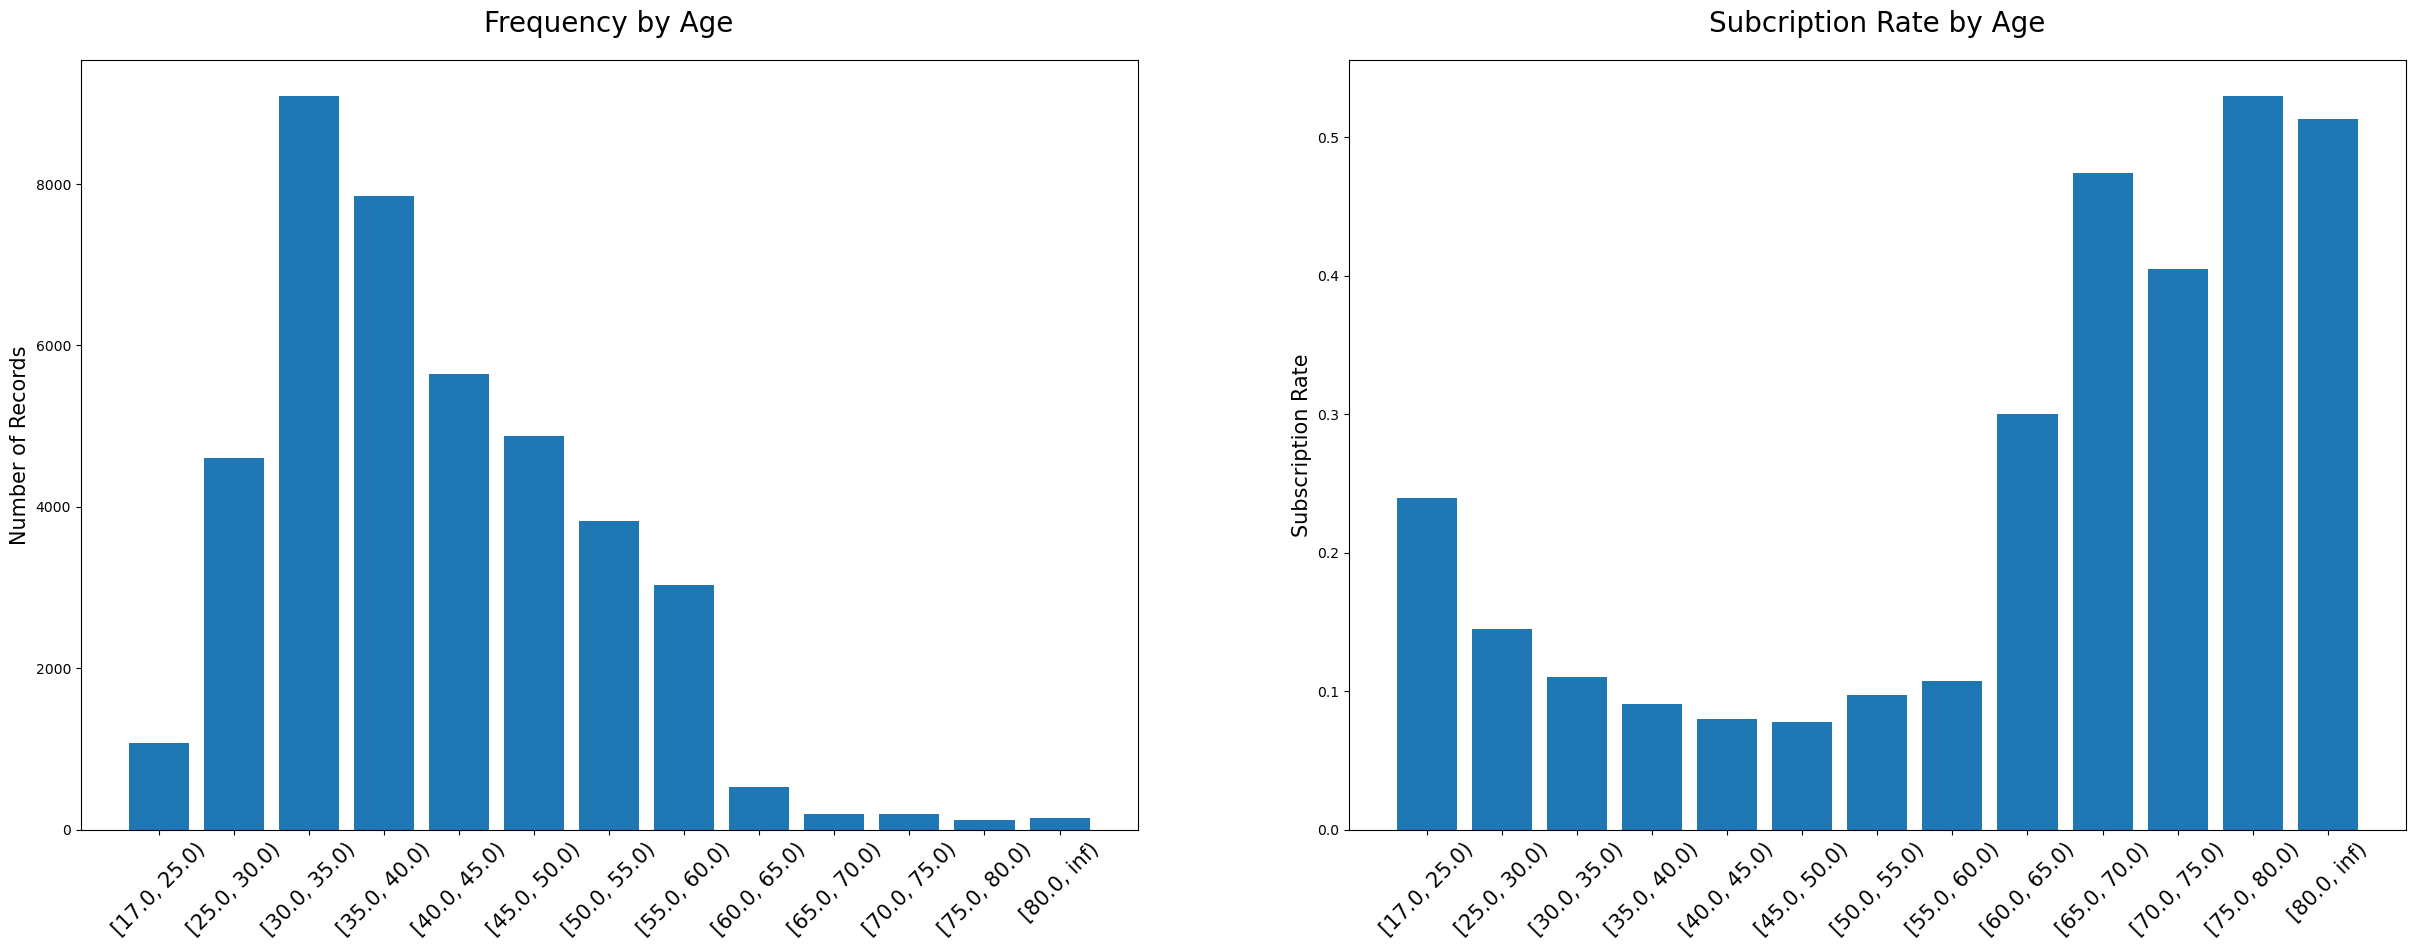

In [39]:
#Generate a distribution of age for subscribers and non-subscribers
# Define age bins
ageBinning = [17,25,30,35,40,45,50,55,60,65,70,75,80,float("inf")]

# Create a new column 'ageBin' with the binned ages
df['ageBin'] = pd.cut(x=df['age'],right=False,bins = ageBinning)

# Get the count of age bins for non-responders (y == 0), sort, and rename columns
dfAgeNonResponder = (
    df[df['y'] == 0]['ageBin'].value_counts()  # Get the value counts 
    .to_frame(name="Perc")                                   # Create a DataFrame with the 'Perc' column
    .sort_index()                                            # Sort by index (the bins)
    .reset_index()                                           # Reset index to turn bins into a column
    .rename(columns={"ageBin": "Age"})                       # Rename columns
)

# Get the count of age bins for responders (y == 1), sort, and rename columns
dfAgeResponder = (
    df[df['y'] == 1]['ageBin'].value_counts()  # Get the value counts 
    .to_frame(name="Perc")                                   # Create a DataFrame with the 'Perc' column
    .sort_index()                                            # Sort by index (the bins)
    .reset_index()                                           # Reset index to turn bins into a column
    .rename(columns={"ageBin": "Age"})                       # Rename columns
)

dfAgeNonResponder['Age'] = dfAgeNonResponder['Age'].astype(str)
dfAgeResponder['Age'] = dfAgeResponder['Age'].astype(str)

# Merge dataframes
dfAge = pd.merge(dfAgeNonResponder,dfAgeResponder, on = "Age").rename(columns = {"Perc_x":"NonResponder","Perc_y":"Responder"})

dfAge['subscriptionRate'] = dfAge['Responder']/(dfAge['Responder'] + dfAge['NonResponder'])
dfAge['total'] = (dfAge['Responder'] + dfAge['NonResponder'])

fig, ax = plt.subplots(1,2, figsize = (30, 10))
histCatVariablesCount(0,dfAge.Age,dfAge.total,"Frequency by Age")
histCatVariablesSubscriptionRate(1,dfAge.Age,dfAge.subscriptionRate,"Subcription Rate by Age")

### Key Takeaways:

* Older prospects tend to sign up. The same is true for the younger segment of the population. Earlier, we saw that retirees and students are morely like to use the service.
* Will keep this variable as is for the analysis


### More detailed "Campaign" analysis

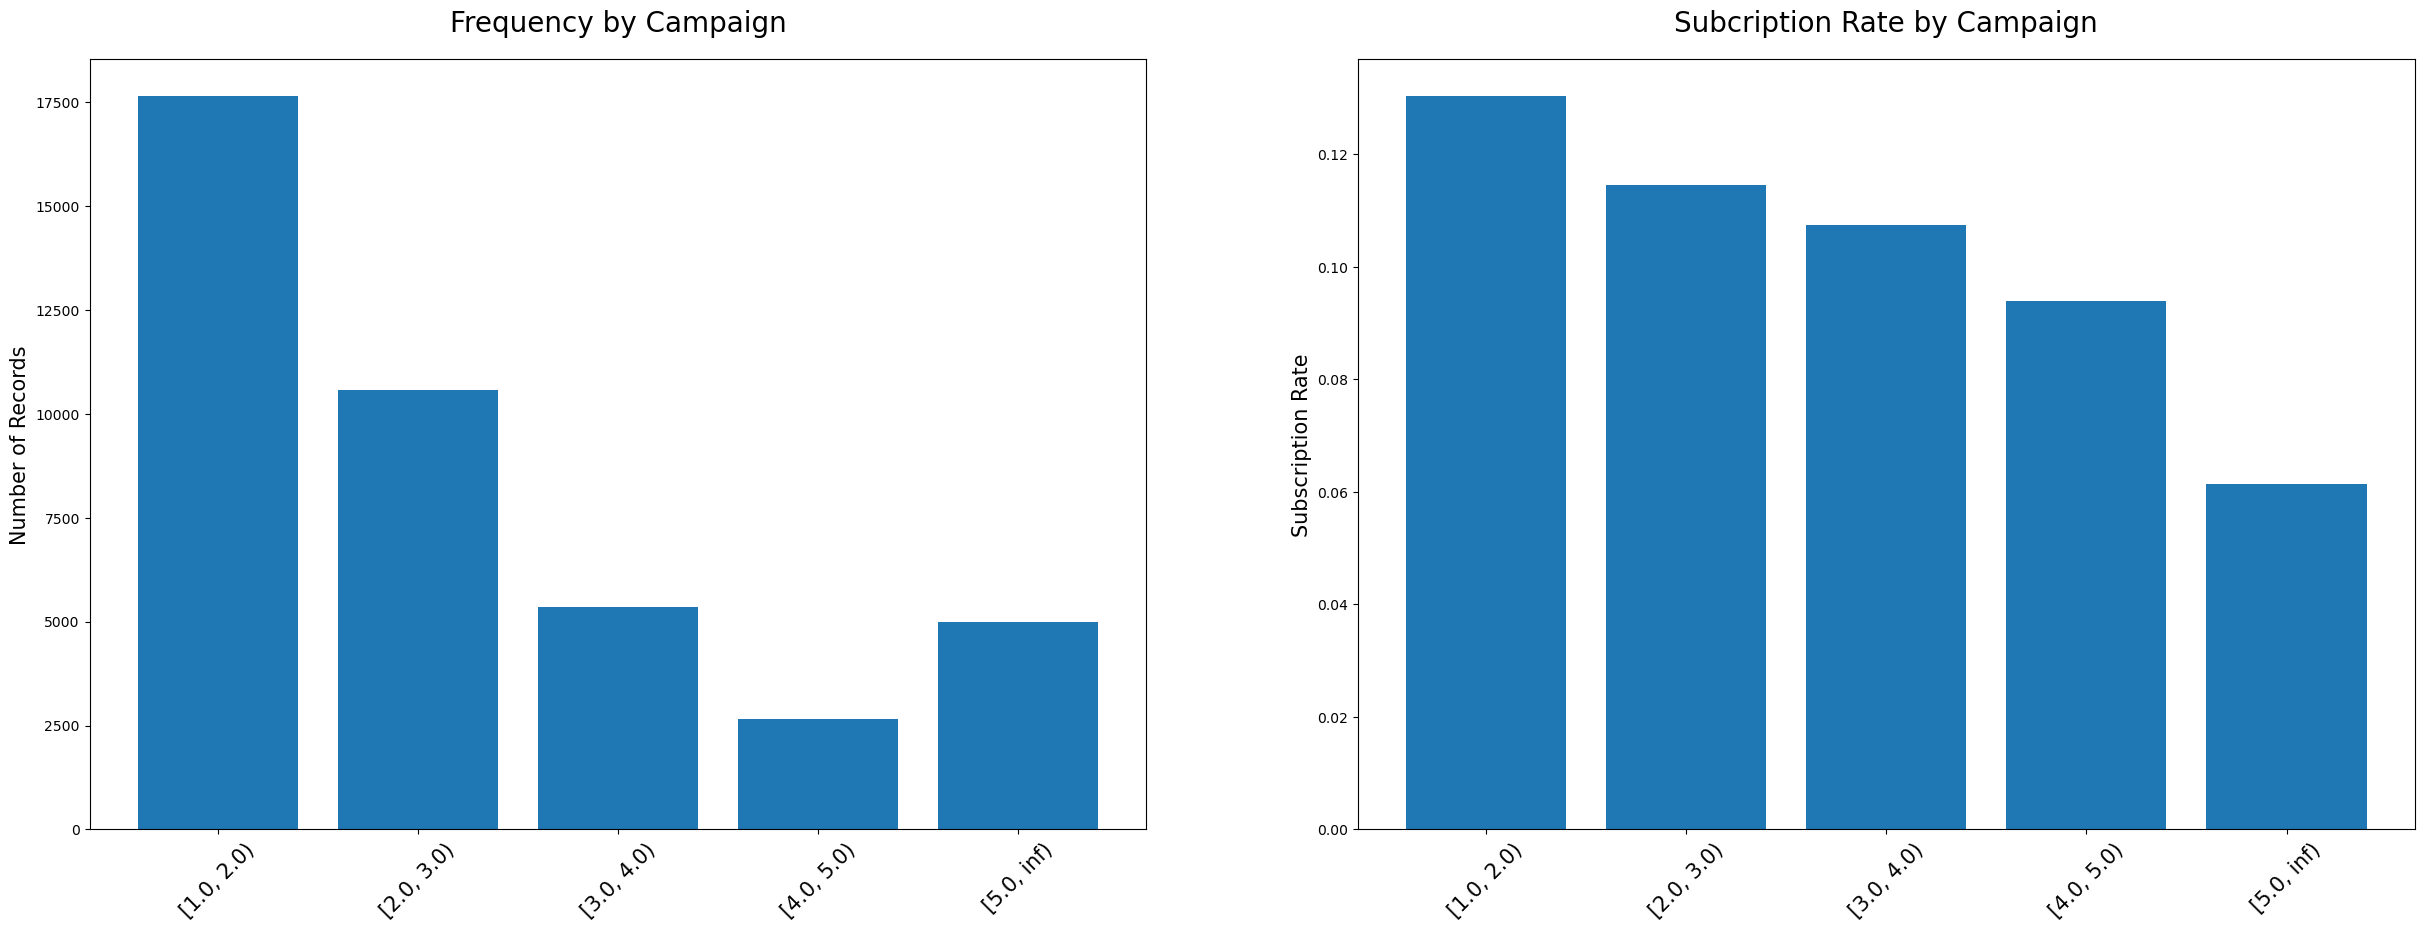

In [40]:
#Generate a distribution of Campaign for subscribers and non-subscribers
campaignBinning = [1,2,3,4,5,float("inf")]
df['campaignBin'] = pd.cut(x=df['campaign'],right=False,bins = campaignBinning)

# Get the count of  bins for non-responders (y == 0), sort, and rename columns
dfCampaignNonResponder  = (
    df[df['y'] == 0]['campaignBin'].value_counts()  # Get the value counts 
    .to_frame(name="Perc")                                   # Create a DataFrame with the 'Perc' column
    .sort_index()                                            # Sort by index (the bins)
    .reset_index()                                           # Reset index to turn bins into a column
    .rename(columns={"campaignBin": "Campaign"})                       # Rename columns
)

# Get the count of  bins for responders (y == 1), sort, and rename columns
dfCampaignResponder = (
    df[df['y'] == 1]['campaignBin'].value_counts()  # Get the value counts 
    .to_frame(name="Perc")                                   # Create a DataFrame with the 'Perc' column
    .sort_index()                                            # Sort by index (the bins)
    .reset_index()                                           # Reset index to turn bins into a column
    .rename(columns={"campaignBin": "Campaign"})                       # Rename columns
)

dfCampaignNonResponder['Campaign'] = dfCampaignNonResponder['Campaign'].astype(str)
dfCampaignResponder['Campaign'] = dfCampaignResponder['Campaign'].astype(str)
dfCampaign = pd.merge(dfCampaignNonResponder,dfCampaignResponder, on = "Campaign").rename(columns = {"Perc_x":"NonResponder","Perc_y":"Responder"})

dfCampaign = pd.merge(dfCampaignNonResponder,dfCampaignResponder, on = "Campaign").rename(columns = {"Perc_x":"NonResponder","Perc_y":"Responder"})
dfCampaign['subscriptionRate'] = dfCampaign['Responder']/(dfCampaign['Responder'] + dfCampaign['NonResponder'])
dfCampaign['total'] = (dfCampaign['Responder'] + dfCampaign['NonResponder'])

fig, ax = plt.subplots(1,2, figsize = (30, 10))
histCatVariablesCount(0,dfCampaign.Campaign,dfCampaign.total,"Frequency by Campaign")
histCatVariablesSubscriptionRate(1,dfCampaign.Campaign,dfCampaign.subscriptionRate,"Subcription Rate by Campaign")

### Key Takeaways:

* Prospects who were contacted less are more likely to subscribe to the service, which is counterintuitive. Like mentioned above, this could be a data issue. Will remove this variable.


### More detailed "pdays" analysis

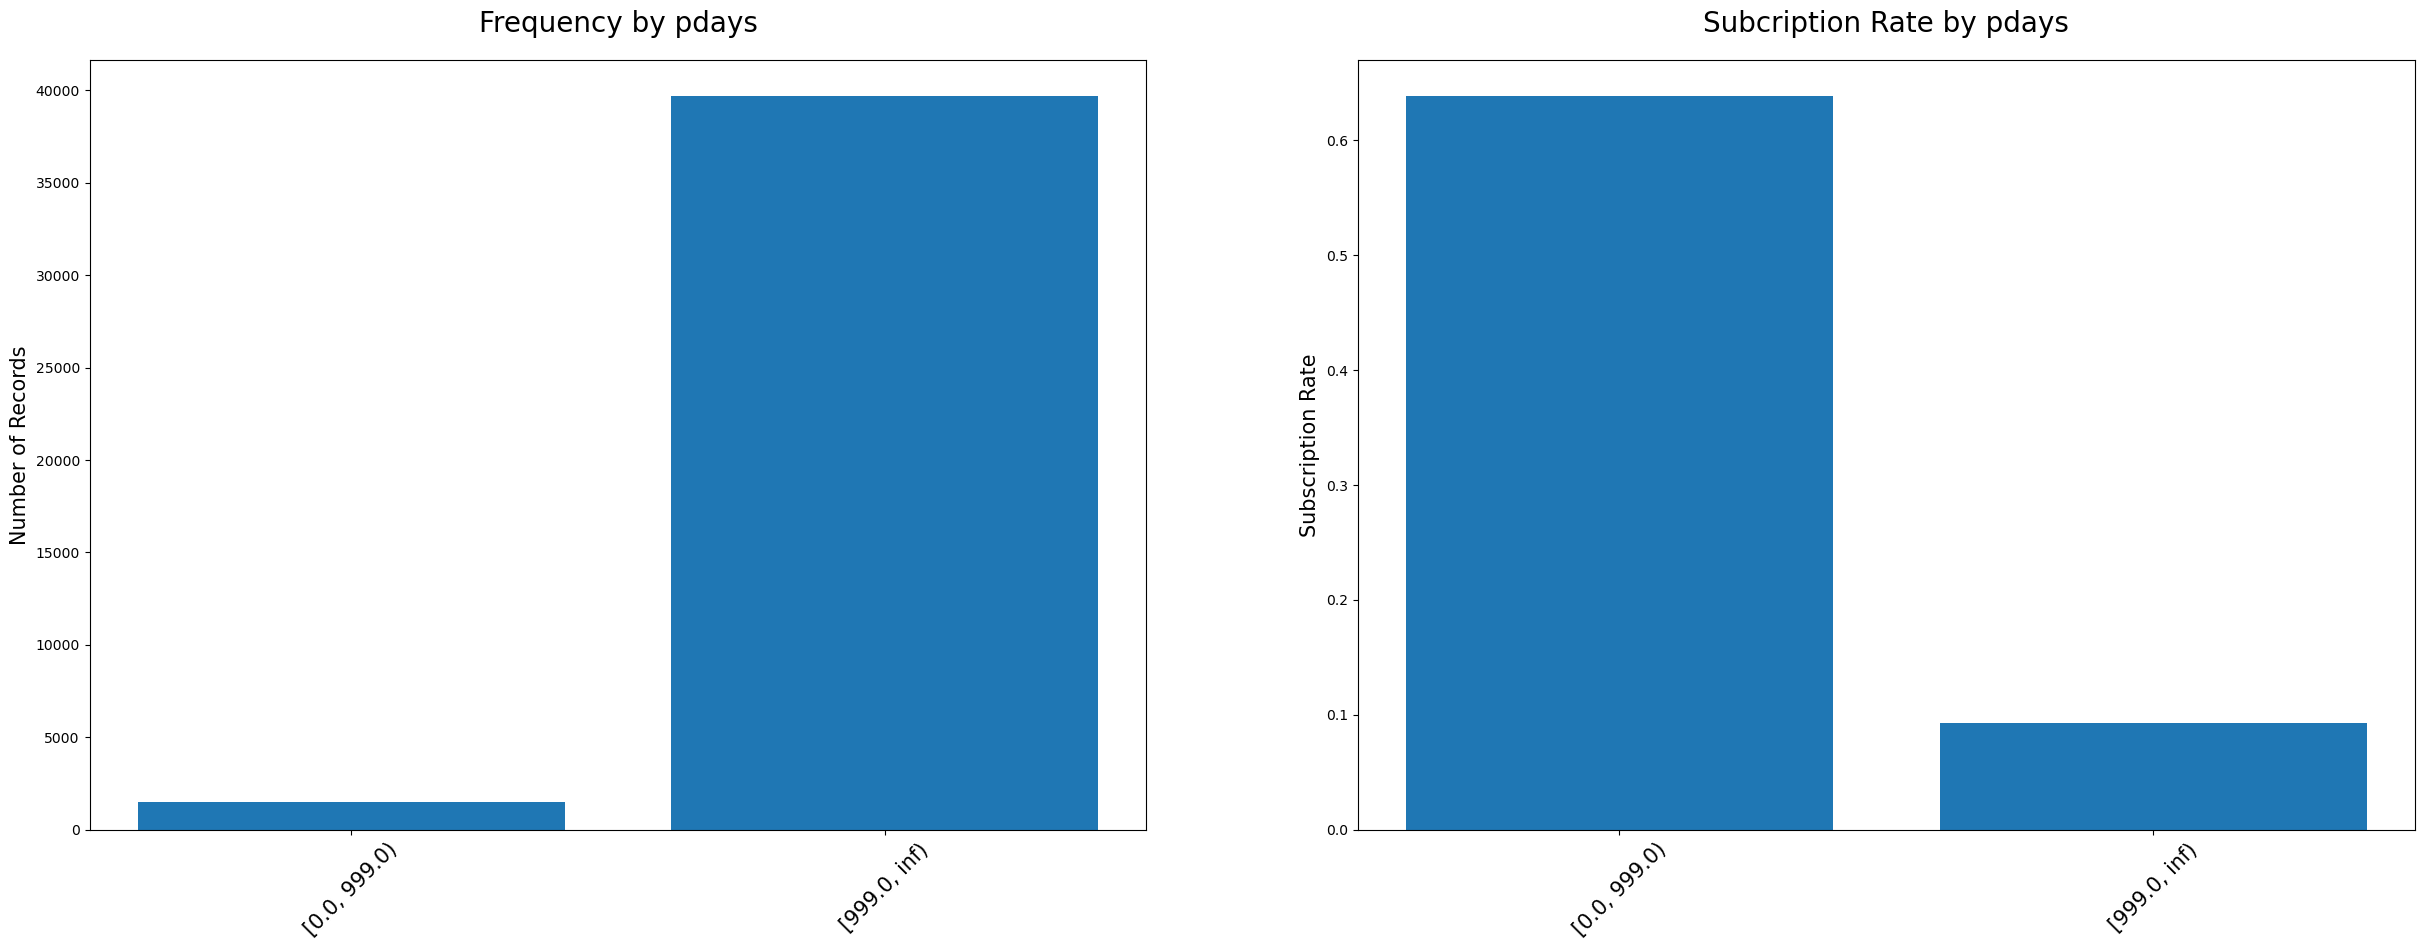

In [41]:
#Generate a distribution of pdays for subscribers and non-subscribers
pdaysBinning = [0,999,float("inf")]
df['pdaysBin'] = pd.cut(x=df['pdays'],right=False,bins = pdaysBinning)


# Get the count of bins for non-responders (y == 0), sort, and rename columns
dfpdaysNonResponder  = (
    df[df['y'] == 0]['pdaysBin'].value_counts()  # Get the value counts 
    .to_frame(name="Perc")                                   # Create a DataFrame with the 'Perc' column
    .sort_index()                                            # Sort by index (the bins)
    .reset_index()                                           # Reset index to turn bins into a column
    .rename(columns={"pdaysBin": "pdays"})                       # Rename columns
)

# Get the count of  bins for responders (y == 1), sort, and rename columns
dfpdaysResponder = (
    df[df['y'] == 1]['pdaysBin'].value_counts()  # Get the value counts 
    .to_frame(name="Perc")                                   # Create a DataFrame with the 'Perc' column
    .sort_index()                                            # Sort by index (the bins)
    .reset_index()                                           # Reset index to turn bins into a column
    .rename(columns={"pdaysBin": "pdays"})                       # Rename columns
)

dfpdaysNonResponder['pdays'] = dfpdaysNonResponder['pdays'].astype(str)
dfpdaysResponder['pdays'] = dfpdaysResponder['pdays'].astype(str)
dfpdays = pd.merge(dfpdaysNonResponder,dfpdaysResponder, on = "pdays").rename(columns = {"Perc_x":"NonResponder","Perc_y":"Responder"})

dfpdays = pd.merge(dfpdaysNonResponder,dfpdaysResponder, on = "pdays").rename(columns = {"Perc_x":"NonResponder","Perc_y":"Responder"})
dfpdays['subscriptionRate'] = dfpdays['Responder']/(dfpdays['Responder'] + dfpdays['NonResponder'])
dfpdays['total'] = (dfpdays['Responder'] + dfpdays['NonResponder'])

fig, ax = plt.subplots(1,2, figsize = (30, 10))
histCatVariablesCount(0,dfpdays.pdays,dfpdays.total,"Frequency by pdays")
histCatVariablesSubscriptionRate(1,dfpdays.pdays,dfpdays.subscriptionRate,"Subcription Rate by pdays")

### Key Takeaways:

* People who have never been contacted (999) since the last campaign are less likely to take the offer, which makes sense. 


### More detailed "previous" analysis

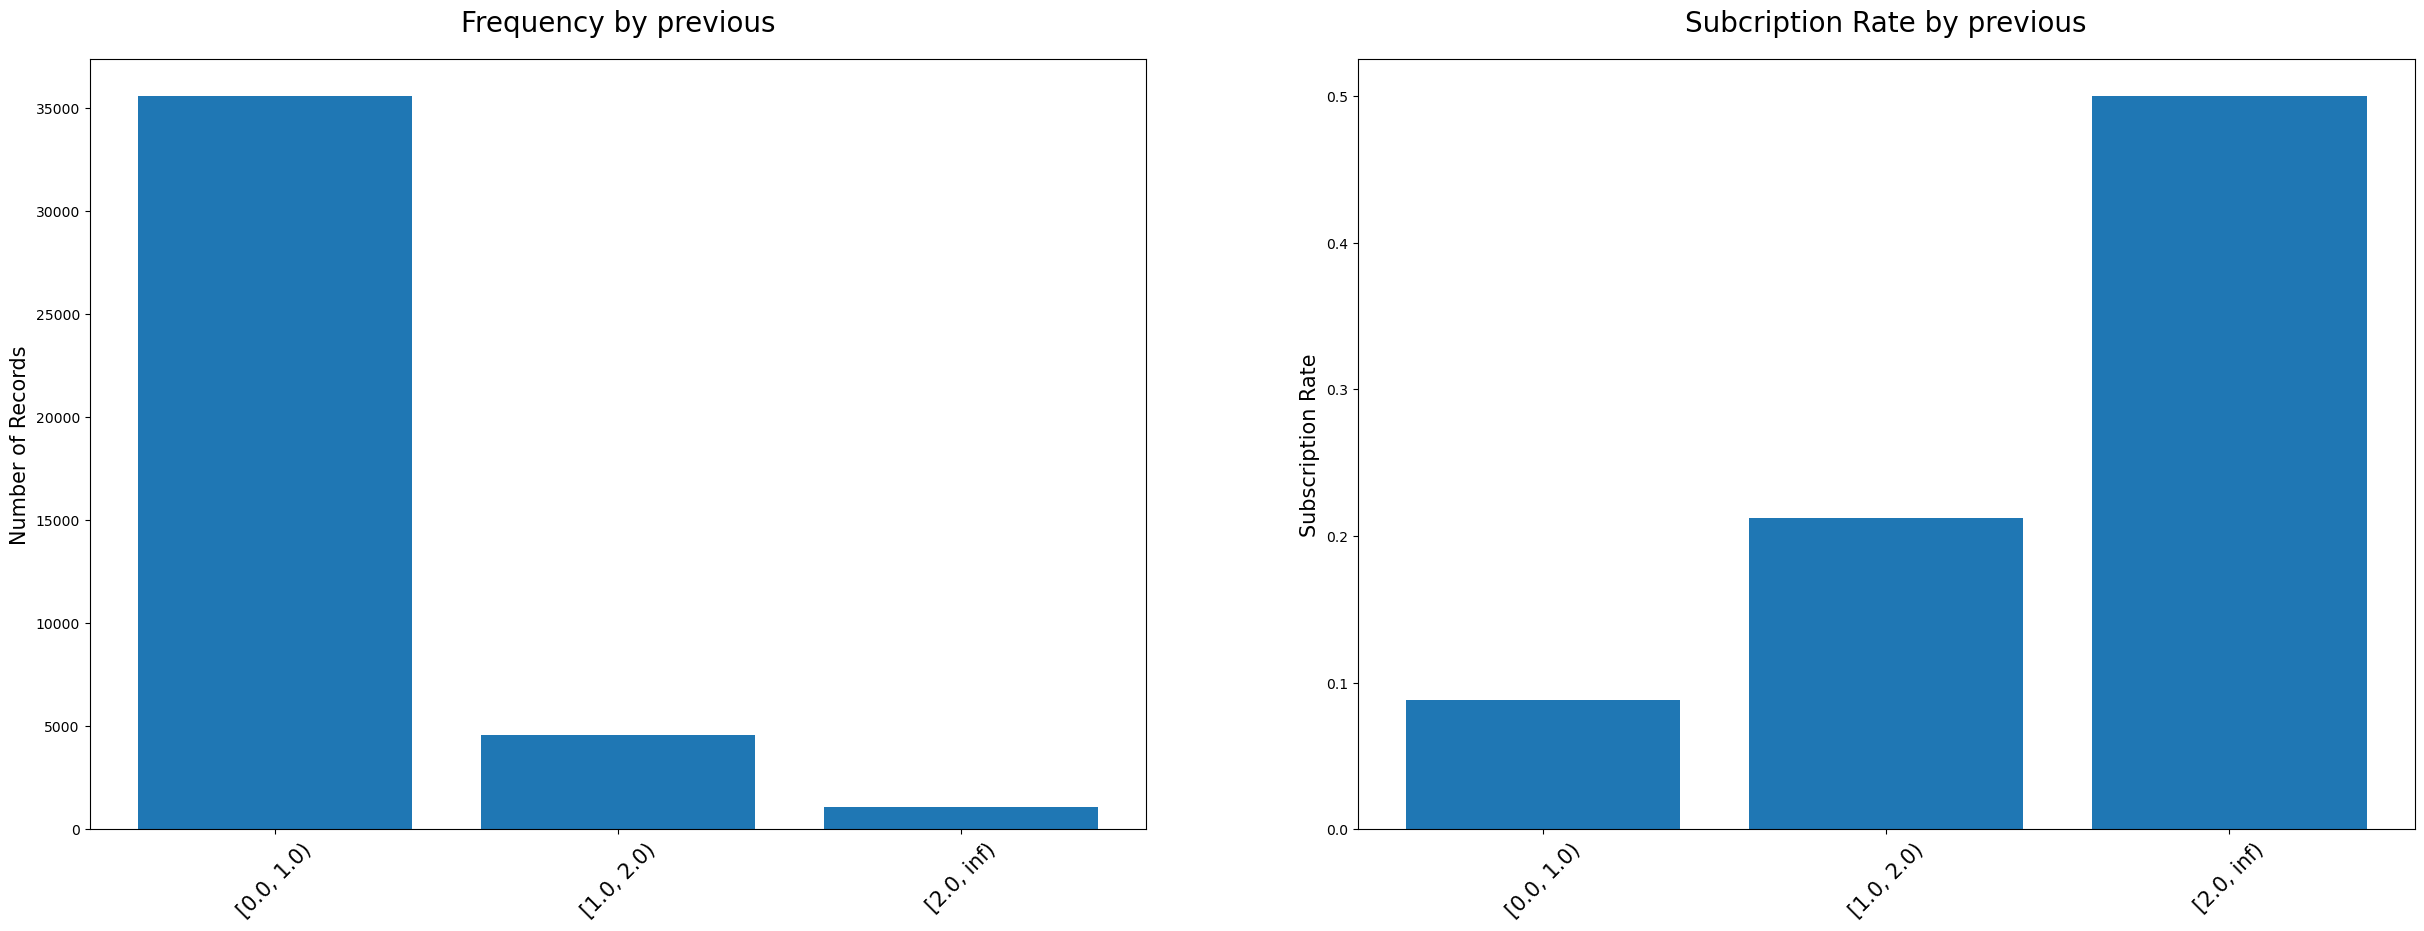

In [42]:
#Generate a distribution of previous for subscribers and non-subscribers
previousBinning = [0,1,2,float("inf")]
df['previousBin'] = pd.cut(x=df['previous'],right=False,bins = previousBinning)

# Get the count of bins for non-responders (y == 0), sort, and rename columns
dfpreviousNonResponder  = (
    df[df['y'] == 0]['previousBin'].value_counts()  # Get the value counts 
    .to_frame(name="Perc")                                   # Create a DataFrame with the 'Perc' column
    .sort_index()                                            # Sort by index (the bins)
    .reset_index()                                           # Reset index to turn bins into a column
    .rename(columns={"previousBin": "previous"})                       # Rename columns
)

# Get the count of  bins for responders (y == 1), sort, and rename columns
dfpreviousResponder = (
    df[df['y'] == 1]['previousBin'].value_counts()  # Get the value counts 
    .to_frame(name="Perc")                                   # Create a DataFrame with the 'Perc' column
    .sort_index()                                            # Sort by index (the bins)
    .reset_index()                                           # Reset index to turn bins into a column
    .rename(columns={"previousBin": "previous"})                       # Rename columns
)


dfpreviousNonResponder['previous'] = dfpreviousNonResponder['previous'].astype(str)
dfpreviousResponder['previous'] = dfpreviousResponder['previous'].astype(str)
dfprevious = pd.merge(dfpreviousNonResponder,dfpreviousResponder, on = "previous").rename(columns = {"Perc_x":"NonResponder","Perc_y":"Responder"})

dfprevious = pd.merge(dfpreviousNonResponder,dfpreviousResponder, on = "previous").rename(columns = {"Perc_x":"NonResponder","Perc_y":"Responder"})
dfprevious['subscriptionRate'] = dfprevious['Responder']/(dfprevious['Responder'] + dfprevious['NonResponder'])
dfprevious['total'] = (dfprevious['Responder'] + dfprevious['NonResponder'])

fig, ax = plt.subplots(1,2, figsize = (30, 10))
histCatVariablesCount(0,dfprevious.previous,dfprevious.total,"Frequency by previous")
histCatVariablesSubscriptionRate(1,dfprevious.previous,dfprevious.subscriptionRate,"Subcription Rate by previous")


### Key Takeaways:

* People who have never been contacted before are less likely to take up the offer.

In [43]:
#Remove all the binned variables as they are not needed for model development
df = df.loc[:,~df.columns.str.endswith('Bin')]
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'y'],
      dtype='object')

### Analyze economic variables

In [44]:
#Get the list of variables
listColumns = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m','nr.employed']

In [45]:
#Review the correlation between the variables and the target variable
df[listColumns + ['y']].corr()


,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
emp.var.rate,1.000000,0.775334,0.196041,0.972245,0.906970,-0.298334
cons.price.idx,0.775334,1.000000,0.058986,0.688230,0.522034,-0.136211
cons.conf.idx,0.196041,0.058986,1.000000,0.277686,0.100513,0.054878
euribor3m,0.972245,0.688230,0.277686,1.000000,0.945154,-0.307771
nr.employed,0.906970,0.522034,0.100513,0.945154,1.000000,-0.354678
y,-0.298334,-0.136211,0.054878,-0.307771,-0.354678,1.000000


### Key Takeaways:

* There is correlation between ecomonic uncertainty and subscrition rate, as the economic climate tends to impact spending.
* The "employment variation rate", "number of people employed" and "euribor3m" are highly correlated. I will drop "number employed" and "euribor3m". 

### More detailed "Employment Variation Rate" analysis

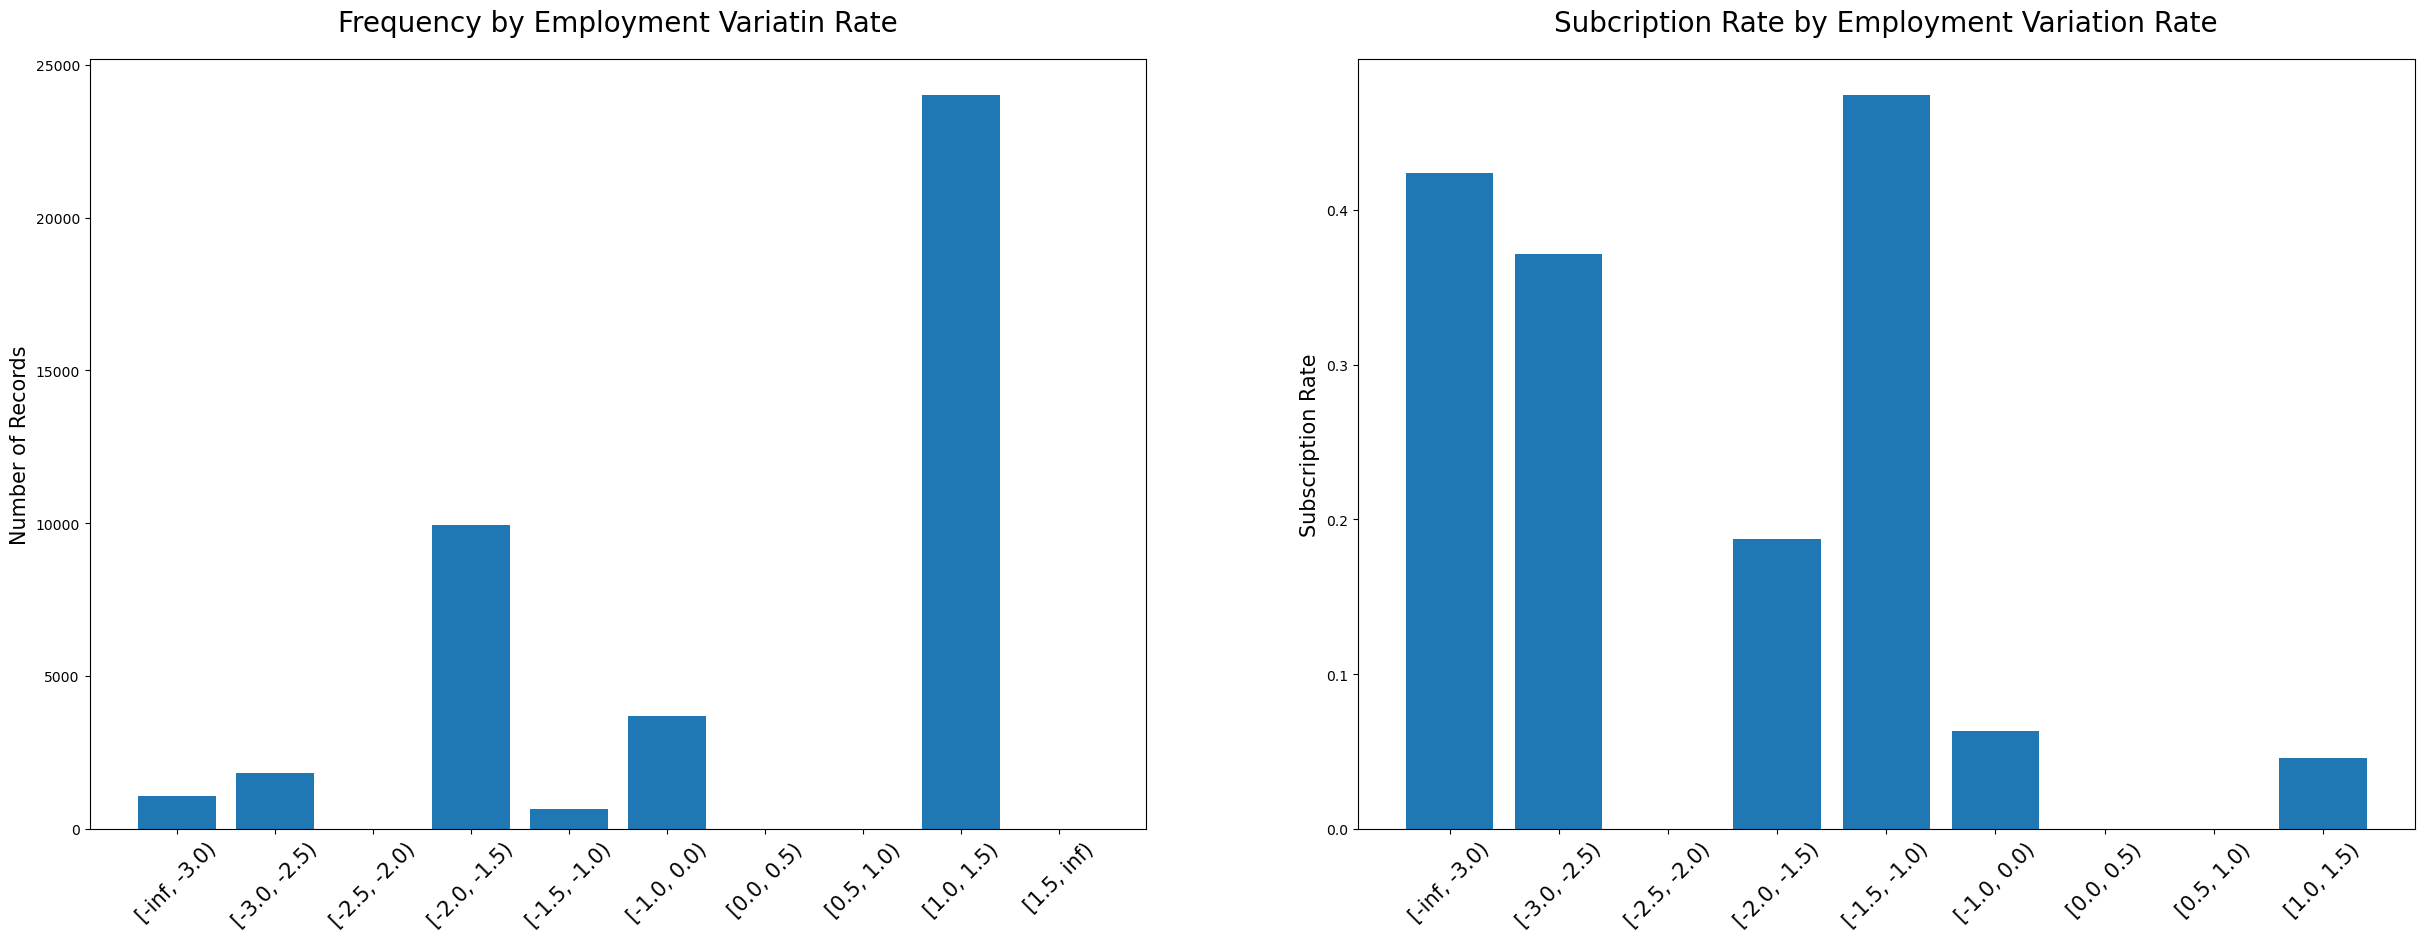

In [46]:
#Generate a distribution of emp.var.rate for subscribers and non-subscribers
empVarRateBinning = [-float("inf"), -3.0,-2.5,-2.0,-1.5,-1.0,0,0.5,1.0,1.5,float("inf")]
df['empVarRateBin'] = pd.cut(x=df['emp.var.rate'],right=False,bins = empVarRateBinning)

# Get the count of bins for non-responders (y == 0), sort, and rename columns
dfempVarRateNonResponder  = (
    df[df['y'] == 0]['empVarRateBin'].value_counts()  # Get the value counts 
    .to_frame(name="Perc")                                   # Create a DataFrame with the 'Perc' column
    .sort_index()                                            # Sort by index (the bins)
    .reset_index()                                           # Reset index to turn bins into a column
    .rename(columns={"empVarRateBin": "empVarRate"})                       # Rename columns
)

# Get the count of  bins for responders (y == 1), sort, and rename columns
dfempVarRateResponder = (
    df[df['y'] == 1]['empVarRateBin'].value_counts()  # Get the value counts 
    .to_frame(name="Perc")                                   # Create a DataFrame with the 'Perc' column
    .sort_index()                                            # Sort by index (the bins)
    .reset_index()                                           # Reset index to turn bins into a column
    .rename(columns={"empVarRateBin": "empVarRate"})                       # Rename columns
)


dfempVarRateNonResponder['empVarRate'] = dfempVarRateNonResponder['empVarRate'].astype(str)
dfempVarRateResponder['empVarRate'] = dfempVarRateResponder['empVarRate'].astype(str)
dfempVarRate = pd.merge(dfempVarRateNonResponder,dfempVarRateResponder, on = "empVarRate").rename(columns = {"Perc_x":"NonResponder","Perc_y":"Responder"})
dfempVarRate['subscriptionRate'] = dfempVarRate['Responder']/(dfempVarRate['Responder'] + dfempVarRate['NonResponder'])
dfempVarRate['total'] = (dfempVarRate['Responder'] + dfempVarRate['NonResponder'])

fig, ax = plt.subplots(1,2, figsize = (30, 10))
histCatVariablesCount(0,dfempVarRate.empVarRate,dfempVarRate.total,"Frequency by Employment Variatin Rate")
histCatVariablesSubscriptionRate(1,dfempVarRate.empVarRate,dfempVarRate.subscriptionRate,"Subcription Rate by Employment Variation Rate")


### Key Takeaways:

* The subscription rate drops for higher employment varation rates.

### More detailed "consumer price index" analysis

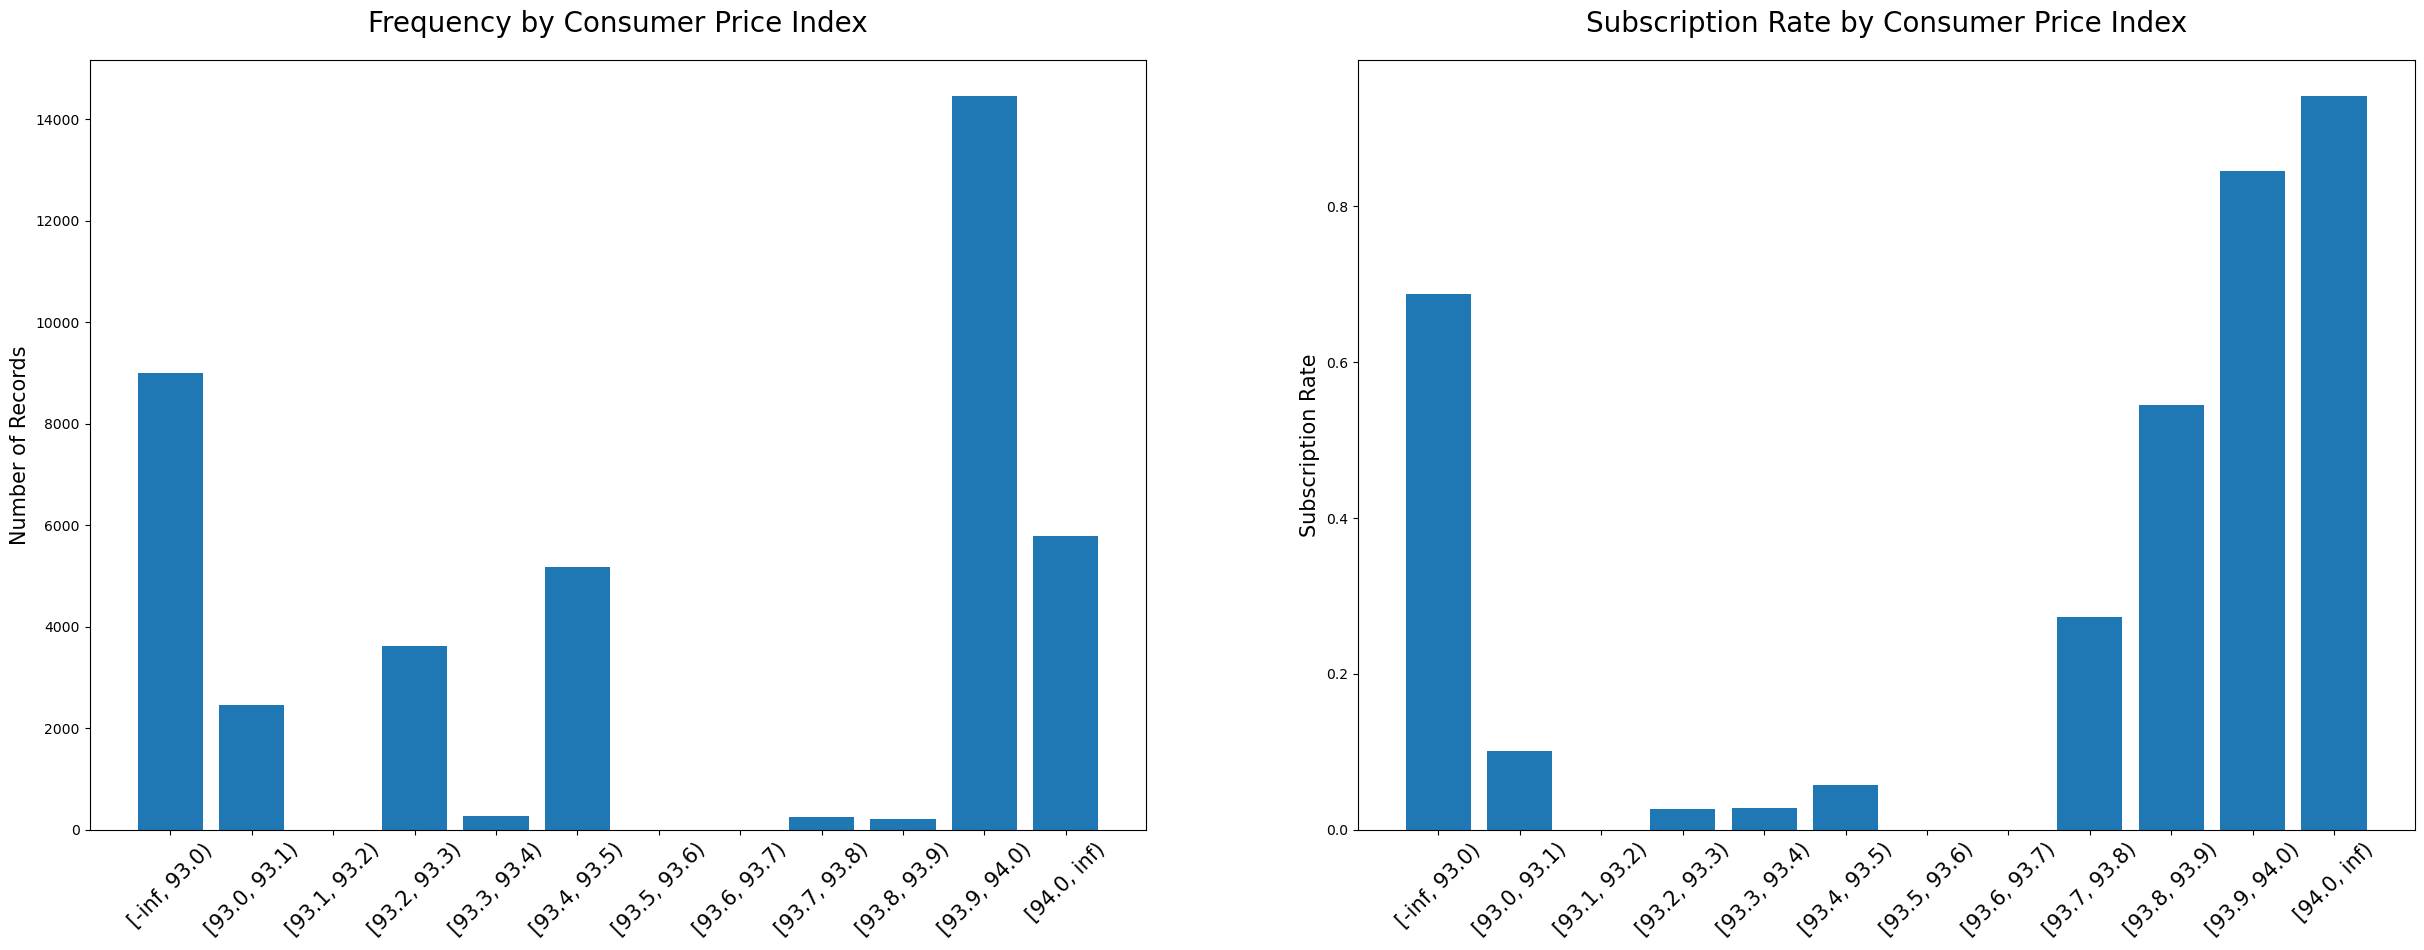

In [47]:
#Generate a distribution of consumer price index for subscribers and non-subscribers
priceBinning = [-float("inf"),93,93.1, 93.2, 93.3, 93.4, 93.5, 93.6, 93.7, 93.8, 93.9, 94,float("inf")]
df['priceIndexBin'] = pd.cut(x=df['cons.price.idx'],right=False,bins = priceBinning)

# Get the count of bins for non-responders (y == 0), sort, and rename columns
dfPriceIndexNonResponder  = (
    df[df['y'] == 0]['priceIndexBin'].value_counts()  # Get the value counts 
    .to_frame(name="Perc")                                   # Create a DataFrame with the 'Perc' column
    .sort_index()                                            # Sort by index (the bins)
    .reset_index()                                           # Reset index to turn bins into a column
    .rename(columns={"priceIndexBin": "priceIndex"})                       # Rename columns
)

# Get the count of  bins for responders (y == 1), sort, and rename columns
dfPriceIndexResponder = (
    df[df['y'] == 1]['priceIndexBin'].value_counts()  # Get the value counts 
    .to_frame(name="Perc")                                   # Create a DataFrame with the 'Perc' column
    .sort_index()                                            # Sort by index (the bins)
    .reset_index()                                           # Reset index to turn bins into a column
    .rename(columns={"priceIndexBin": "priceIndex"})                       # Rename columns
)

dfPriceIndexNonResponder['priceIndex'] = dfPriceIndexNonResponder['priceIndex'].astype(str)
dfPriceIndexResponder['priceIndex'] = dfPriceIndexResponder['priceIndex'].astype(str)
dfPriceIndex = pd.merge(dfPriceIndexNonResponder,dfPriceIndexResponder, on = "priceIndex").rename(columns = {"Perc_x":"NonResponder","Perc_y":"Responder"})
dfPriceIndex['subscriptionRate'] = dfPriceIndex['Responder']/(dfPriceIndex['Responder'] + dfAge['NonResponder'])
dfPriceIndex['total'] = (dfPriceIndex['Responder'] + dfPriceIndex['NonResponder'])

fig, ax = plt.subplots(1,2, figsize = (30, 10))
histCatVariablesCount(0,dfPriceIndex.priceIndex,dfPriceIndex.total,"Frequency by Consumer Price Index")
histCatVariablesSubscriptionRate(1,dfPriceIndex.priceIndex,dfPriceIndex.subscriptionRate,"Subscription Rate by Consumer Price Index")

### Key Takeaways:

* Change in consumer price index indicates inflation. It is not obvious to me why the subscription rate the highest when the prices go up. There is a potential issue with this variable.

### More detailed "consumer confidence index" analysis

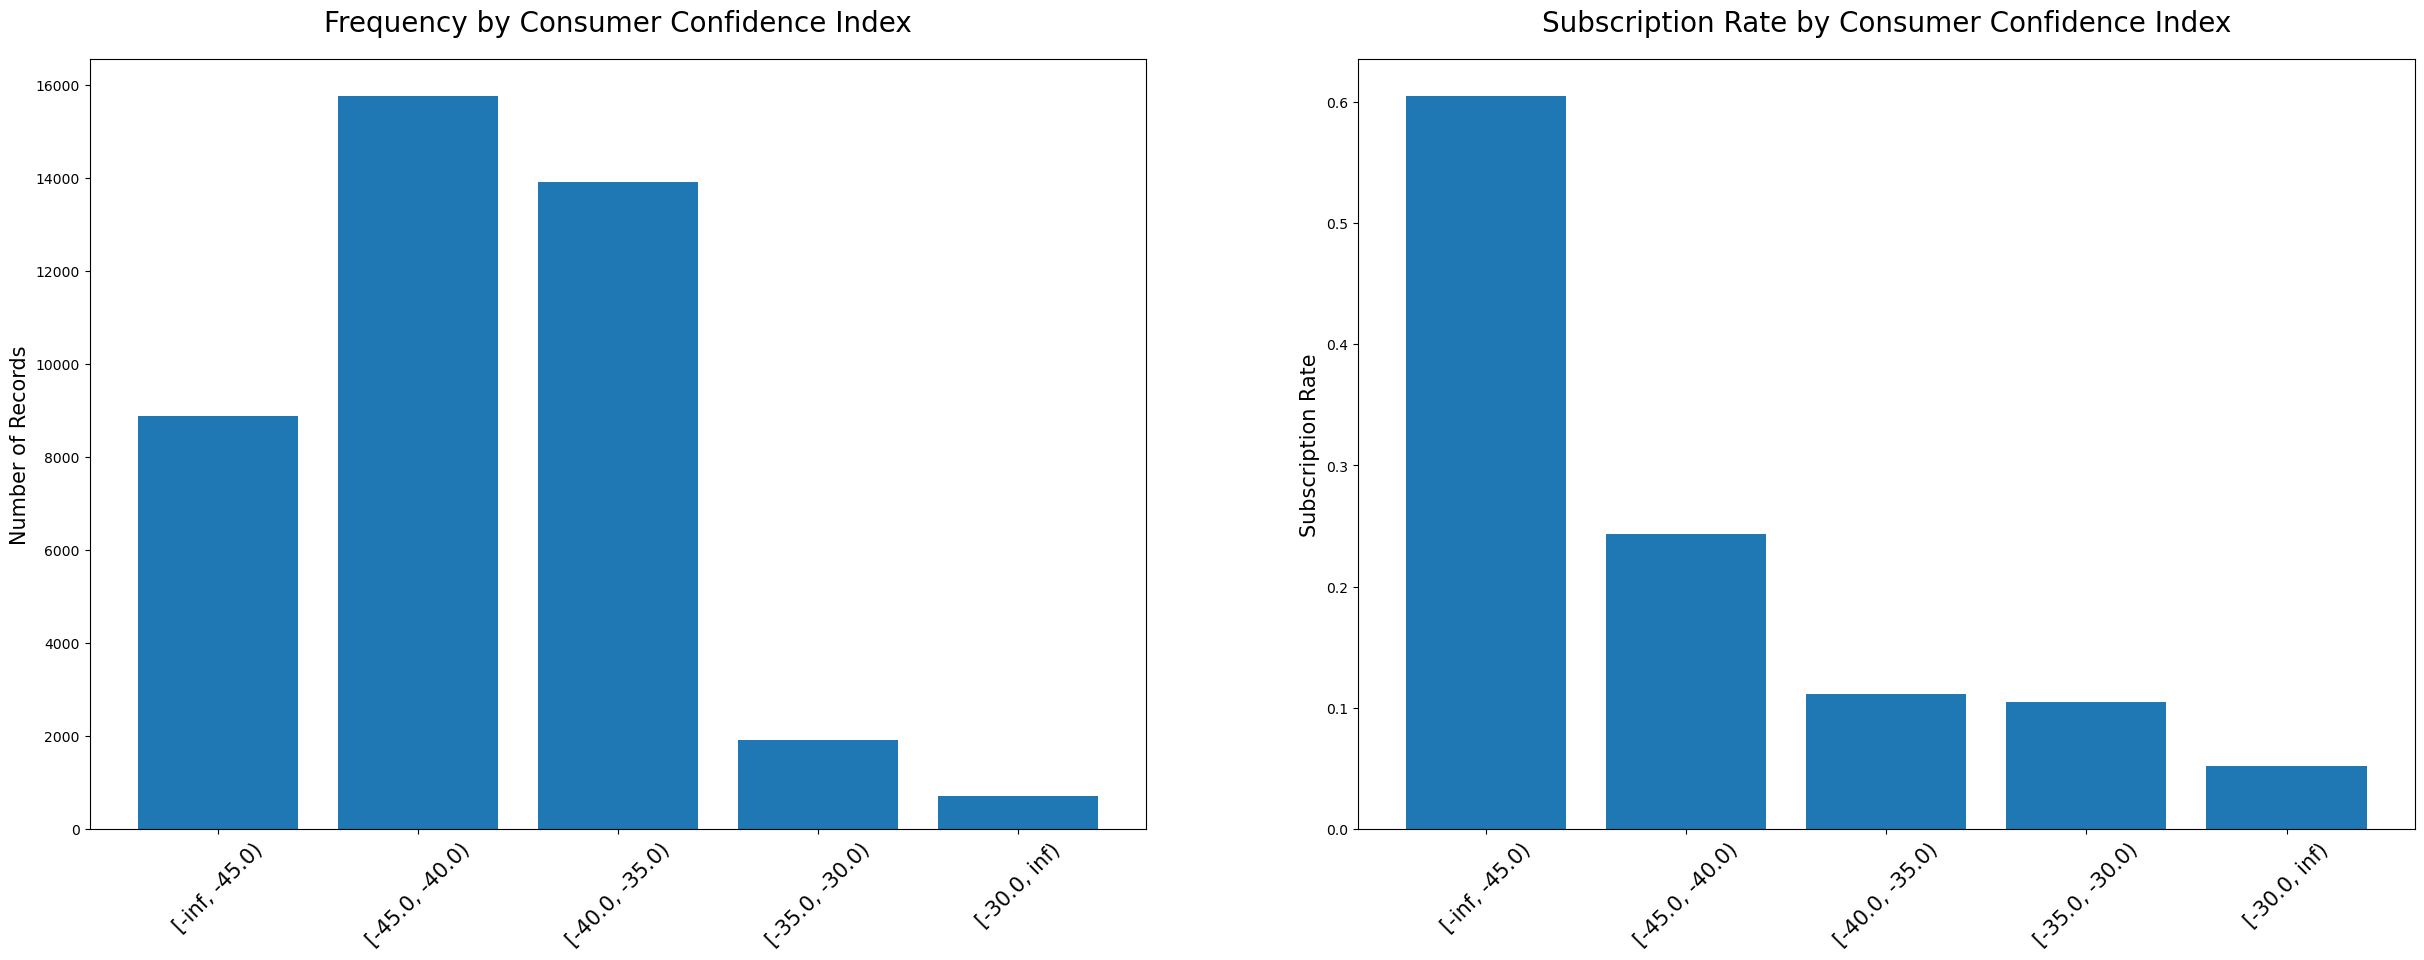

In [48]:
#Generate a distribution of consumer confidence index for subscribers and non-subscribers
confidenceBinning = [-float("inf"),-45,-40,-35,-30,float("inf")]
df['confidenceIndexBin'] = pd.cut(x=df['cons.conf.idx'],right=False,bins = confidenceBinning)


# Get the count of bins for non-responders (y == 0), sort, and rename columns
dfconfidenceIndexNonResponder  = (
    df[df['y'] == 0]['confidenceIndexBin'].value_counts()  # Get the value counts 
    .to_frame(name="Perc")                                   # Create a DataFrame with the 'Perc' column
    .sort_index()                                            # Sort by index (the bins)
    .reset_index()                                           # Reset index to turn bins into a column
    .rename(columns={"confidenceIndexBin": "confidenceIndex"})                       # Rename columns
)

# Get the count of  bins for responders (y == 1), sort, and rename columns
dfconfidenceIndexResponder = (
    df[df['y'] == 1]['confidenceIndexBin'].value_counts()  # Get the value counts 
    .to_frame(name="Perc")                                   # Create a DataFrame with the 'Perc' column
    .sort_index()                                            # Sort by index (the bins)
    .reset_index()                                           # Reset index to turn bins into a column
    .rename(columns={"confidenceIndexBin": "confidenceIndex"})                       # Rename columns
)

dfconfidenceIndexNonResponder['confidenceIndex'] = dfconfidenceIndexNonResponder['confidenceIndex'].astype(str)
dfconfidenceIndexResponder['confidenceIndex'] = dfconfidenceIndexResponder['confidenceIndex'].astype(str)
dfconfidenceIndex = pd.merge(dfconfidenceIndexNonResponder,dfconfidenceIndexResponder, on = "confidenceIndex").rename(columns = {"Perc_x":"NonResponder","Perc_y":"Responder"})
dfconfidenceIndex['subscriptionRate'] = dfconfidenceIndex['Responder']/(dfconfidenceIndex['Responder'] + dfAge['NonResponder'])
dfconfidenceIndex['total'] = (dfconfidenceIndex['Responder'] + dfconfidenceIndex['NonResponder'])

fig, ax = plt.subplots(1,2, figsize = (30, 10))
histCatVariablesCount(0,dfconfidenceIndex.confidenceIndex,dfconfidenceIndex.total,"Frequency by Consumer Confidence Index")
histCatVariablesSubscriptionRate(1,dfconfidenceIndex.confidenceIndex,dfconfidenceIndex.subscriptionRate,"Subscription Rate by Consumer Confidence Index")

### Key Takeaways:

* As the (negative) consumer confidence index increases, the subscription rate drops..

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

* The primary objective of the task is to predict whether the prospect will subscribe to the service based on the observed characteristics of the prospect. In other words, we were trying to uncover the attributes which differentiate subscribers and non-subscribers. 


### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

#### Based on the analysis above, here are the feature engineering steps for bank information features:

|Variable | Action | Description | 
| :--- | :---- | :---| 
|age| Use as is| 
| job | Group and hot encode | Group {blue-collar, technician, housemaid}, {admin., services}, {management, entrepreneur} | 
| marital | Label encode  | married -> 0, divorced -> 1, single -> 2, unknown -> 2| 
| education | Label encode  | illiterate -> 0,unknown -> 0,basic.4y -> 1,basic.6y -> 2,basic.9y -> 3, high.school -> 4, professional.course -> 5, university.degree -> 6| 
| default | Label encode  |unknown -> 0, yes -> 0, no -> 1| 
|housing | Drop| 
|loan | Drop|

In [49]:
#Create a dataframe with only the variables related with the bank client data and the target
dfBank = df[['age','job','marital','education','default','housing','loan','y']]
dfBank.head()
dfBank.shape

,age,job,marital,education,default,housing,loan,y
0,56,housemaid,married,basic.4y,no,no,no,0
1,57,services,married,high.school,unknown,no,no,0
2,37,services,married,high.school,no,yes,no,0
3,40,admin.,married,basic.6y,no,no,no,0
4,56,services,married,high.school,no,no,yes,0


(41188, 8)

In [50]:
#Group 'job'
job_dict = {'blue-collar':'blue-collar', 'housemaid':'blue-collar','technician':'blue-collar',
              'admin.':'services','services':'services',
              'management':'management','entrepreneur':'management',
              'retired':'retired', 'student':'student','unemployed':'unemployed',
              'self-employed':'self-employed', 'unknown':'unknown'}
dfBank['jobGrouped'] =  dfBank['job'].map(job_dict)

#Review the mapping 
dfBank['job'].value_counts().sort_values()
dfBank['jobGrouped'].value_counts().sort_values()

job
unknown            330
student            875
unemployed        1014
housemaid         1060
self-employed     1421
entrepreneur      1456
retired           1720
management        2924
services          3969
technician        6743
blue-collar       9254
admin.           10422
Name: count, dtype: int64

jobGrouped
unknown            330
student            875
unemployed        1014
self-employed     1421
retired           1720
management        4380
services         14391
blue-collar      17057
Name: count, dtype: int64

In [51]:
#Hot encode 'job'
dfJob = pd.get_dummies(dfBank['jobGrouped'],drop_first = True)
dfBank = dfBank.join(dfJob)

In [52]:
#Label encode 'marital'
marital_dict = {'married':0, 'divorced':1, 'single':2, 'unknown':2}

dfBank['maritalGrouped'] = dfBank['marital'].map(marital_dict)

#Review the mapping 
dfBank['marital'].value_counts().sort_values()
dfBank['maritalGrouped'].value_counts().sort_values()

marital
unknown        80
divorced     4612
single      11568
married     24928
Name: count, dtype: int64

maritalGrouped
1     4612
2    11648
0    24928
Name: count, dtype: int64

In [53]:
#Label encode 'education'
education_dict = {'illiterate':0,'unknown':0,'basic.4y':1, 'basic.6y':2, 'basic.9y':3, 'high.school':4, 'professional.course':5, 'university.degree':6}

dfBank['educationGrouped'] = dfBank['education'].map(education_dict)

#Review the mapping 
dfBank['education'].value_counts().sort_values()
dfBank['educationGrouped'].value_counts().sort_values()

education
illiterate                18
unknown                 1731
basic.6y                2292
basic.4y                4176
professional.course     5243
basic.9y                6045
high.school             9515
university.degree      12168
Name: count, dtype: int64

educationGrouped
0     1749
2     2292
1     4176
5     5243
3     6045
4     9515
6    12168
Name: count, dtype: int64

In [54]:
#Label encode 'default'
default_dict = {'no':1,'unknown':0,'yes':0}

dfBank['defaultGrouped'] = dfBank['default'].map(default_dict)

#Review the mapping 
dfBank['default'].value_counts().sort_values()
dfBank['defaultGrouped'].value_counts().sort_values()

default
yes            3
unknown     8597
no         32588
Name: count, dtype: int64

defaultGrouped
0     8600
1    32588
Name: count, dtype: int64

In [55]:
#Drop 'housing' and 'loan'
dfBank = dfBank.drop(columns = ['housing','loan'])

#Drop processed variables and keep the labeled versions
dfBank = dfBank.drop(columns = ['job','marital','education','default','jobGrouped'])

In [56]:
dfBank.head()

,age,y,management,retired,self-employed,services,student,unemployed,unknown,maritalGrouped,educationGrouped,defaultGrouped
0,56,0,False,False,False,False,False,False,False,0,1,1
1,57,0,False,False,False,True,False,False,False,0,4,0
2,37,0,False,False,False,True,False,False,False,0,4,1
3,40,0,False,False,False,True,False,False,False,0,2,1
4,56,0,False,False,False,True,False,False,False,0,4,1


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [57]:
#Create a train, test value. Use the default test_size of 30%. We will also create stratified samples.
X_train, X_test, y_train, y_test = train_test_split(dfBank.drop(columns = ['y']),dfBank['y'], test_size=0.3,random_state = 42, stratify = dfBank['y'])


In [58]:
#Confirm the stratification on 'y'
y_train.value_counts(normalize=True)
y_test.value_counts(normalize=True)

y
0    0.887343
1    0.112657
Name: proportion, dtype: float64

y
0    0.887351
1    0.112649
Name: proportion, dtype: float64

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

* The baseline would be a model which returns the most frequent class - "Not subscribed". The model will be correct in 88.7% of cases, as this is the non-subscrition rate. 

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [59]:
#Scale all the variables
transformer = make_column_transformer((StandardScaler(), list(X_train.columns)),
                                      remainder = 'passthrough' )


In [60]:
#Build a logistic regression pipeline
lgrPipe = Pipeline([('transformer',transformer),
                     ('lgr',LogisticRegression(random_state = 42))]).fit(X_train,y_train)

y_train_predicted = lgrPipe.predict(X_train)
y_test_predicted = lgrPipe.predict(X_test)

y_train_predicted_proba = lgrPipe.predict_proba(X_train)
y_test_predicted_proba = lgrPipe.predict_proba(X_test)

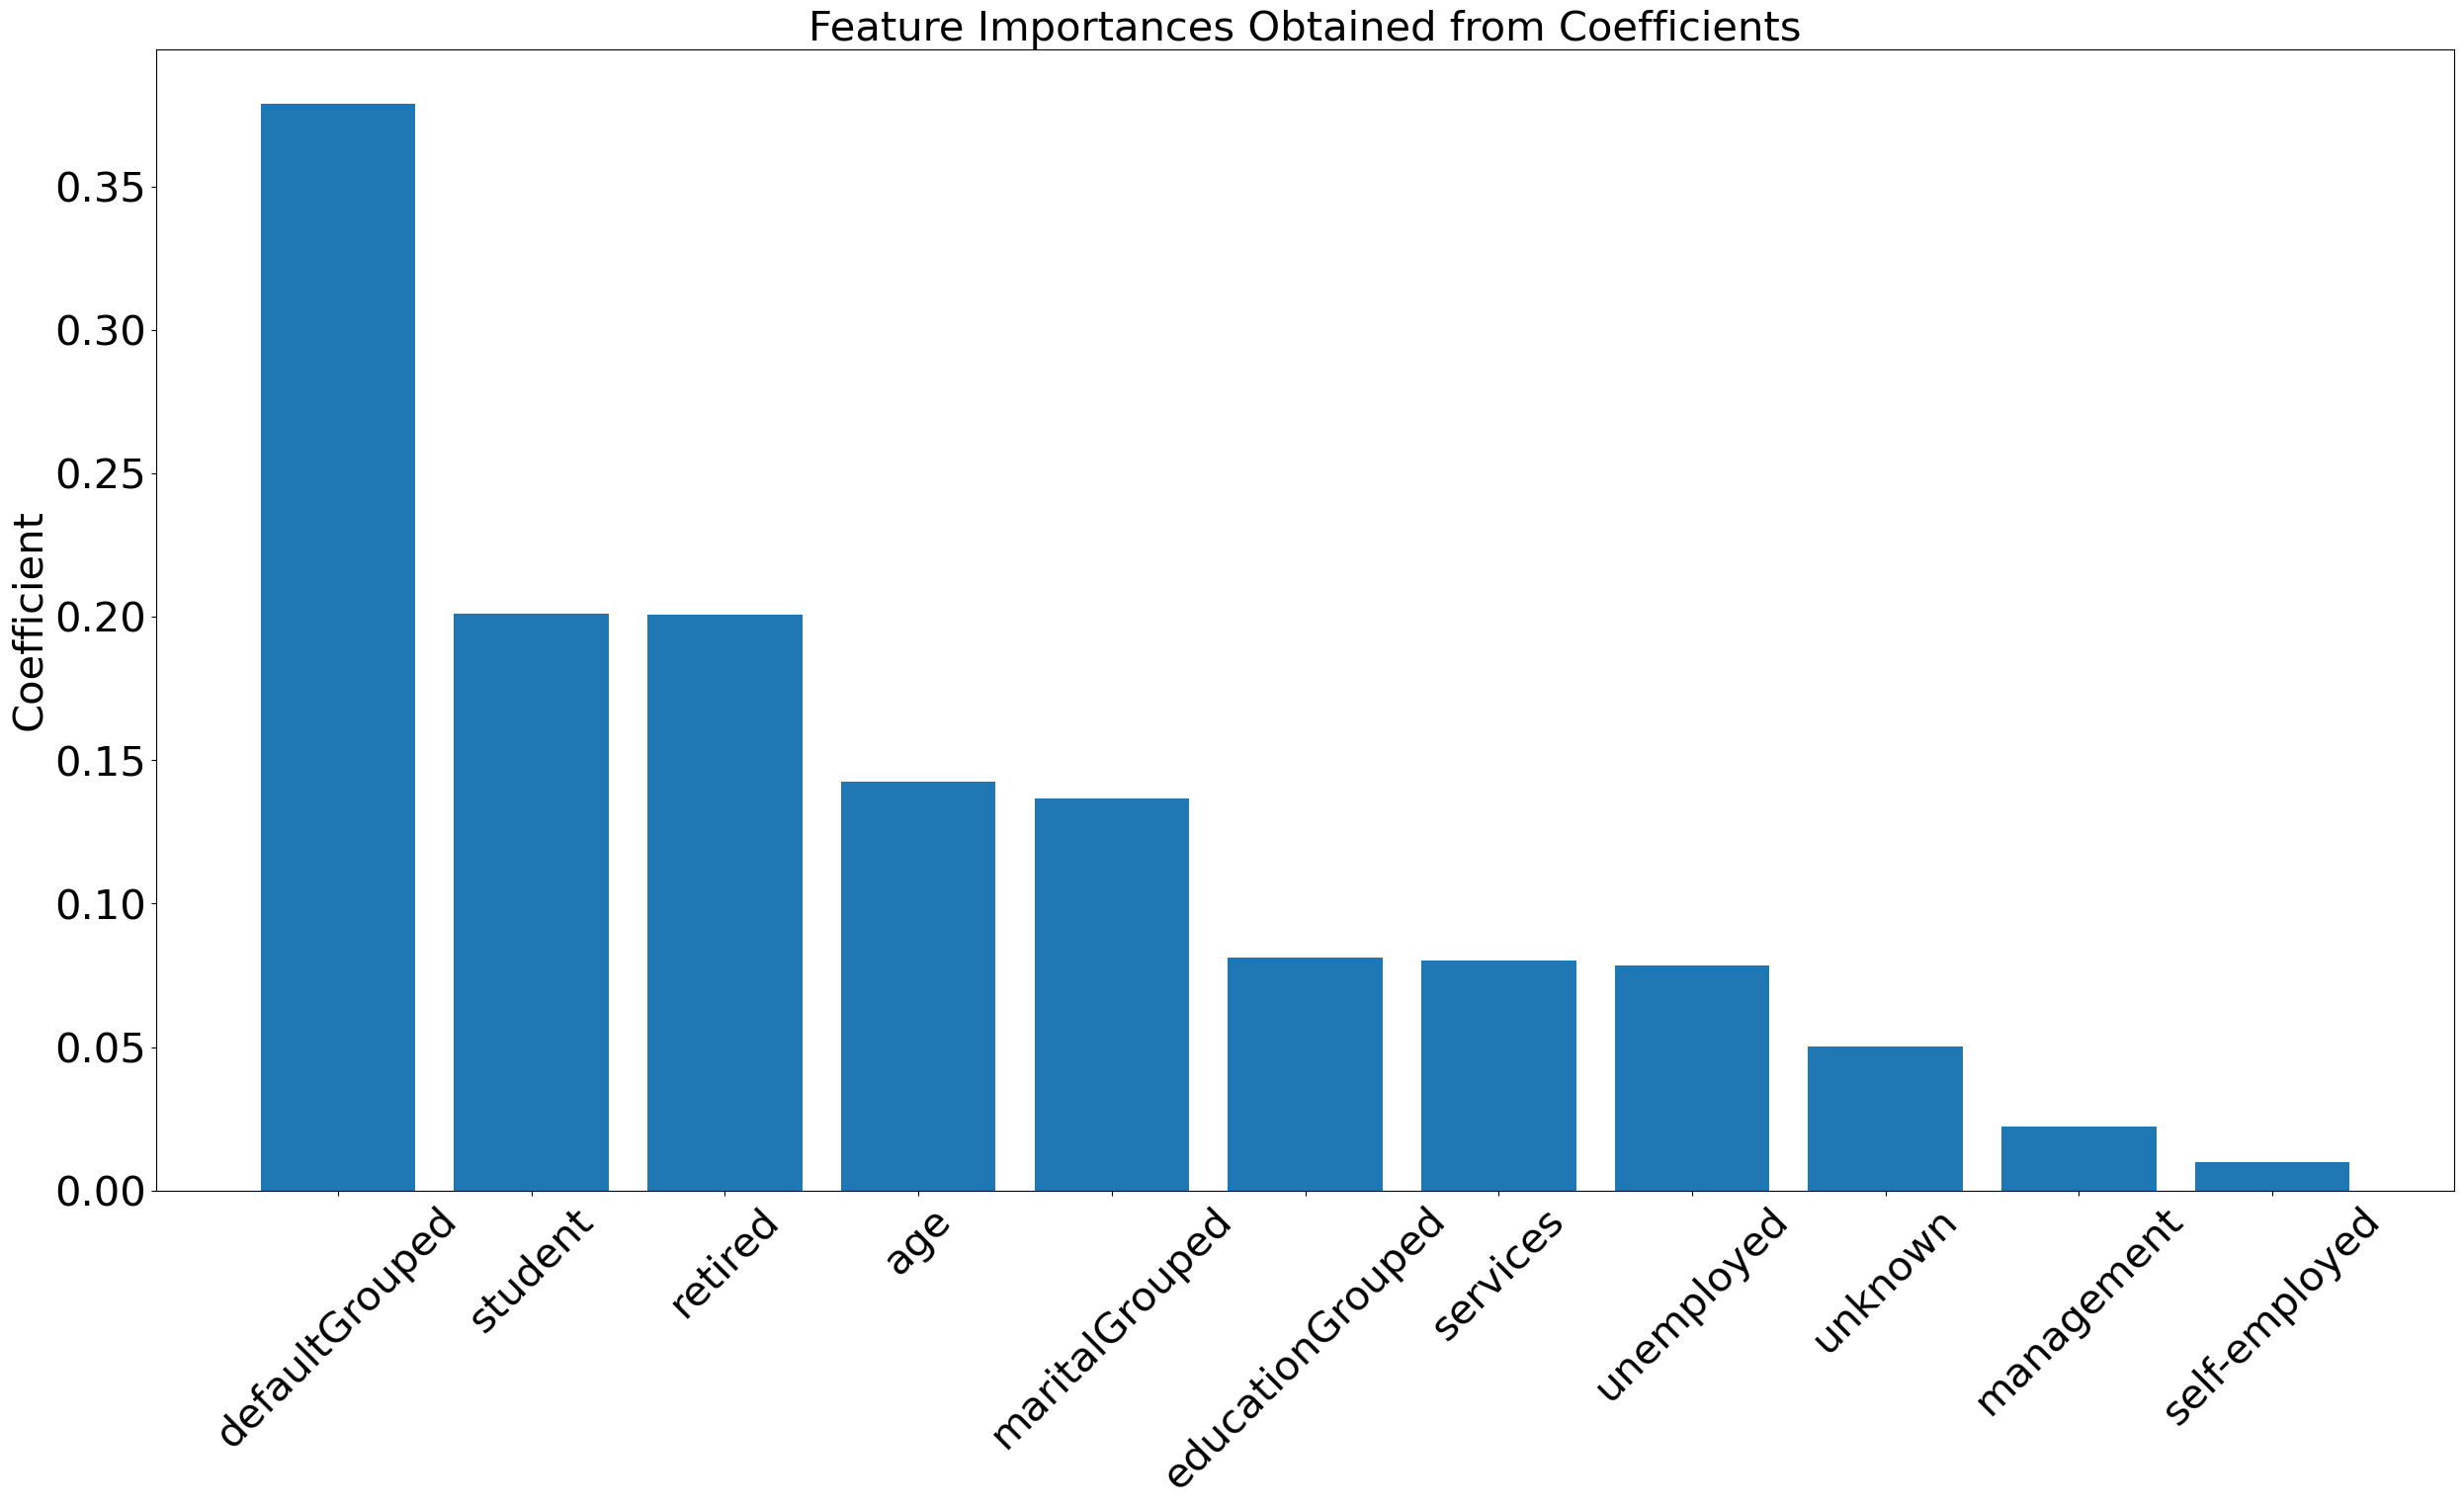

In [61]:
# Feature importance
importances = pd.DataFrame(data={
    'Feature': X_train.columns,
    'Importance': lgrPipe.named_steps["lgr"].coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

fig, ax = plt.subplots(1, figsize = (30, 15))
ax.bar(x=importances['Feature'], height=importances['Importance'])
ax.set_title('Feature Importances Obtained from Coefficients', size = 30)
ax.set_ylabel('Coefficient', fontsize = 30)
ax.tick_params(axis = 'x',labelrotation=45, labelsize=30)
ax.tick_params(axis = 'y', labelsize=30)
plt.show();

Based on this model, the following prospects are likely to accept the offer:
* Prospects without defaults
* Students and retired  
* Older prospects
* Single prospects
* Highly educated prospects

### Problem 9: Score the Model

What is the accuracy of your model?

In [62]:
accTrain = np.round(accuracy_score(y_train, y_train_predicted),3)
accTest = np.round(accuracy_score(y_test, y_test_predicted),3)

print("The accuracy for the train sample is {:.3f}".format(accTrain)+".")
print("The accuracy for the test sample is {:.3f}".format(accTest)+".")

The accuracy for the train sample is 0.887.
The accuracy for the test sample is 0.887.


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [63]:
#Build K-Nearest Neighbor, logistic regression, decision classifier and SVN models with default parameters
modelList = [KNeighborsClassifier(),
             LogisticRegression(random_state = 42),
             DecisionTreeClassifier(random_state = 42),
             SVC(random_state = 42)]

In [64]:
#Train K-Nearest Neighbor, logistic regression, decision classifier and SVN models with default parameters
runTime = []
accuracyScoreTrain = []
accuracyScoreTest = []

precisionScoreTrain = []
precisionScoreTest = []

recallScoreTrain = []
recallScoreTest = []

f1ScoreTrain = []
f1ScoreTest = []


for i in range(len(modelList)):
    t1 = timeit.default_timer()
    modelPipe = Pipeline([('transformer',transformer),
                     ('model',modelList[i])]).fit(X_train,y_train)
    t2 = timeit.default_timer()
    runTime.append(np.round((t2-t1),2))
    
    y_train_predicted = modelPipe.predict(X_train)
    y_test_predicted = modelPipe.predict(X_test)
    
    accuracyScoreTrain.append(np.round(accuracy_score(y_train, y_train_predicted),3))
    accuracyScoreTest.append(np.round(accuracy_score(y_test, y_test_predicted),3))
    
    precisionScoreTrain.append(np.round(precision_score(y_train, y_train_predicted),3))
    precisionScoreTest.append(np.round(precision_score(y_test, y_test_predicted),3))
    
    recallScoreTrain.append(np.round(recall_score(y_train, y_train_predicted),3))
    recallScoreTest.append(np.round(recall_score(y_test, y_test_predicted),3))
    
    f1ScoreTrain.append(np.round(f1_score(y_train, y_train_predicted),3))
    f1ScoreTest.append(np.round(f1_score(y_test, y_test_predicted),3))
    


In [65]:
#Summarize results
listOfModels = ['kNN','Logistic Regression','Decision Tree','SVM']

dfStats = pd.DataFrame(zip(listOfModels, runTime, accuracyScoreTrain, accuracyScoreTest,precisionScoreTrain, precisionScoreTest, recallScoreTrain, recallScoreTest, f1ScoreTrain, f1ScoreTest), 
                       columns = ['Model','Train Time (in seconds)','Train Accuracy','Test Accuracy', 'Train Precision', 'Test Precision', 'Train Recall','Test Recall','F1-Score Train','F1-Score Test'])

dfStats

,Model,Train Time (in seconds),Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,F1-Score Train,F1-Score Test
0,kNN,0.02,0.891,0.882,0.581,0.357,0.112,0.065,0.188,0.109
1,Logistic Regression,0.05,0.887,0.887,0.000,0.000,0.000,0.000,0.000,0.000
2,Decision Tree,0.03,0.900,0.880,0.823,0.330,0.138,0.063,0.236,0.106
3,SVM,5.76,0.888,0.887,0.658,0.440,0.008,0.008,0.015,0.016


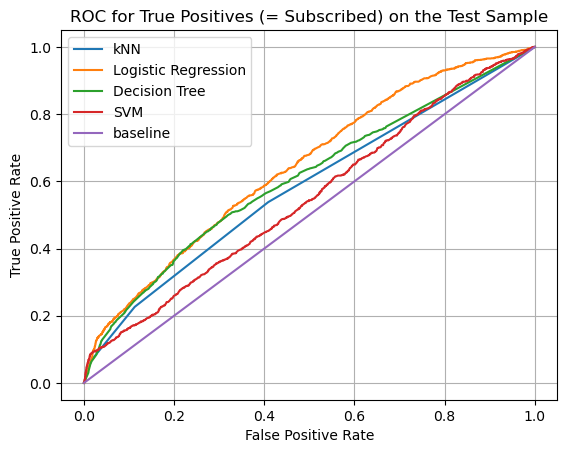

In [66]:
#ROC for kNN, logistic regression and decision tree
labels = ['kNN', 'Logistic Regression', 'Decision Tree', 'SVM']

fig, ax = plt.subplots()

for i in range(len(modelList)):
    modelPipe = Pipeline([('transformer',transformer),
                     ('model',modelList[i])]).fit(X_train,y_train)
    RocCurveDisplay.from_estimator(modelPipe, X_test, y_test,ax=ax,label = labels[i])

plt.grid()
plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label = 'baseline');
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for True Positives (= Subscribed) on the Test Sample')
plt.legend();

If we build a model using the default parameters, both logistic regression and decision tree models perform better kNN and SVM based on multiple dimensions:

* Higher lift the test sample
* Easier to explain the factors associated with the prospects who are more likely to take up an offer

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

### Feature engineering steps for socioeconomic information features:

|Variable | Action | Description | 
| :--- | :---- | :---| 
|contact| Label encode according to the following order | telephone -> 0, cellular -> 1| 
|month | One hot encode | 
|day_of_week | Label encode according to the following order | mon ->0, fri -> 1, tue -> 2, wed -> 2, thu -> 2| 
|poutcome | Label encode according to the following order | nonexistent -> 0, failure -> 1, success -> 2| 
|campaign|Drop| 
|pdays | Keep as is|
|previous | Keep as is|
|emp.var.rate|Keep as is| 
|nr.employed|Drop| 
|cons.price.idx|Keep as is| 
|cons.conf.idx|Keep as is| 
|euribor3m|Drop|

In [67]:
#Create a dataset with contact and socioeconomic variables
dfSE = df[['contact','month','day_of_week','poutcome','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx']]
dfSE.head()

,contact,month,day_of_week,poutcome,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx
0,telephone,may,mon,nonexistent,999,0,1.1,93.994,-36.4
1,telephone,may,mon,nonexistent,999,0,1.1,93.994,-36.4
2,telephone,may,mon,nonexistent,999,0,1.1,93.994,-36.4
3,telephone,may,mon,nonexistent,999,0,1.1,93.994,-36.4
4,telephone,may,mon,nonexistent,999,0,1.1,93.994,-36.4


In [68]:
##Label encode 'contact'
contact_dict = {'cellular':1,'telephone':0}

dfSE['contactLE'] = dfSE['contact'].map(contact_dict)

#Review the mapping 
dfSE['contact'].value_counts().sort_values()
dfSE['contactLE'].value_counts().sort_values()

contact
telephone    15044
cellular     26144
Name: count, dtype: int64

contactLE
0    15044
1    26144
Name: count, dtype: int64

In [69]:
##Hot encode 'month'
dfMonth = pd.get_dummies(dfSE['month'],drop_first = True)
dfSE = dfSE.join(dfMonth)

In [70]:
##Label encode 'day_of_week'
dayOfWeek_dict = {'mon':0,'fri':1,'tue':2,'wed':2,'thu':2}

dfSE['dayOfWeekL'] = dfSE['day_of_week'].map(dayOfWeek_dict)

#Confirm the mapping was done correctly
dfSE['day_of_week'].value_counts().sort_values()
dfSE['dayOfWeekL'].value_counts().sort_values()

day_of_week
fri    7827
tue    8090
wed    8134
mon    8514
thu    8623
Name: count, dtype: int64

dayOfWeekL
1     7827
0     8514
2    24847
Name: count, dtype: int64

In [71]:
##Label encode 'poutcome'
poutcome_dict = {'nonexistent':0,'failure':1,'success':2}

dfSE['poutcomeLE'] = dfSE['poutcome'].map(poutcome_dict)

#Review the mapping 
dfSE['poutcome'].value_counts().sort_values()
dfSE['poutcomeLE'].value_counts().sort_values()

poutcome
success         1373
failure         4252
nonexistent    35563
Name: count, dtype: int64

poutcomeLE
2     1373
1     4252
0    35563
Name: count, dtype: int64

In [72]:
dfSE.head()

,contact,month,day_of_week,poutcome,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,contactLE,...,dec,jul,jun,mar,may,nov,oct,sep,dayOfWeekL,poutcomeLE
0,telephone,may,mon,nonexistent,999,0,1.1,93.994,-36.4,0,...,False,False,False,False,True,False,False,False,0,0
1,telephone,may,mon,nonexistent,999,0,1.1,93.994,-36.4,0,...,False,False,False,False,True,False,False,False,0,0
2,telephone,may,mon,nonexistent,999,0,1.1,93.994,-36.4,0,...,False,False,False,False,True,False,False,False,0,0
3,telephone,may,mon,nonexistent,999,0,1.1,93.994,-36.4,0,...,False,False,False,False,True,False,False,False,0,0
4,telephone,may,mon,nonexistent,999,0,1.1,93.994,-36.4,0,...,False,False,False,False,True,False,False,False,0,0


In [73]:
#Drop processed variables
dfSE = dfSE.drop(columns = ['contact','month','day_of_week','poutcome'])
dfSE.head()

,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,contactLE,aug,dec,jul,jun,mar,may,nov,oct,sep,dayOfWeekL,poutcomeLE
0,999,0,1.1,93.994,-36.4,0,False,False,False,False,False,True,False,False,False,0,0
1,999,0,1.1,93.994,-36.4,0,False,False,False,False,False,True,False,False,False,0,0
2,999,0,1.1,93.994,-36.4,0,False,False,False,False,False,True,False,False,False,0,0
3,999,0,1.1,93.994,-36.4,0,False,False,False,False,False,True,False,False,False,0,0
4,999,0,1.1,93.994,-36.4,0,False,False,False,False,False,True,False,False,False,0,0


In [74]:
#Join bank data with contact data
dfSE = dfSE.join(dfBank)

In [75]:
dfSE.head()
dfSE.shape

,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,contactLE,aug,dec,jul,jun,...,management,retired,self-employed,services,student,unemployed,unknown,maritalGrouped,educationGrouped,defaultGrouped
0,999,0,1.1,93.994,-36.4,0,False,False,False,False,...,False,False,False,False,False,False,False,0,1,1
1,999,0,1.1,93.994,-36.4,0,False,False,False,False,...,False,False,False,True,False,False,False,0,4,0
2,999,0,1.1,93.994,-36.4,0,False,False,False,False,...,False,False,False,True,False,False,False,0,4,1
3,999,0,1.1,93.994,-36.4,0,False,False,False,False,...,False,False,False,True,False,False,False,0,2,1
4,999,0,1.1,93.994,-36.4,0,False,False,False,False,...,False,False,False,True,False,False,False,0,4,1


(41188, 29)

In [76]:
#create train/test samples
X_train, X_test, y_train, y_test = train_test_split(dfSE.drop(columns = ['y']),dfSE['y'],test_size=0.3,random_state = 42, stratify = dfSE['y'])

### Fit models with default values

In [77]:
modelList = [KNeighborsClassifier(),
             LogisticRegression(random_state = 42, max_iter = 10000), 
             DecisionTreeClassifier(random_state = 42),
            SVC(random_state = 42)]

In [78]:
#Train K-Nearest Neighbor, logistic regression, decision classifier and SVN models with default parameters
runTime = []
accuracyScoreTrain = []
accuracyScoreTest = []

precisionScoreTrain = []
precisionScoreTest = []

recallScoreTrain = []
recallScoreTest = []

f1ScoreTrain = []
f1ScoreTest = []


for i in range(len(modelList)):
    t1 = timeit.default_timer()
    modelPipe = Pipeline([('transformer',transformer),
                     ('model',modelList[i])]).fit(X_train,y_train)
    t2 = timeit.default_timer()
    runTime.append(np.round((t2-t1),2))
    
    y_train_predicted = modelPipe.predict(X_train)
    y_test_predicted = modelPipe.predict(X_test)
    
    accuracyScoreTrain.append(np.round(accuracy_score(y_train, y_train_predicted),3))
    accuracyScoreTest.append(np.round(accuracy_score(y_test, y_test_predicted),3))
    
    precisionScoreTrain.append(np.round(precision_score(y_train, y_train_predicted),3))
    precisionScoreTest.append(np.round(precision_score(y_test, y_test_predicted),3))
    
    recallScoreTrain.append(np.round(recall_score(y_train, y_train_predicted),3))
    recallScoreTest.append(np.round(recall_score(y_test, y_test_predicted),3))
    
    f1ScoreTrain.append(np.round(f1_score(y_train, y_train_predicted),3))
    f1ScoreTest.append(np.round(f1_score(y_test, y_test_predicted),3))
    

In [79]:
#Summarize results
listOfModels = ['kNN','Logistic Regression','Decision Tree','SVM']

dfStats = pd.DataFrame(zip(listOfModels, runTime, accuracyScoreTrain, accuracyScoreTest,precisionScoreTrain, precisionScoreTest, recallScoreTrain, recallScoreTest, f1ScoreTrain, f1ScoreTest), 
                       columns = ['Model','Train Time (in seconds)','Train Accuracy','Test Accuracy', 'Train Precision', 'Test Precision', 'Train Recall','Test Recall','F1-Score Train','F1-Score Test'])

dfStats

,Model,Train Time (in seconds),Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,F1-Score Train,F1-Score Test
0,kNN,0.04,0.912,0.893,0.701,0.547,0.390,0.295,0.501,0.383
1,Logistic Regression,4.08,0.897,0.899,0.636,0.682,0.197,0.187,0.301,0.293
2,Decision Tree,0.13,0.964,0.866,0.979,0.385,0.698,0.312,0.815,0.345
3,SVM,3.54,0.897,0.898,0.630,0.660,0.213,0.198,0.318,0.305


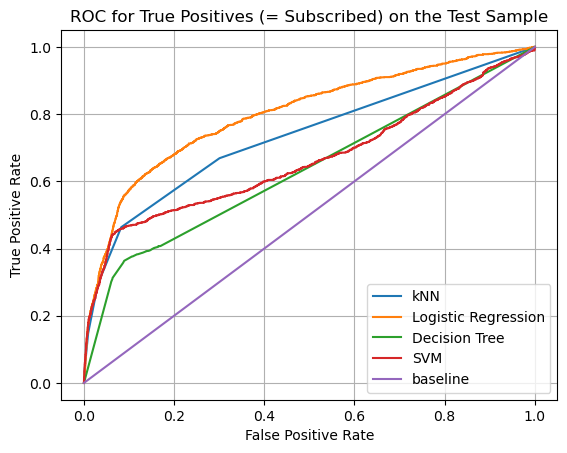

In [80]:
#ROC for kNN, logistic regression and decision tree
labels = ['kNN', 'Logistic Regression', 'Decision Tree', 'SVM']

fig, ax = plt.subplots()

for i in range(len(modelList)):
    modelPipe = Pipeline([('transformer',transformer),
                     ('model',modelList[i])]).fit(X_train,y_train)
    RocCurveDisplay.from_estimator(modelPipe, X_test, y_test,ax=ax,label = labels[i])

plt.grid()
plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label = 'baseline');
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for True Positives (= Subscribed) on the Test Sample')
plt.legend();

The models built using default settings with additional parameters (bank data and socioeconomic data) outperforms the models built with bank variables only. Logistic regression has higher lift compared to other models. We will look deeper into the logistic regression in the next section. 

### Logistic Regression - deeper analysis

In [81]:
#Build a logistic regression pipeline
lgrPipe = Pipeline([('transformer',transformer),
                     ('lgr',LogisticRegression(random_state = 42, max_iter = 10000))]).fit(X_train,y_train)

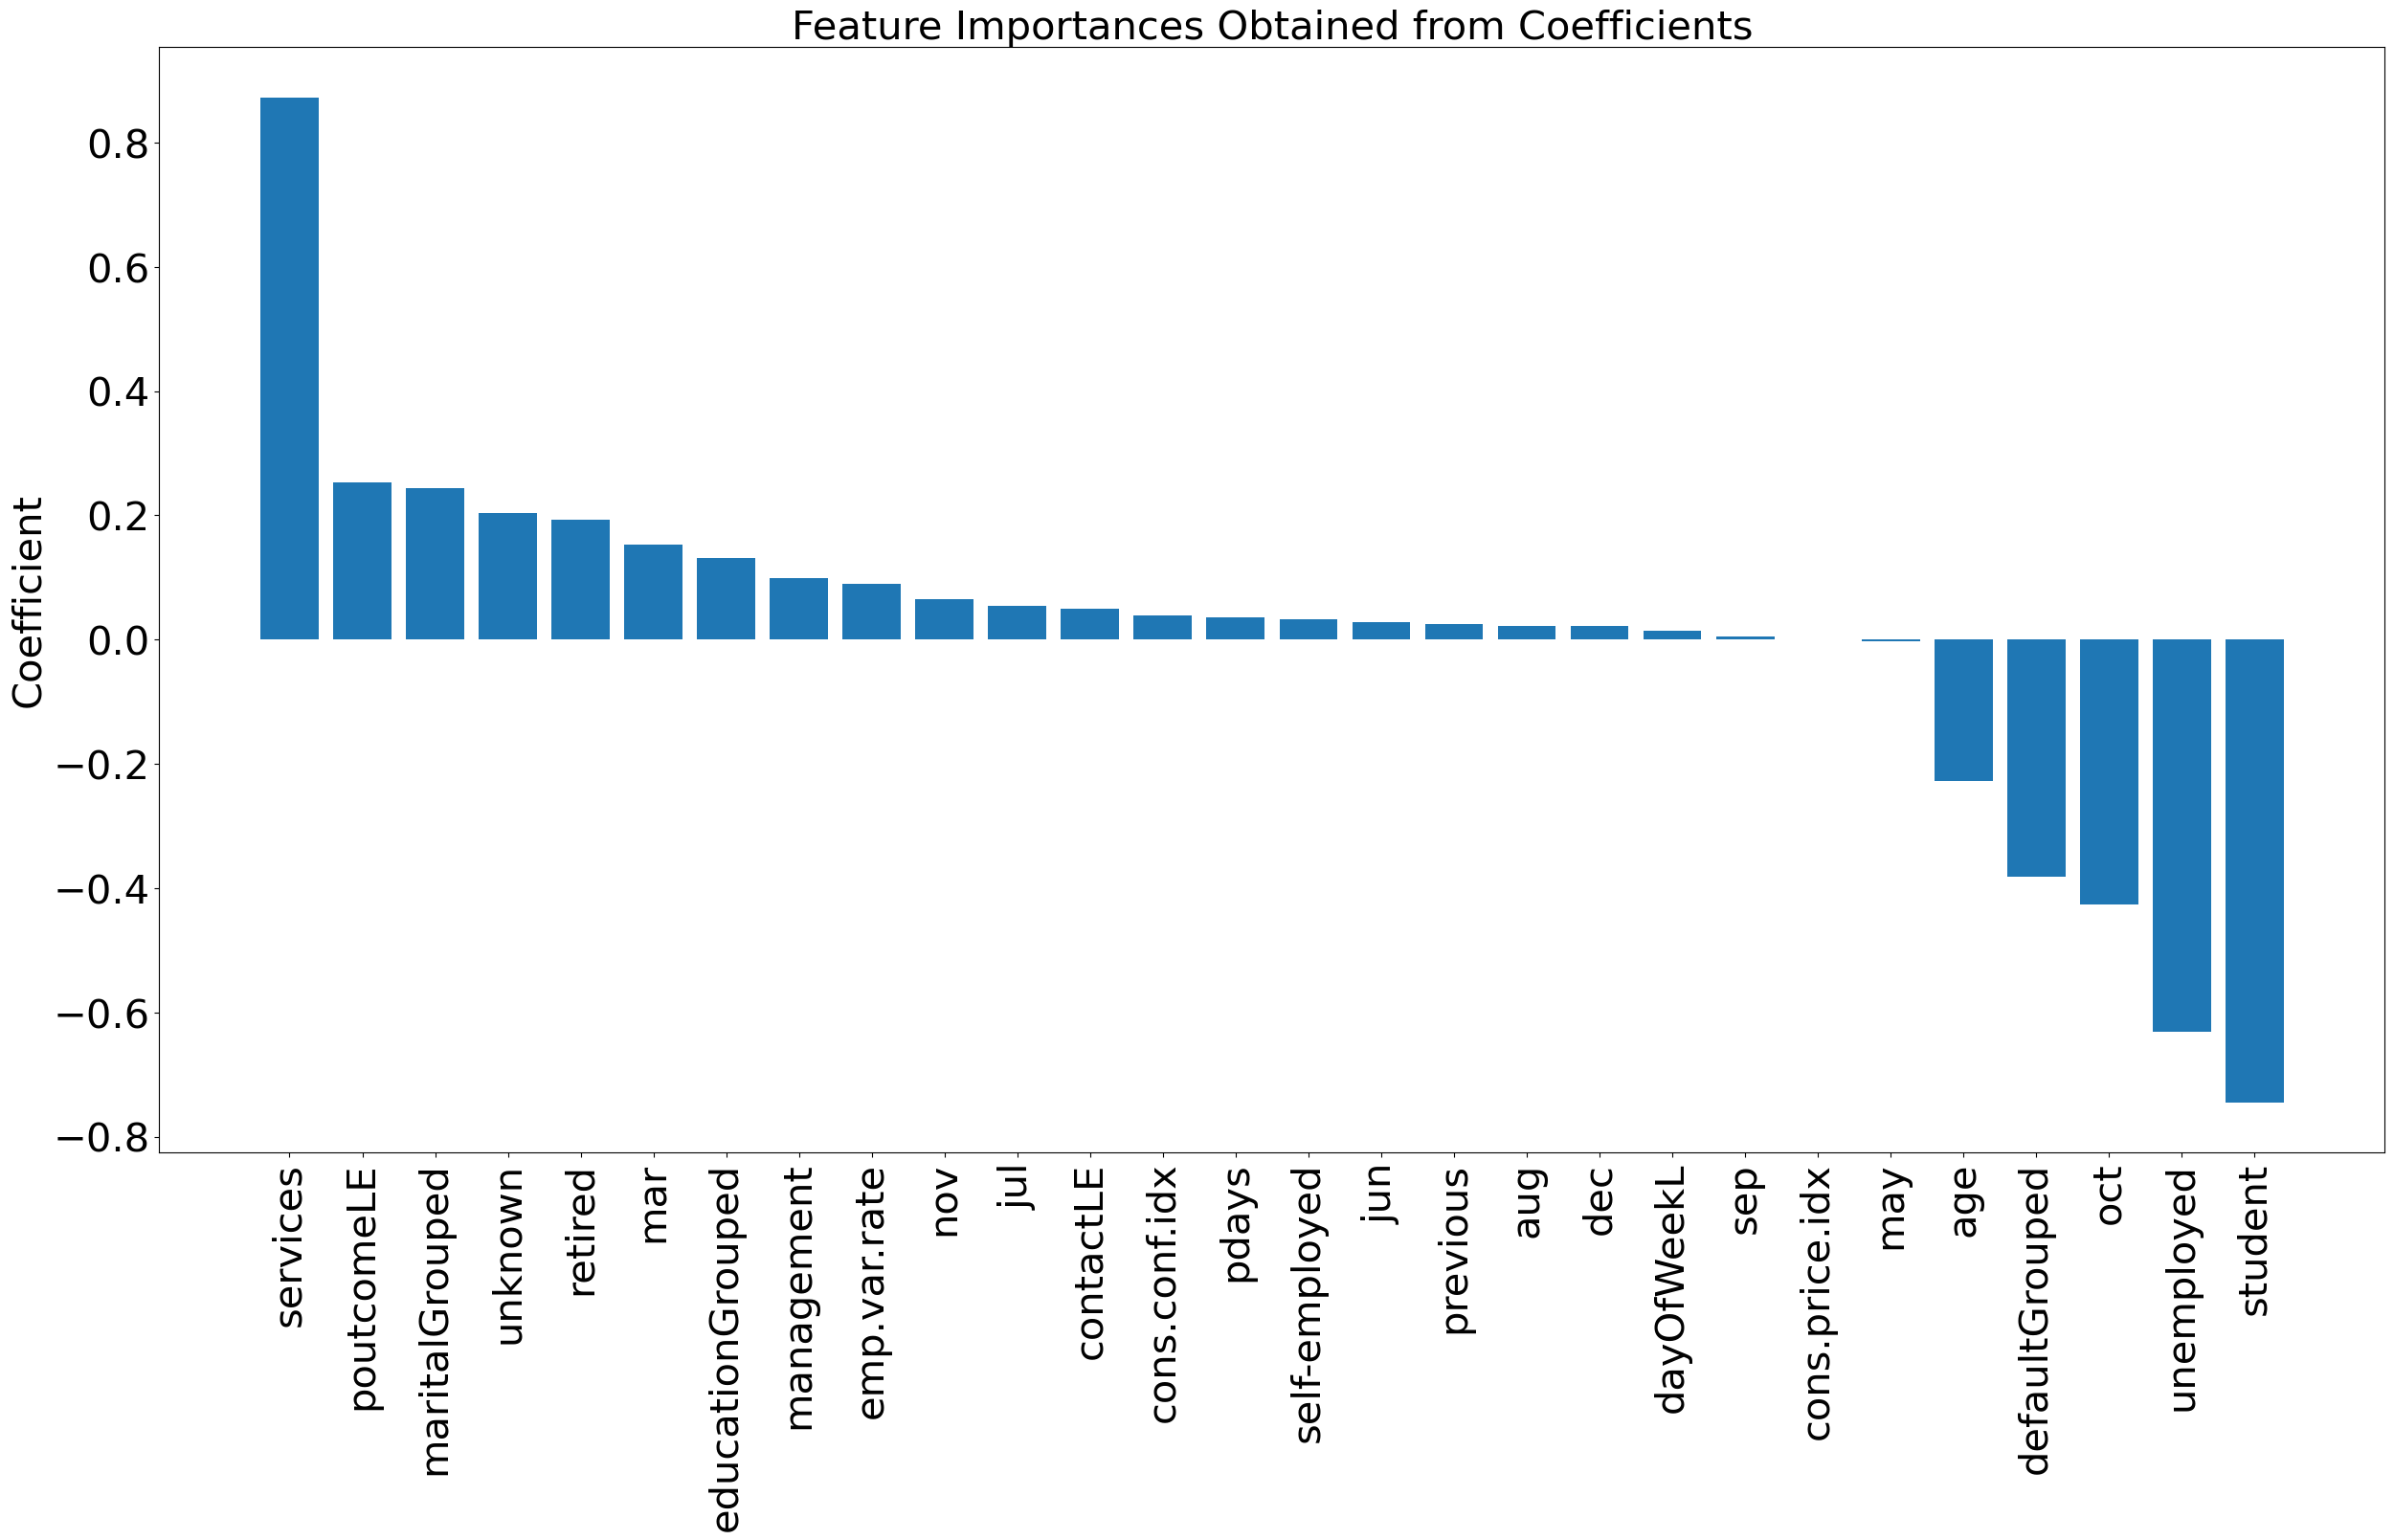

In [82]:
importances = pd.DataFrame(data={
    'Feature': X_train.columns,
    'Importance': lgrPipe.named_steps["lgr"].coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

fig, ax = plt.subplots(1, figsize = (30, 15))
ax.bar(x=importances['Feature'], height=importances['Importance'])
ax.set_title('Feature Importances Obtained from Coefficients', size = 30)
ax.set_ylabel('Coefficient', fontsize = 30)
ax.tick_params(axis = 'x',labelrotation=90, labelsize=30)
ax.tick_params(axis = 'y', labelsize=30)
plt.show();

In [83]:
#Drop variables with coefficients close to zero
dropVarList = ['sep','cons.price.idx','may']

dfSE_upd = dfSE.drop(columns = dropVarList)

In [84]:
#Create train/test sample
X_train, X_test, y_train, y_test = train_test_split(dfSE_upd.drop(columns = ['y']),dfSE_upd['y'],test_size=0.3,random_state = 42, stratify = dfSE_upd['y'])

In [85]:
#Scale all the variables
transformer = make_column_transformer((StandardScaler(), list(X_train.columns)),
                                      remainder = 'passthrough' )

In [86]:
#Build a logistic regression pipeline
lgrPipe = Pipeline([('transformer',transformer),
                     ('lgr',LogisticRegression(random_state = 42, max_iter = 10000))]).fit(X_train,y_train)

y_train_predicted = lgrPipe.predict(X_train)
y_test_predicted = lgrPipe.predict(X_test)

y_train_predicted_proba = lgrPipe.predict_proba(X_train)
y_test_predicted_proba = lgrPipe.predict_proba(X_test)

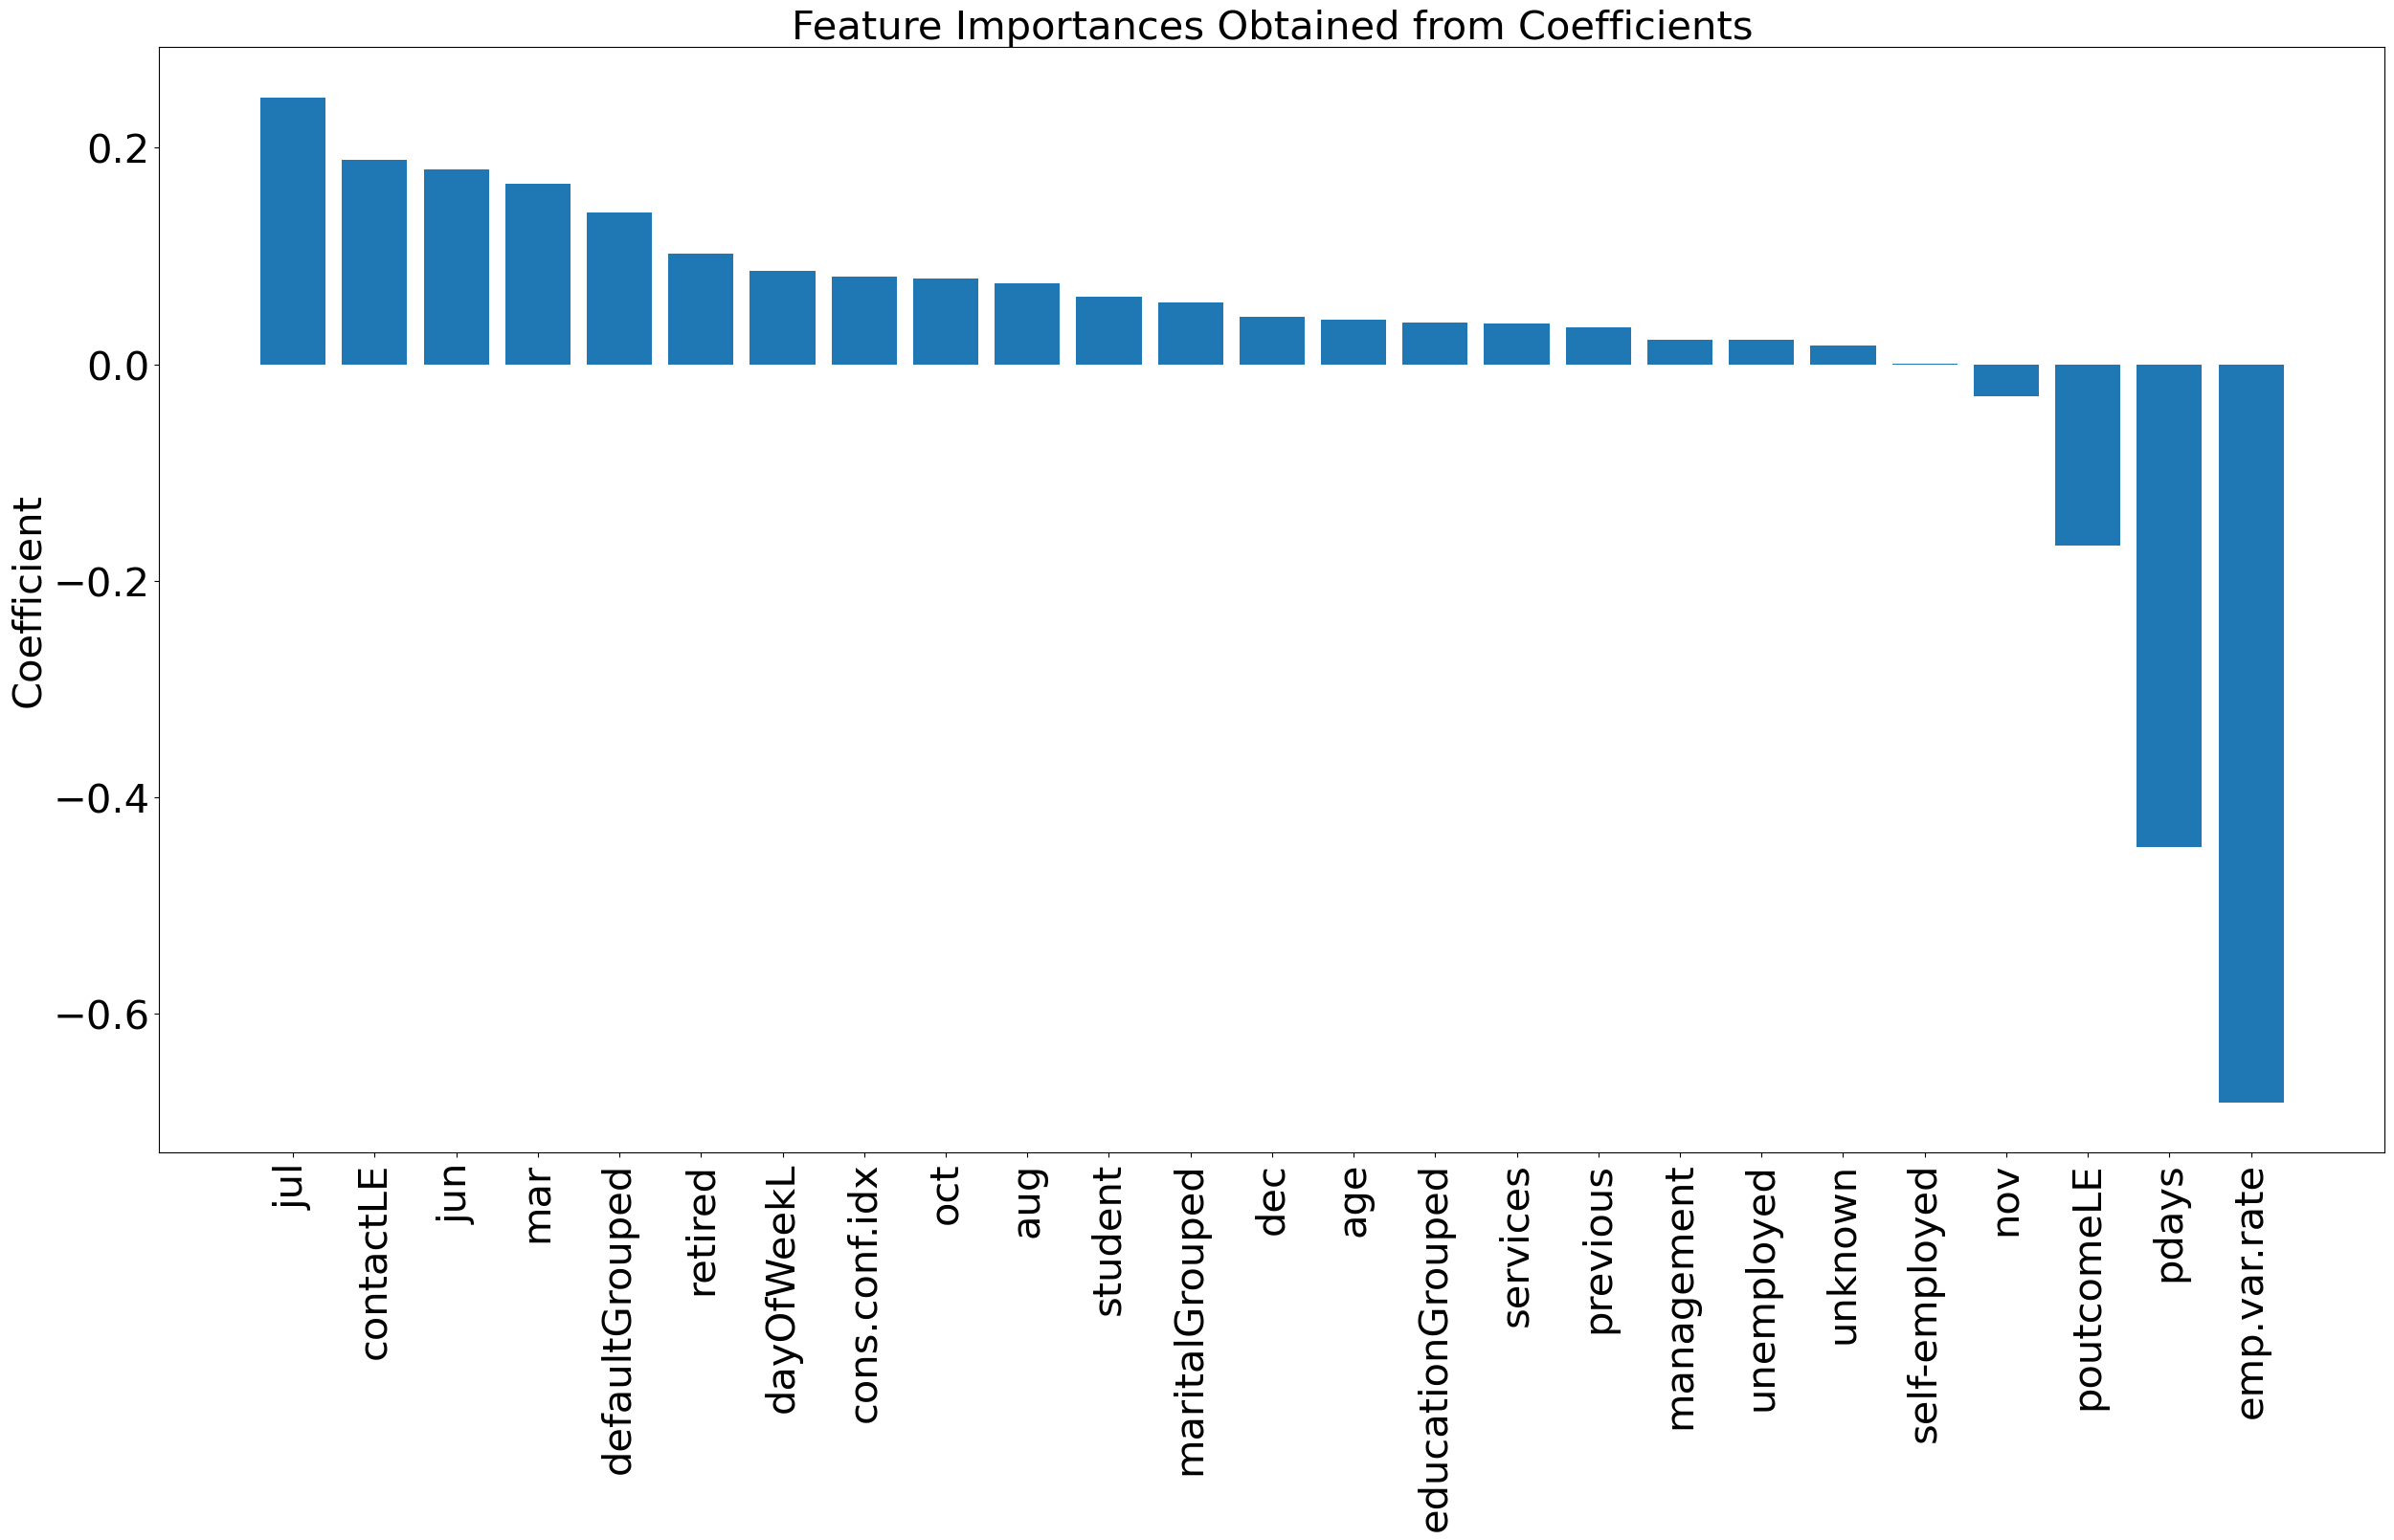

In [87]:
importances = pd.DataFrame(data={
    'Feature': X_train.columns,
    'Importance': lgrPipe.named_steps["lgr"].coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

fig, ax = plt.subplots(1, figsize = (30, 15))
ax.bar(x=importances['Feature'], height=importances['Importance'])
ax.set_title('Feature Importances Obtained from Coefficients', size = 30)
ax.set_ylabel('Coefficient', fontsize = 30)
ax.tick_params(axis = 'x',labelrotation=90, labelsize=30)
ax.tick_params(axis = 'y', labelsize=30)
plt.show();

In [88]:
#Generate performance metrics
y_train_predicted = lgrPipe.predict(X_train)
y_test_predicted = lgrPipe.predict(X_test)
    
accuracyScoreTrain.append(np.round(accuracy_score(y_train, y_train_predicted),3))
accuracyScoreTest.append(np.round(accuracy_score(y_test, y_test_predicted),3))
    
precisionScoreTrain.append(np.round(precision_score(y_train, y_train_predicted),3))
precisionScoreTest.append(np.round(precision_score(y_test, y_test_predicted),3))
    
recallScoreTrain.append(np.round(recall_score(y_train, y_train_predicted),3))
recallScoreTest.append(np.round(recall_score(y_test, y_test_predicted),3))
    
f1ScoreTrain.append(np.round(f1_score(y_train, y_train_predicted),3))
f1ScoreTest.append(np.round(f1_score(y_test, y_test_predicted),3))

In [89]:
#Summarize results
listOfModels = ['Logistic Regression']

dfStats = pd.DataFrame(zip(listOfModels, runTime, accuracyScoreTrain, accuracyScoreTest,precisionScoreTrain, precisionScoreTest, recallScoreTrain, recallScoreTest, f1ScoreTrain, f1ScoreTest), 
                       columns = ['Model','Train Time (in seconds)','Train Accuracy','Test Accuracy', 'Train Precision', 'Test Precision', 'Train Recall','Test Recall','F1-Score Train','F1-Score Test'])

dfStats

,Model,Train Time (in seconds),Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,F1-Score Train,F1-Score Test
0,Logistic Regression,0.04,0.912,0.893,0.701,0.547,0.39,0.295,0.501,0.383


It seems timing plays a significant role in campaign success (month, day of week), as well as the way the prospects were contacted, which is an explainable result. I decided to try to further enhance the model adding polynomial transformation.

### Add Polynomial Transformation

In [90]:
#Apply a two-degree polynomial transformation
poly = PolynomialFeatures(2, include_bias = False)
X_train_poly = pd.DataFrame(poly.fit_transform(X_train),columns = poly.get_feature_names_out(X_train.columns).tolist())
X_test_poly = pd.DataFrame(poly.fit_transform(X_test),columns = poly.get_feature_names_out(X_train.columns).tolist())

In [91]:
transformer = make_column_transformer((StandardScaler(), X_train_poly.columns),
                                      remainder = 'passthrough' )

In [92]:
#Build a logistic regression pipeline and fit the new polynomial data
lgrPipe = Pipeline([('transformer',transformer),
                     ('lgr',LogisticRegression(random_state = 42, max_iter = 10000))]).fit(X_train_poly,y_train)

y_train_predicted = lgrPipe.predict(X_train_poly)
y_test_predicted = lgrPipe.predict(X_test_poly)

y_train_predicted_proba = lgrPipe.predict_proba(X_train_poly)
y_test_predicted_proba = lgrPipe.predict_proba(X_test_poly)

In [93]:
#Generate performance metrics
    
accuracyScoreTrain.append(np.round(accuracy_score(y_train, y_train_predicted),3))
accuracyScoreTest.append(np.round(accuracy_score(y_test, y_test_predicted),3))
    
precisionScoreTrain.append(np.round(precision_score(y_train, y_train_predicted),3))
precisionScoreTest.append(np.round(precision_score(y_test, y_test_predicted),3))
    
recallScoreTrain.append(np.round(recall_score(y_train, y_train_predicted),3))
recallScoreTest.append(np.round(recall_score(y_test, y_test_predicted),3))
    
f1ScoreTrain.append(np.round(f1_score(y_train, y_train_predicted),3))
f1ScoreTest.append(np.round(f1_score(y_test, y_test_predicted),3))

In [94]:
#Summarize results
listOfModels = ['Logistic Regression']

dfStats = pd.DataFrame(zip(listOfModels, runTime, accuracyScoreTrain, accuracyScoreTest,precisionScoreTrain, precisionScoreTest, recallScoreTrain, recallScoreTest, f1ScoreTrain, f1ScoreTest), 
                       columns = ['Model','Train Time (in seconds)','Train Accuracy','Test Accuracy', 'Train Precision', 'Test Precision', 'Train Recall','Test Recall','F1-Score Train','F1-Score Test'])

dfStats

,Model,Train Time (in seconds),Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,F1-Score Train,F1-Score Test
0,Logistic Regression,0.04,0.912,0.893,0.701,0.547,0.39,0.295,0.501,0.383


There does not seem to be any noticeable improvement in performance after adding the polynomial features.

### Fine-tuning Logistic Regression Hyperparameters

In [95]:
#Create train/test sample
X_train, X_test, y_train, y_test = train_test_split(dfSE_upd.drop(columns = ['y']),dfSE_upd['y'],test_size=0.3,random_state = 42, stratify = dfSE_upd['y'])

In [96]:
#Scale all the variables
transformer = make_column_transformer((StandardScaler(), list(X_train.columns)),
                                      remainder = 'passthrough' )

In [97]:
#Build a pipeline for Grid Search
extractor = SelectFromModel(LogisticRegression(penalty='l1', solver = 'liblinear' ,random_state = 42))
lgr_pipe_grid = Pipeline([('transformer',transformer),
                     ('selector',extractor),
                     ('lgr',LogisticRegression( solver = 'liblinear',random_state = 42, max_iter = 100000))])

In [98]:
#Run Grid Search for max_features, penalty and C.
roc_grid_lgr = GridSearchCV(lgr_pipe_grid,
                        param_grid= {'selector__max_features':[5,10,15,20,24],
                                     'lgr__penalty':['l1','l2'],
                                     'lgr__C': np.logspace(-3, 3, 7, endpoint = True).tolist()}, 
                        scoring = 'roc_auc').fit(X_train, y_train)
roc_grid_lgr.best_params_

{'lgr__C': 0.01, 'lgr__penalty': 'l2', 'selector__max_features': 24}

In [99]:
#Build a logistic regression model with the best parameters according to the Grid search
lgrPipe_grid = Pipeline([('transformer',transformer),
                     ('selector',SelectFromModel(LogisticRegression(penalty='l1', solver = 'liblinear' ,random_state = 42),
                      max_features = roc_grid_lgr.best_params_.get('selectors__max_features'))),
                     ('lgr',LogisticRegression(penalty = roc_grid_lgr.best_params_.get('lgr__penalty'), C = roc_grid_lgr.best_params_.get('lgr__C'), solver = 'liblinear',random_state = 42, max_iter = 100000))]).fit(X_train,y_train)

y_train_predicted = lgrPipe_grid.predict(X_train)
y_test_predicted = lgrPipe_grid.predict(X_test)

y_train_predicted_proba = lgrPipe_grid.predict_proba(X_train)
y_test_predicted_proba = lgrPipe_grid.predict_proba(X_test)

In [100]:
#Generate performance metrics
    
accuracyScoreTrain.append(np.round(accuracy_score(y_train, y_train_predicted),3))
accuracyScoreTest.append(np.round(accuracy_score(y_test, y_test_predicted),3))
    
precisionScoreTrain.append(np.round(precision_score(y_train, y_train_predicted),3))
precisionScoreTest.append(np.round(precision_score(y_test, y_test_predicted),3))
    
recallScoreTrain.append(np.round(recall_score(y_train, y_train_predicted),3))
recallScoreTest.append(np.round(recall_score(y_test, y_test_predicted),3))
    
f1ScoreTrain.append(np.round(f1_score(y_train, y_train_predicted),3))
f1ScoreTest.append(np.round(f1_score(y_test, y_test_predicted),3))

In [101]:
#Summarize results
listOfModels = ['Logistic Regression']

dfStats = pd.DataFrame(zip(listOfModels, runTime, accuracyScoreTrain, accuracyScoreTest,precisionScoreTrain, precisionScoreTest, recallScoreTrain, recallScoreTest, f1ScoreTrain, f1ScoreTest), 
                       columns = ['Model','Train Time (in seconds)','Train Accuracy','Test Accuracy', 'Train Precision', 'Test Precision', 'Train Recall','Test Recall','F1-Score Train','F1-Score Test'])

dfStats

,Model,Train Time (in seconds),Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,F1-Score Train,F1-Score Test
0,Logistic Regression,0.04,0.912,0.893,0.701,0.547,0.39,0.295,0.501,0.383


Grid search did not seem to improve the performance of the model. Below is the final ROC curve for the logistic regression model, which demonstrates good separation between subscrubers and non-subscribers.

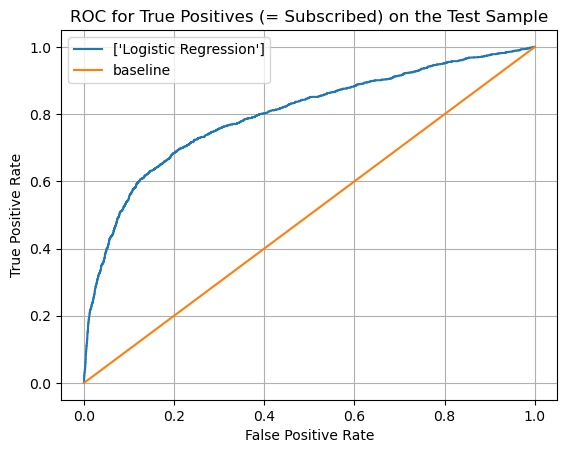

In [103]:
#ROC for logistic regression and decision tree
labels = ['Logistic Regression']

fig, ax = plt.subplots()

RocCurveDisplay.from_estimator(lgrPipe_grid, X_test, y_test,ax=ax,label = labels)

plt.grid()
plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label = 'baseline');
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for True Positives (= Subscribed) on the Test Sample')
plt.legend();

### Findings

The primary objective of the project was to predict whether the prospect will subscribe to the service based on the observed characteristics of the prospect. In other words, we were trying to uncover the attributes which differentiate subscribers and non-subscribers. 

As the result of the analysis we developed several models (KNN, Logistic regression, Decision Tree annd SVM) to identify factors which impact the decision of a prospect to subscribe to the service. We used accuracy, precision, recall, F1 metrics and ROC-AUC curve to identify the best model. 

Logistic regression outperformed the other models in terms of performance metrics and runtime. The below ROC curve shows that the logistic regression captures more of the subscribers for the same percentage of non-subscribers when bank variables and socioeconmic variables are included in the analysis.

![Screenshot](./images/ROC_AUC.png)

As we analysed coefficients of the logistic regression, the following prospects are morely likely to accept the offer to subscribe:

* Prospects without defaults
* Students and retired customers
* Older prospects
* Single prospects
* Highly educated prospects

Additionally, timing plays a significant role in campaign success (month, day of week), as well as the way the prospects were contacted.

### Next Steps and Recommendations

The dataset provided by the bank seems to have multiple issues with data quality (some variables and relationship with the target did not make sense). I recommend contacting the data provider and asking questions regarding the data, then further fine-tuning the models. 


Additionally, it would be interesting to conduct a cost-benefit analysis in order to create a strategy for the bank, based on cost of contacting a prospect vs profit from a booked account. 

As immediate next steps, the bank may start implementing the strategy based on the findings above - i.e. targeting the groups of prospects who are more likley to subscribe and increasing the call volume on the days the prospects are more likely to accept the offers.

##### Questions